Importing the dependencies

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [ ]:
plt.rcParams['figure.figsize'] = (20,6)

downloading our csv file

In [ ]:
!gdown 1q8KKl03WBxrhcwCZcLDrlavVYyUfUdlf

Downloading...
From: https://drive.google.com/uc?id=1q8KKl03WBxrhcwCZcLDrlavVYyUfUdlf
To: /content/myntrasales.xlsx
100% 13.7k/13.7k [00:00<00:00, 18.2MB/s]


In [ ]:
myntra_sales = pd.read_excel('/content/myntrasales.xlsx')
myntra_sales.head()

DATE   Sales
0 2001-01-01  6519.0
1 2001-02-01  6654.0
2 2001-03-01  7332.0
3 2001-04-01  7332.0
4 2001-05-01  8240.0

In [ ]:
# set index as date
myntra_sales.set_index('DATE', inplace=True)

myntra_sales.head()

Sales
DATE              
2001-01-01  6519.0
2001-02-01  6654.0
2001-03-01  7332.0
2001-04-01  7332.0
2001-05-01  8240.0

## Data Preprocessing

Let's do all the data processing we learnt about in the last lecture
- Setting index as date
- Perform linear interpolation
- Taking care of anomalies by clipping values using quantiles
- Plotting the resultant time series

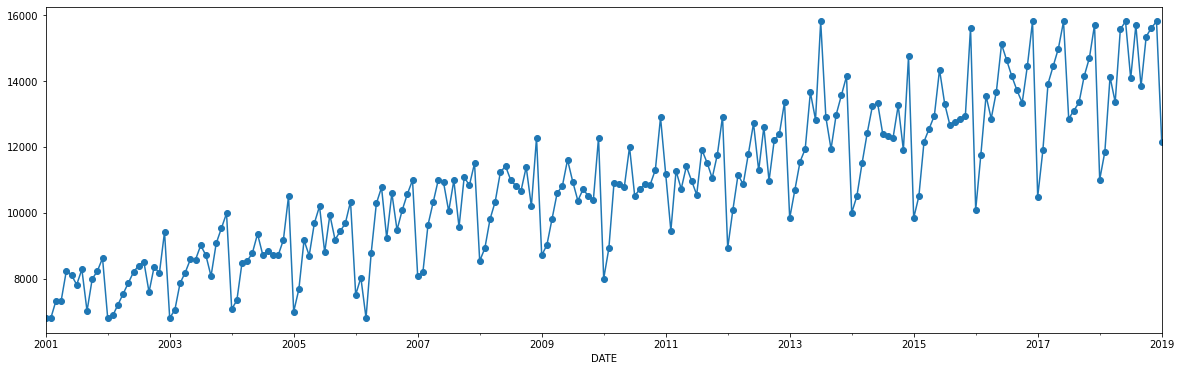

In [ ]:

# linear interpolation
myntra_sales.Sales = myntra_sales.Sales.interpolate(method='linear')

# anomalies - clip quantiles
myntra_sales.Sales = myntra_sales.Sales.clip(upper=myntra_sales.Sales.quantile(0.98), lower=myntra_sales.Sales.quantile(0.02))

# plot
myntra_sales.Sales.plot(style='-o', figsize=(20,6))

**Train - test splitting of data**

In [ ]:
train_max_date = myntra_sales.index[-12]
train_x = myntra_sales.loc[myntra_sales.index < myntra_sales.index[-12]].copy()
test_x = myntra_sales.loc[myntra_sales.index >= myntra_sales.index[-12]].copy()

test_x

Sales
DATE               
2018-02-01  11852.0
2018-03-01  14123.0
2018-04-01  13360.0
2018-05-01  15576.0
2018-06-01  15809.4
2018-07-01  14080.0
2018-08-01  15697.0
2018-09-01  13838.0
2018-10-01  15351.0
2018-11-01  15615.0
2018-12-01  15809.4
2019-01-01  12160.0

In [ ]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

## Moving average forecasting

*   List item
*   List item



we have already seen how we impute values with moving averages now we want to do a forecast based on that

### How can we do a forecast with moving average

In [ ]:
import numpy as np

df = myntra_sales.copy()

In [ ]:
pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS'))

Empty DataFrame
Columns: []
Index: [2019-01-01 00:00:00, 2019-02-01 00:00:00, 2019-03-01 00:00:00, 2019-04-01 00:00:00, 2019-05-01 00:00:00, 2019-06-01 00:00:00, 2019-07-01 00:00:00, 2019-08-01 00:00:00, 2019-09-01 00:00:00, 2019-10-01 00:00:00, 2019-11-01 00:00:00, 2019-12-01 00:00:00]


- we got the first entry as Jan-2019, which already existed in our series.
- In order to take care of this, we need to explicitly mention that we want values from the second index of the result of `pd.date_range()`
- Hence we utilise slicing by mentioning `[1:]`

In [ ]:
df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=13,freq='MS')[1:]))
df.tail(20)

Sales
2018-06-01  15809.4
2018-07-01  14080.0
2018-08-01  15697.0
2018-09-01  13838.0
2018-10-01  15351.0
2018-11-01  15615.0
2018-12-01  15809.4
2019-01-01  12160.0
2019-02-01      NaN
2019-03-01      NaN
2019-04-01      NaN
2019-05-01      NaN
2019-06-01      NaN
2019-07-01      NaN
2019-08-01      NaN
2019-09-01      NaN
2019-10-01      NaN
2019-11-01      NaN
2019-12-01      NaN
2020-01-01      NaN

In [ ]:
pred = df.Sales.dropna().values

for i in range(12):
  pred = np.append(pred, pred[-3:].mean())

pred[-20:]

array([15809.4       , 14080.        , 15697.        , 13838.        ,
       15351.        , 15615.        , 15809.4       , 12160.        ,
       14528.13333333, 14165.84444444, 13617.99259259, 14103.99012346,
       13962.6090535 , 13894.86392318, 13987.15436671, 13948.20911446,
       13943.40913479, 13959.59087199, 13950.40304041, 13951.13434906])

So, we can see that we have forecasts here, based on average of last 3 points for all new points.


Now let's plot this.

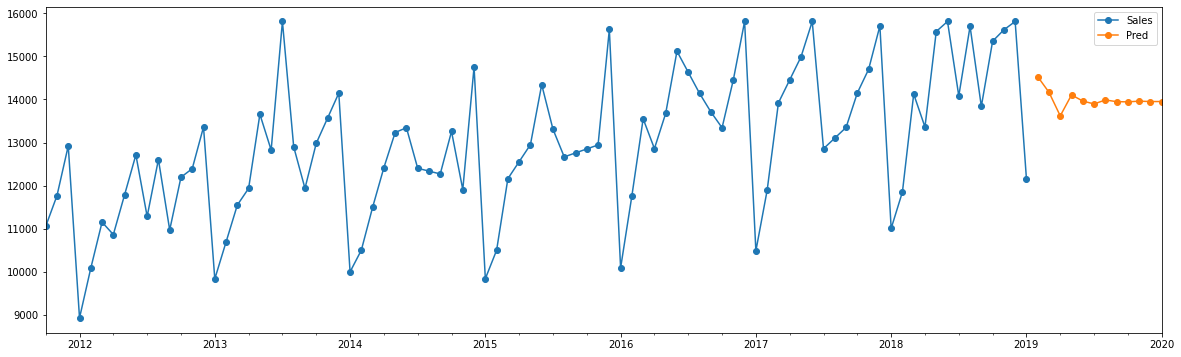

In [ ]:
df['Pred'] = pred

df.loc[~df['Sales'].isna(), 'Pred'] = np.nan
df.tail(100).plot(style='-o')

> **Q. Does this look like a good forecast?**

These forecasted values are certainly better than forecasting the mean/median or any constant values. At least, the levels looks okay.

However, it can be clearly seen that the forecast is not able to predict the variations and it gives a flat line after few predictions.

<br>

Also, if you think about it, this technique, doesn't seem to using the past data.

What is the point of having data spanning over 18 years, if we're just looking at the last 3 entries to forecast a new value.

> **Q. What would be the performance of the Moving Averages model?**

While we're at it, let's check the performance of Moving Averages model also, by using train and test sets.

MAE : 1692.467
RMSE : 1875.03
MAPE: 0.115


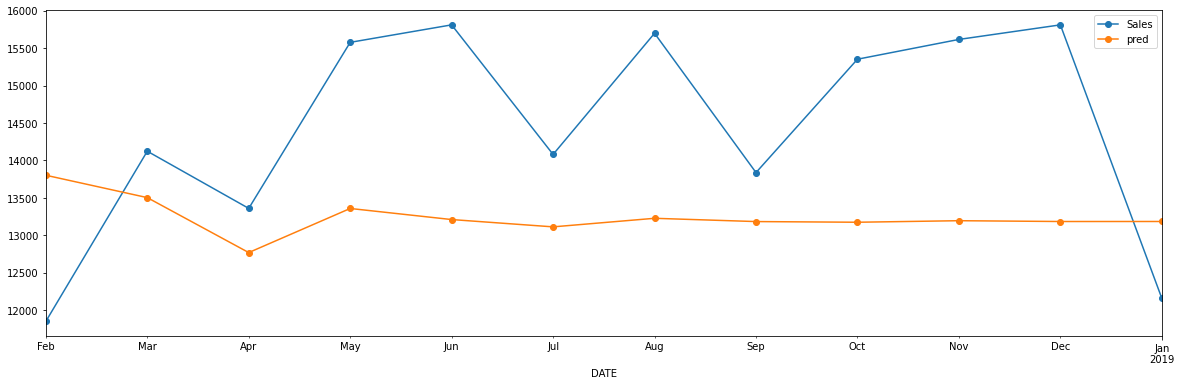

In [ ]:
df = train_x.copy()

df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS')[1:]))

pred = df.Sales.dropna().values

for i in range(12):
  pred = np.append(pred, pred[-3:].mean())

test_x['pred'] = pred[-12:]
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Drawbacks

- we see that after a few forecast points it seems to level out
- because it takes in consideration the last three point only the varince or spread decreases everytime till we get a straight line

# Simple exponential smoothing

As we saw just taking in account the recent values only is not the best solution, so what we want is to take in consideration the rest of the series as well

we will assign small weights to the past values instead of ignoring them completely.

Exponential Smoothing uses a weighted moving average as the forecast, with the assigned weights decreasing exponentially for periods farther in the past.

> Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight.

- SES forecast for next time step can be interpreted as a combination of previous time step's actual value and the forecast of the previous time step

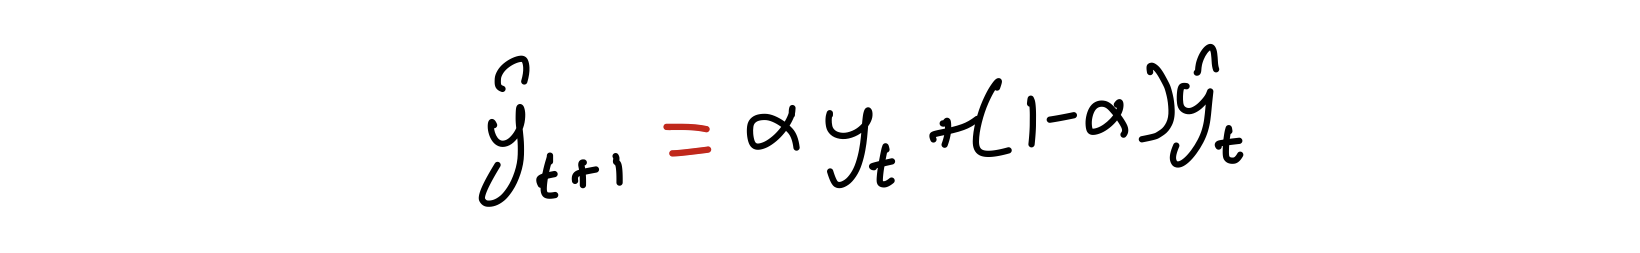

It requires a single parameter, called alpha (a), also called the smoothing factor or smoothing coefficient.

This parameter controls the rate at which the influence of the observations at prior time steps decay exponentially.

- Alpha values can range from 0 to 1, inclusive. Lower values produce smoother fitted lines because they give more weight to past observations, averaging out fluctuations over time. Higher values create a more jagged line because they weigh current data more highly, which reduces the degree of averaging by the older data.

> A weight of 1 causes the most recent observation to have all the weight, while all previous observations have no impact on the model. Consequently, the forecast values for α = 1 are simply the current value, which analysts refer to as naïve forecasting.

 ## $ \hat{y}_{t+1} = ay_t + (1-a)\hat{y}_{t-1}$
 ### Y pred at t+1 is equal to alpha times observed y at t  plus 1 minus alpha times y predicted at t

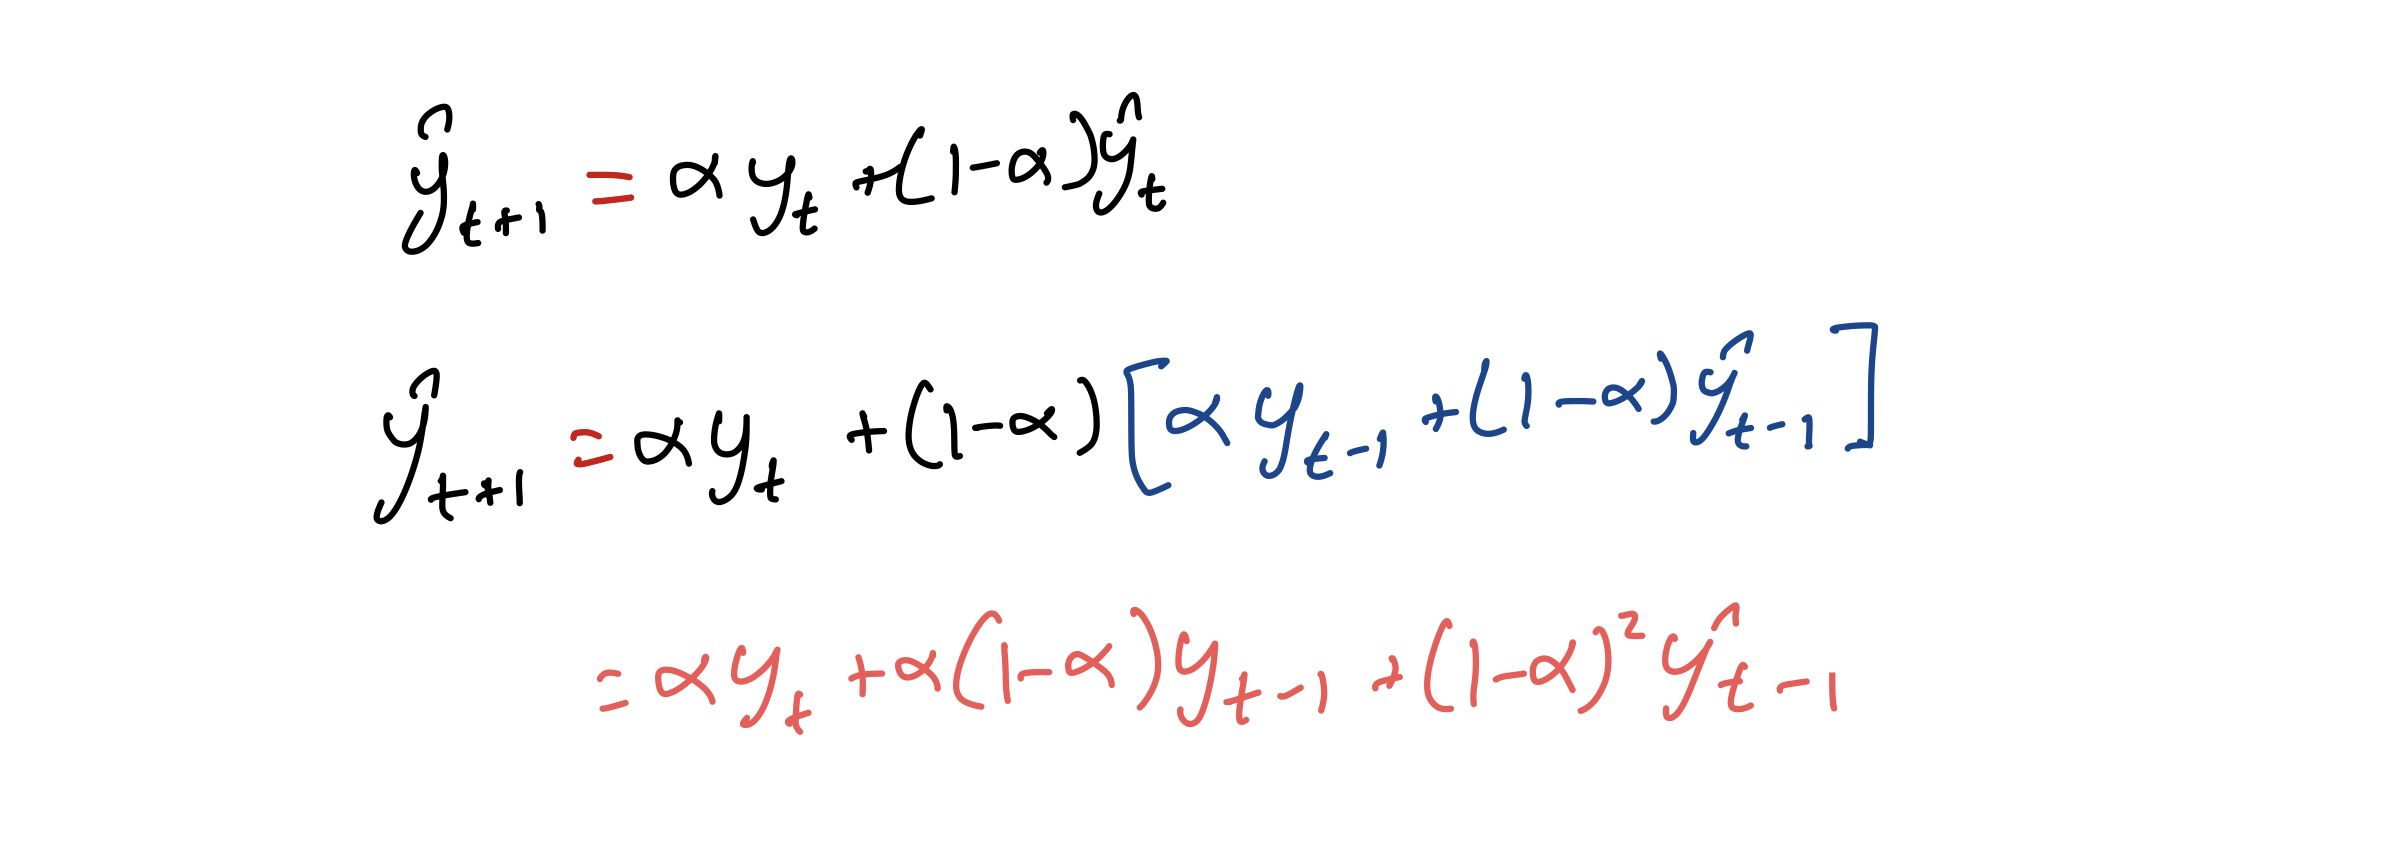

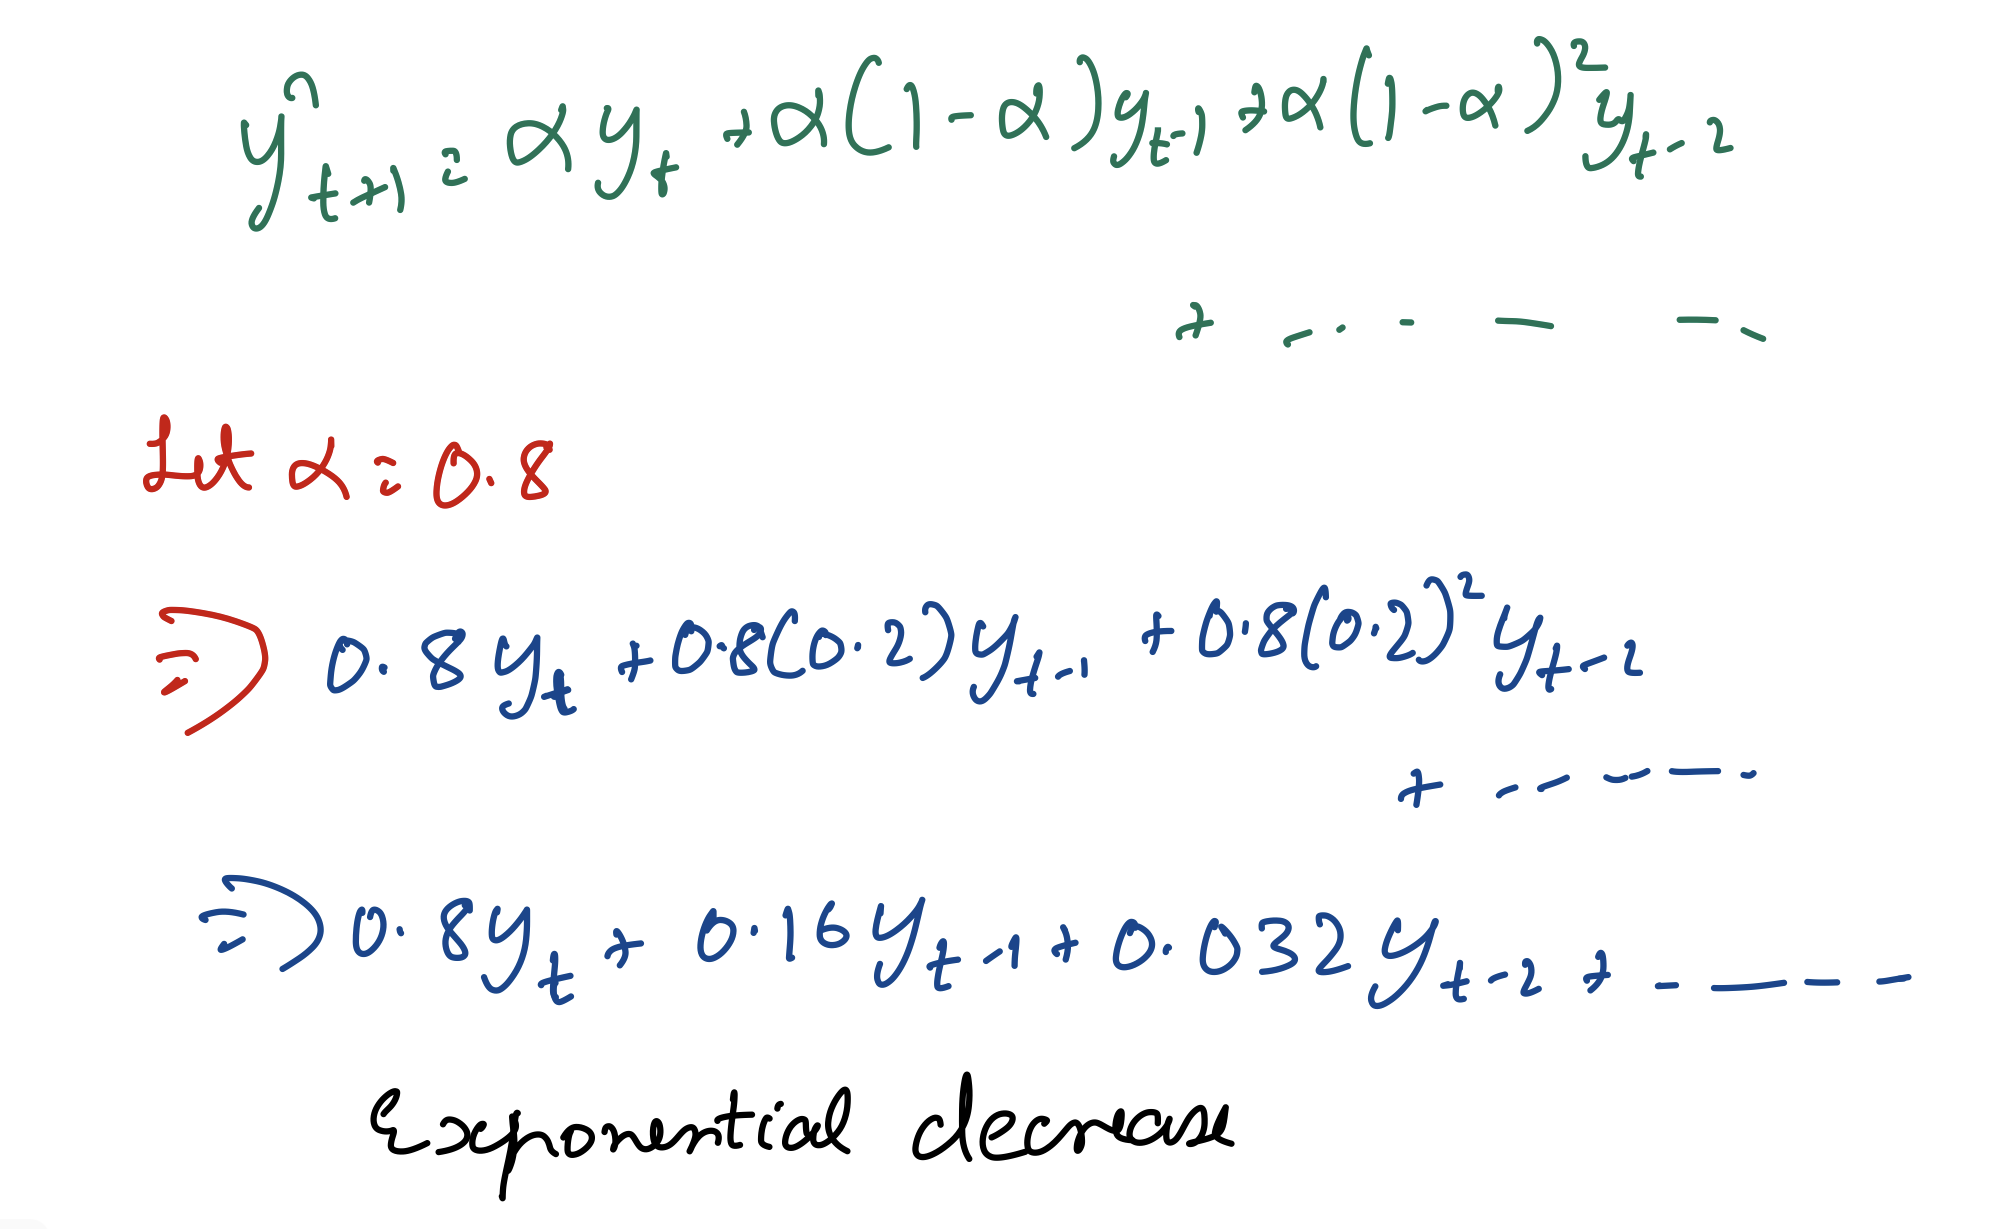

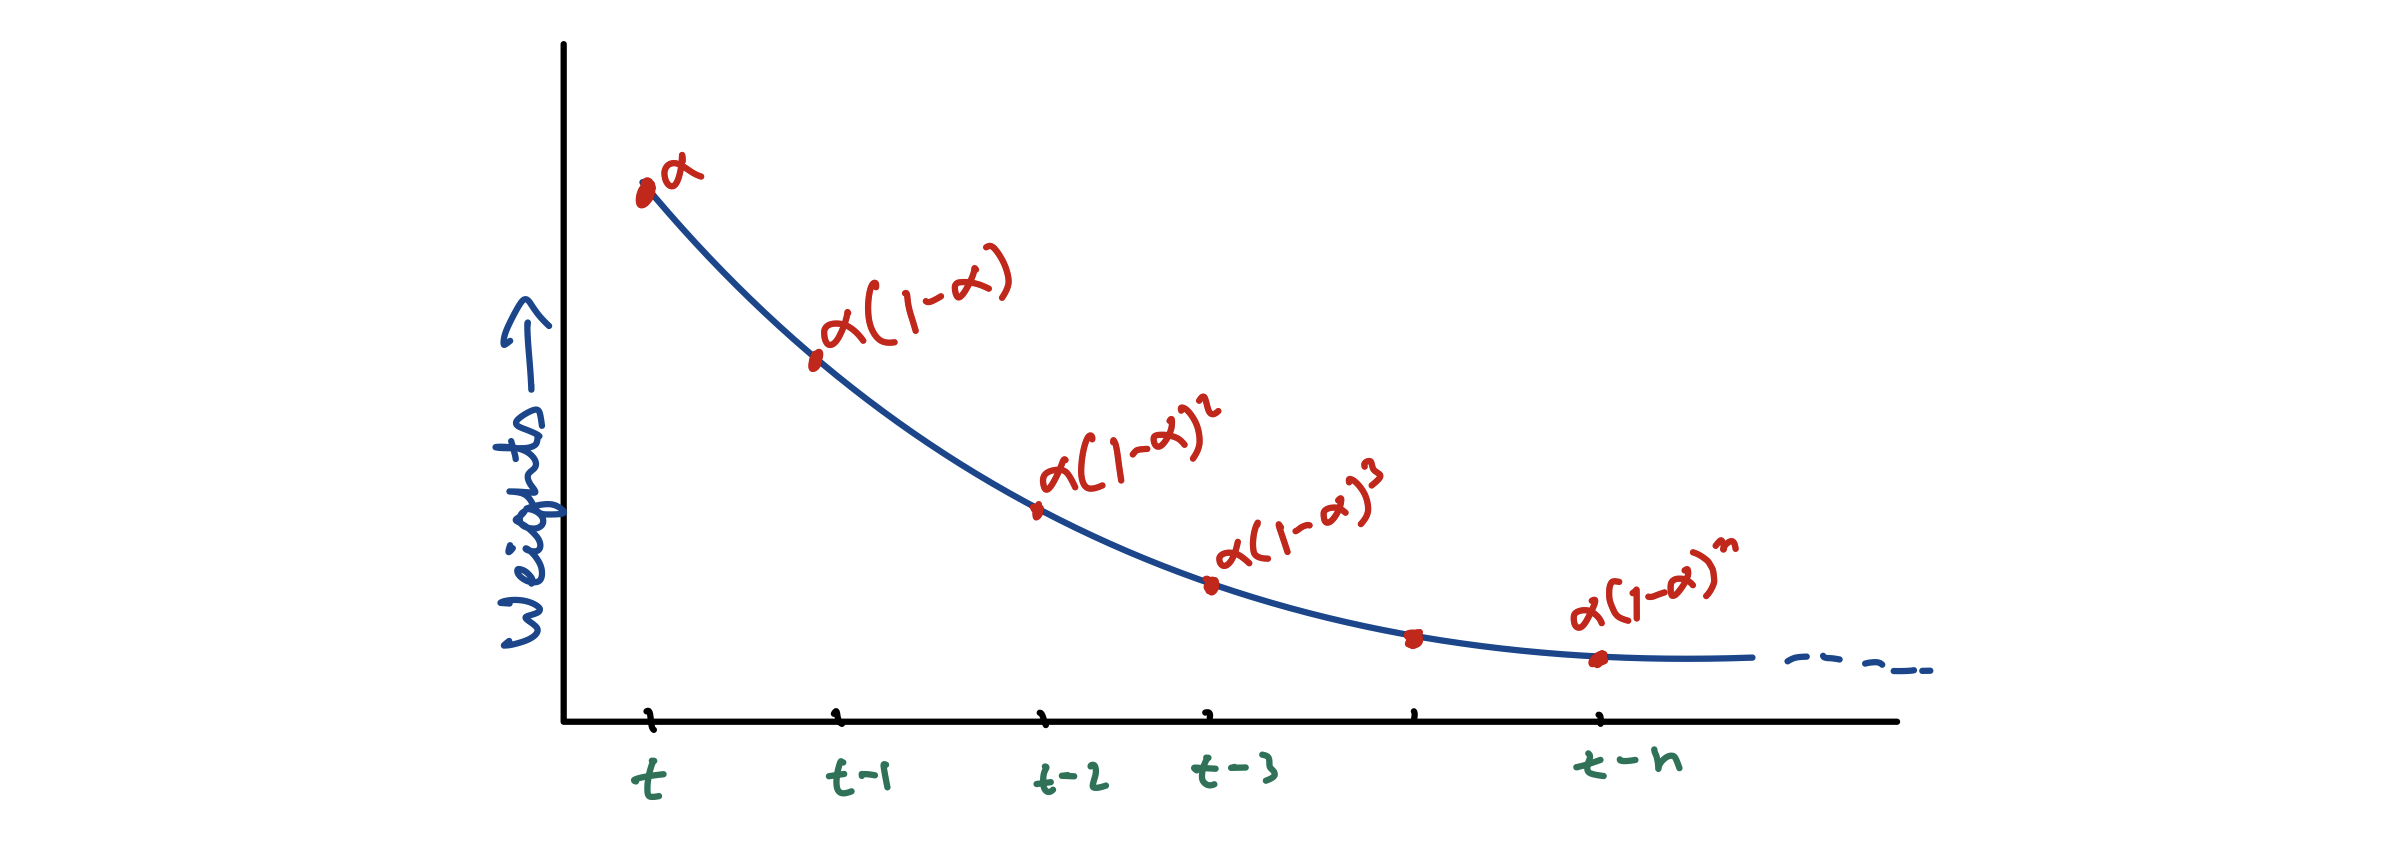

There is a necessary trade-off to be made here between learning and remembering, between being reactive and being stable. If alpha is high, the model will allocate more importance to the most recent demand observation (i.e., the model will learn fast), and it will be reactive to a change in the demand level. But it will also be sensitive to outliers and noise. On the other hand, if alpha is low, the model won’t notice a change in level rapidly, but will also not overreact to noise and outliers.

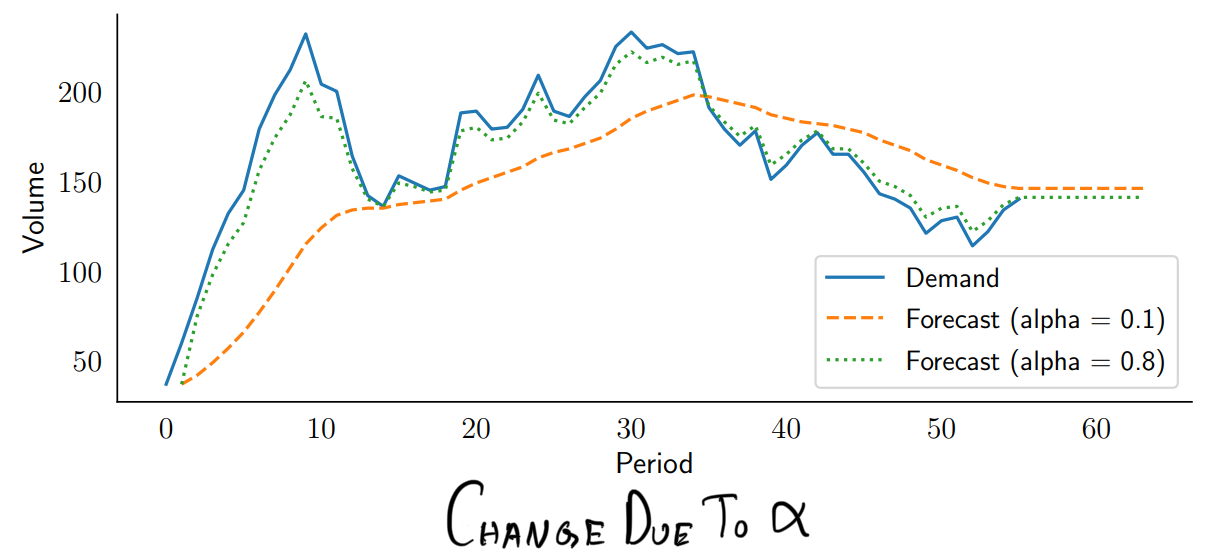

### Code implimentaion using statsmodel
Let's look into the code for the same.

We have a built-in method for this technique `SimpleExpSmoothing()`, under **statsmodels** library.

While fitting this model, we need to specify the `smoothing_level` parameter, which is the same as $\alpha$ we've been looking at.

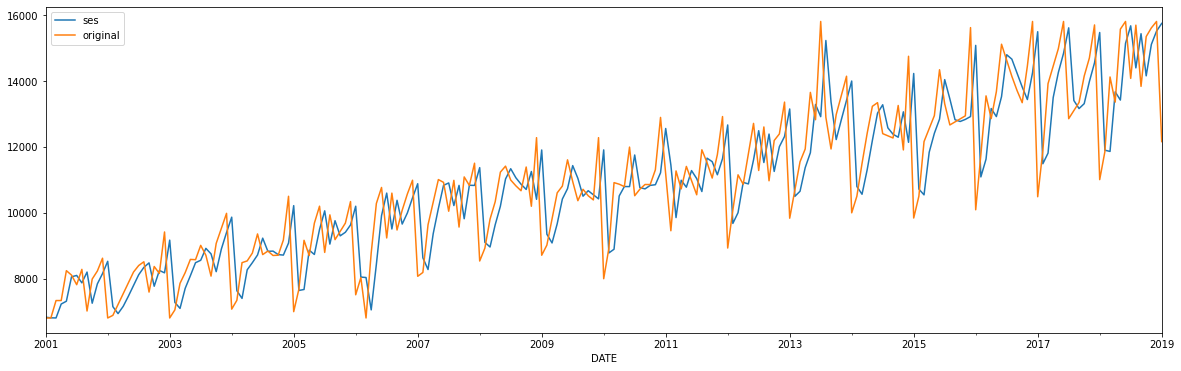

In [ ]:
model = pd.Series(sm.tsa.SimpleExpSmoothing(myntra_sales.Sales).fit(smoothing_level=0.8).fittedvalues)

model.plot(label='ses')
myntra_sales.Sales.plot(label='original')
plt.legend()


- The recommended starting point value for `smoothing_level` is $\frac{1}{2* seasonality}$
- For our case, this becomes $\frac{1}{2*12}$


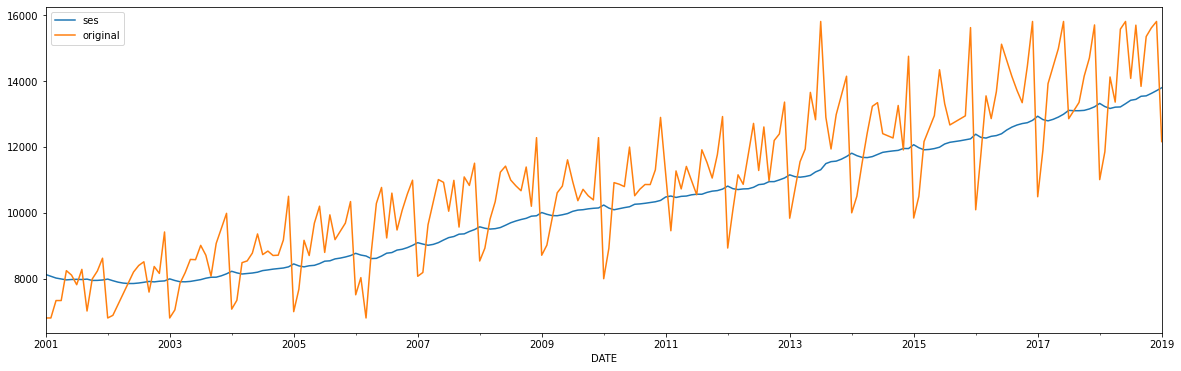

In [ ]:
model = pd.Series(sm.tsa.SimpleExpSmoothing(myntra_sales.Sales).fit(smoothing_level=1/(2*12)).fittedvalues)

model.plot(label='ses')
myntra_sales.Sales.plot(label='original')
plt.legend()

From the graph, it looks like the Simple Exponential Smoothing, got the levels right.

> **Q. How is this plot different from Moving Averages plot?**

This looks similar.

But, Unlike moving averages, it **does not have the offset** in beginning and end, because this method is initialised properly.

They fix the previous values as well.

<br>

> **Q. How can we make future forecasts from this method?**

`SimpleExpSmoothing` in statsmodels also have a `forecast()` method.

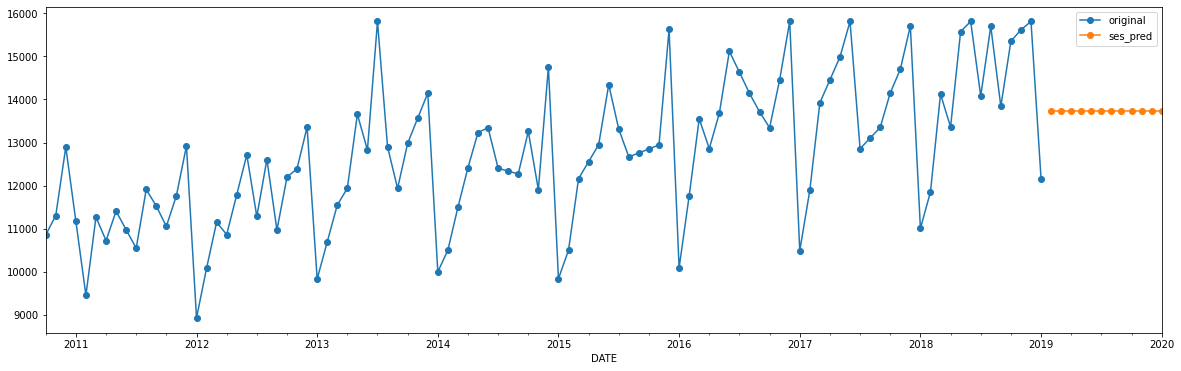

In [ ]:
model = sm.tsa.SimpleExpSmoothing(myntra_sales.Sales).fit(smoothing_level=1/(2*12))
pred = model.forecast(steps = 12)

myntra_sales.Sales.tail(100).plot(label='original', style='-o')

pred.plot(label='ses_pred', style='-o')
plt.legend()

Since it captures the correct level, for the forecast, this model would've worked well if:
- Consider our business case: We have data till January
- Suppose we are asked to forecast sales value for next month (February): $\hat{y}_{t+1}$
- Then we wait for Februaryto end, to observe the actual sales value: $y_{t+1}$
- Now, we forecast the value for March: $\hat{y}_{t+2}$


MAE : 1621.347
RMSE : 1830.599
MAPE: 0.109


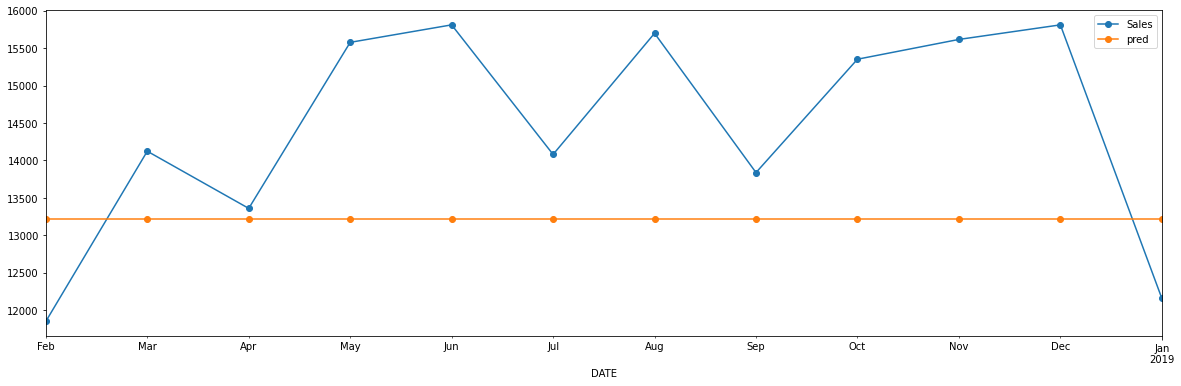

In [ ]:
model = sm.tsa.SimpleExpSmoothing(train_x.Sales).fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Drawbacks
This simple exponential smoothing model is slightly smarter than the moving average model thanks to its smarter weighting of the historical demand observation. But it has many limitations:

- It does not project trends.
- It does not recognize any seasonal pattern.

# Double Exponential smoothing (Holt's method)

Double Exponential Smoothing is an extension to Exponential Smoothing that explicitly adds support for trends in the univariate time series.

Since we want the trend of entire time series, in order to incorporate them, we will have to provide weights to the trend value also.

Naturally, this will also form a exponentially decaying series.

Hence this is called **Double Exponential smoothing (aka Holt's method)**

In addition to the alpha parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend called beta (b).

As with alpha, beta can be between 0 and 1, inclusive. Higher values place more weight on recent observations, allowing the trend component to react more quickly to changes in the trend.



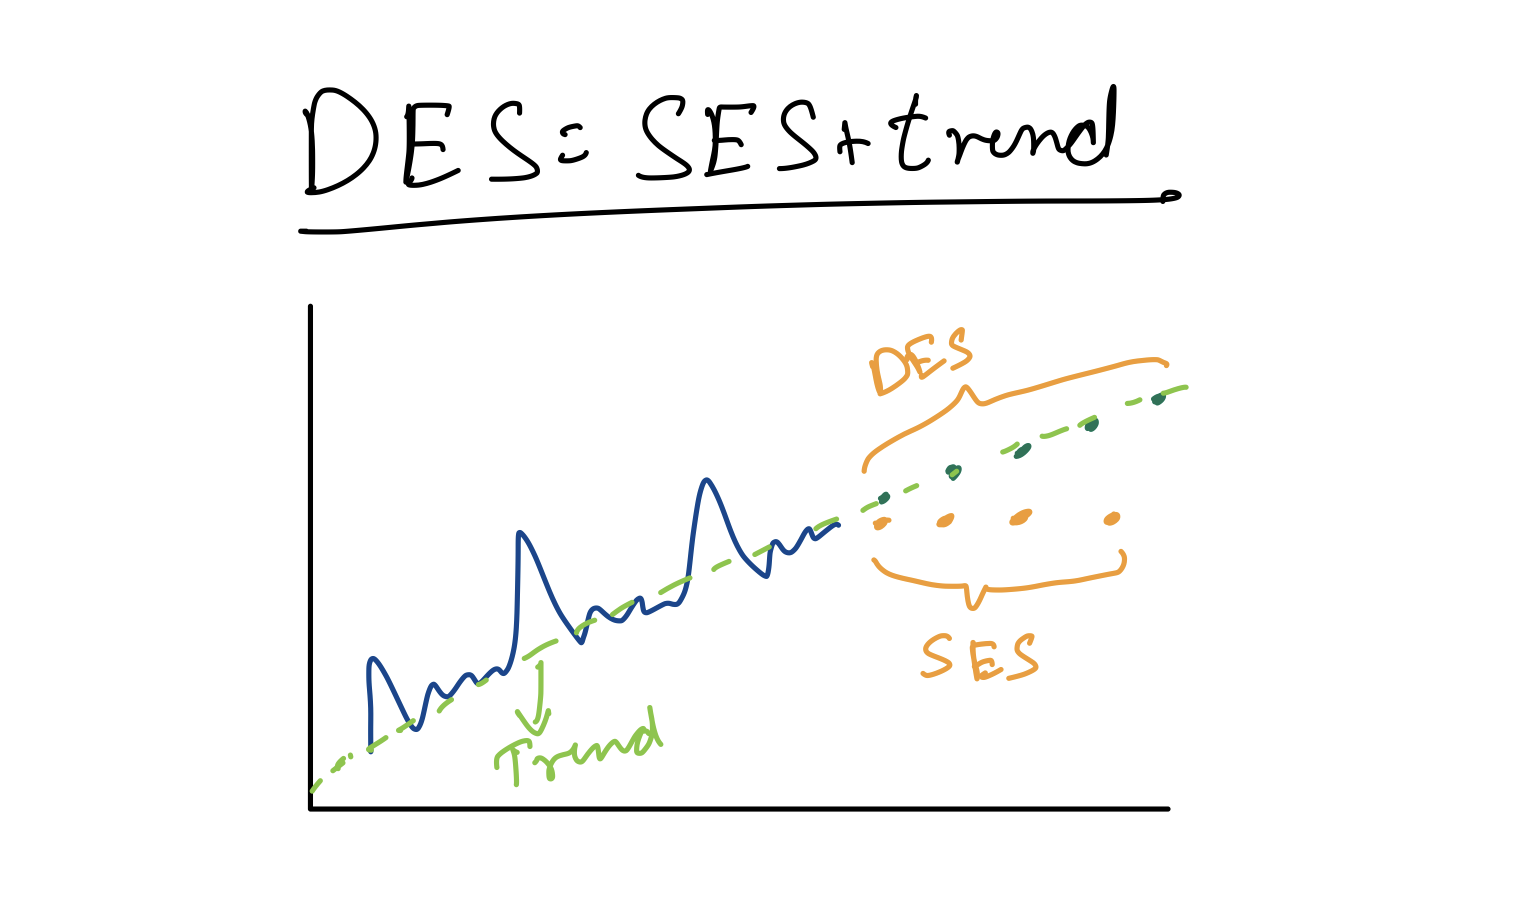

- Should be used on the time series that have no seasonality and have single variable (feature)

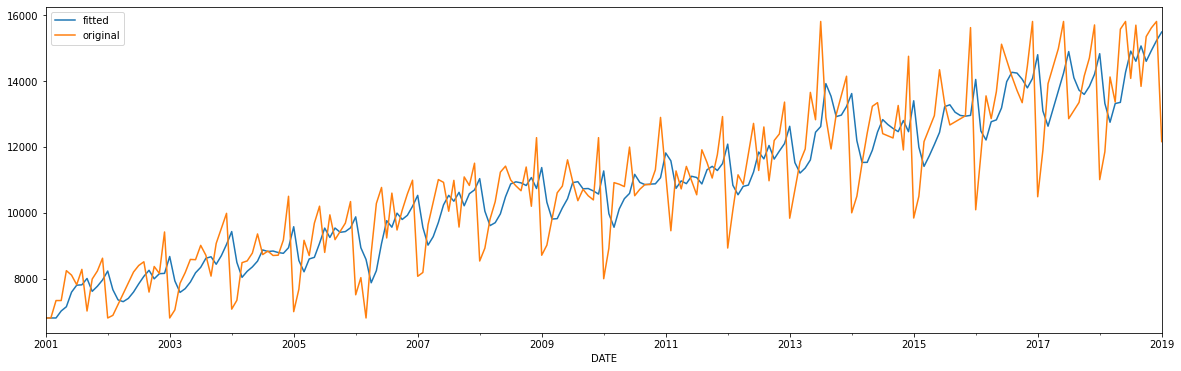

In [ ]:
model = sm.tsa.ExponentialSmoothing(myntra_sales.Sales, trend='add').fit(smoothing_level=0.4)
model.fittedvalues.plot(label='fitted')
myntra_sales.Sales.plot(label='original')
plt.legend()

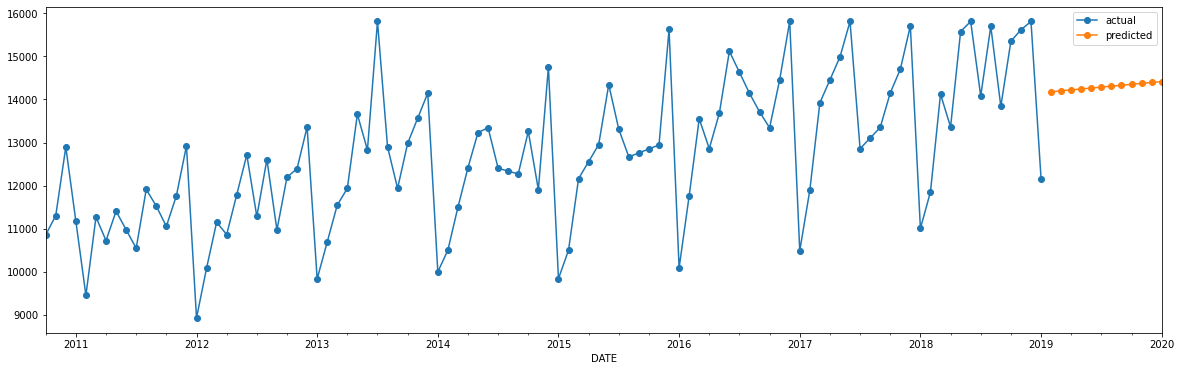

In [ ]:
pred = model.forecast(steps = 12)
myntra_sales.Sales.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

From the graph you can see that, the trend of the series is also obtained along with the level of values.

<br>



While we're at it, let's check the performance of Holt's method model also, by using train and test sets.

MAE : 1167.938
RMSE : 1356.131
MAPE: 0.083


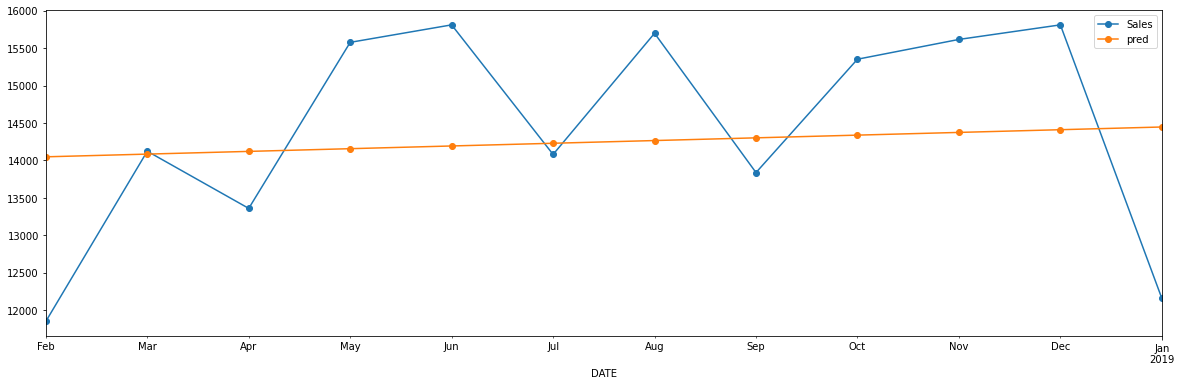

In [ ]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

# Triple Exponential smoothing (aka Holt-Winters Method)

Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series.

This method is sometimes called Holt-Winters Exponential Smoothing, named for two contributors to the method: Charles Holt and Peter Winters.

In addition to the alpha and beta smoothing factors, a new parameter is added called gamma (g) that controls the influence on the seasonal component.

- This method adds in the gamma (γ) parameter to account for the seasonal component. For this method, you must specify the period for the seasonal cycle. For example, these lengths include the following: weekly (7), monthly (12), or quarterly (4).

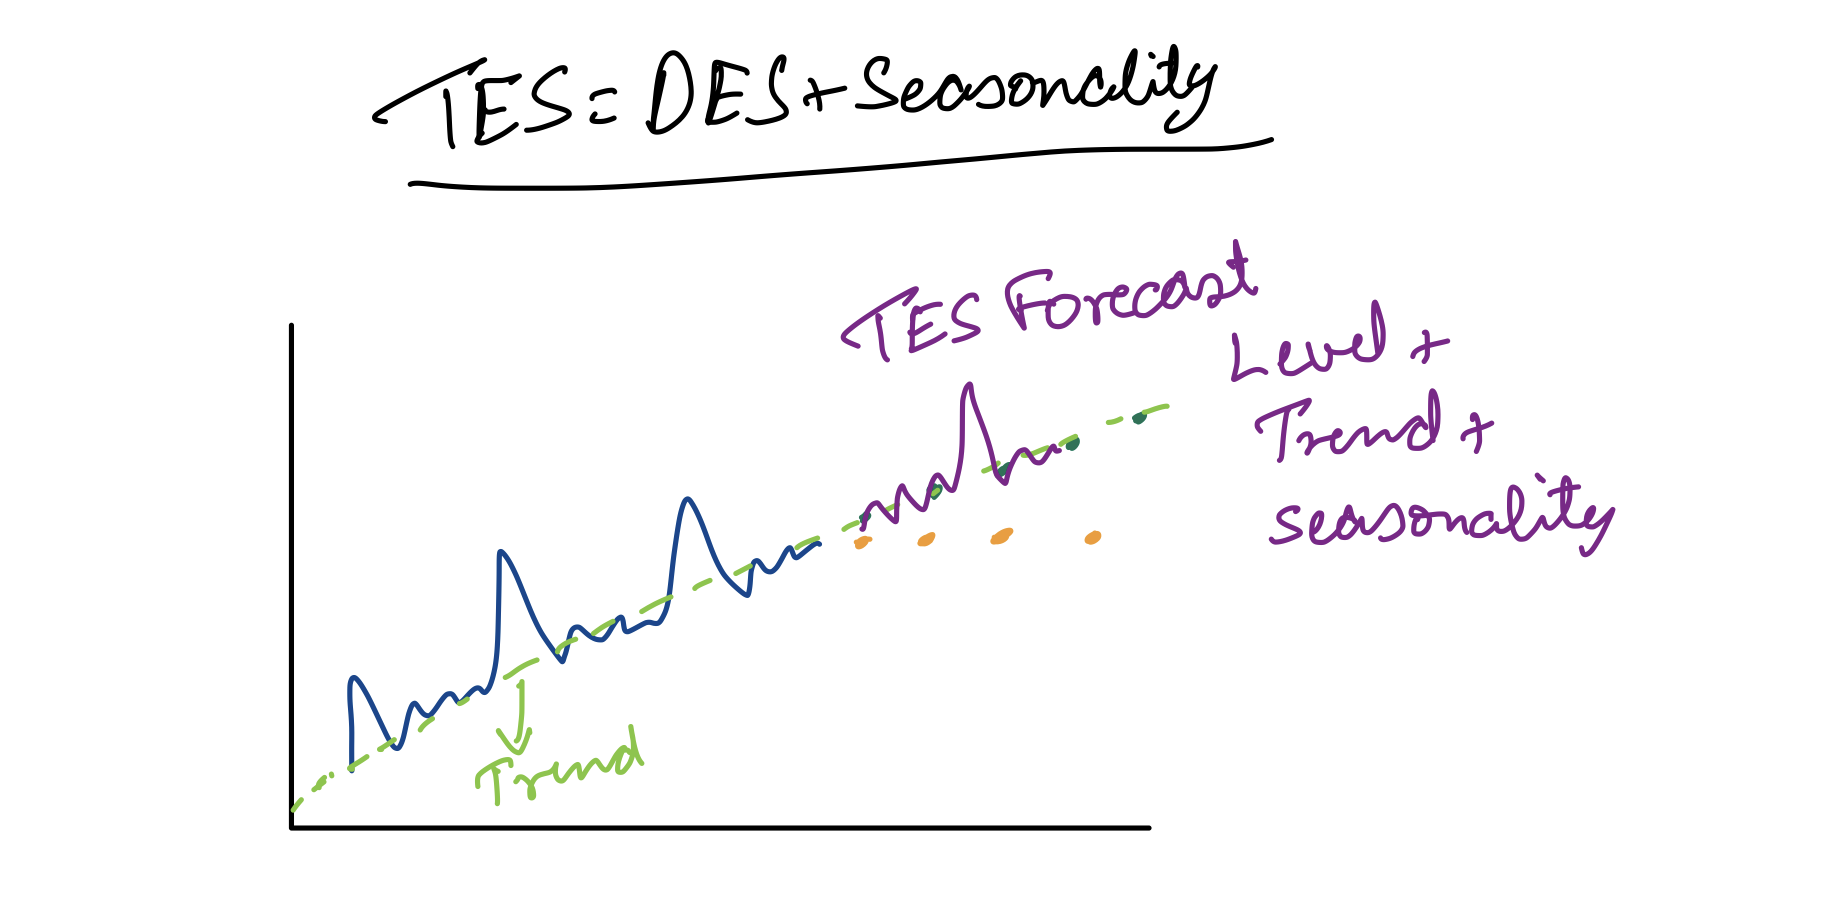

This method;

- Can handle level, trend and seasonality
- In addition to SES, the trend and seasonality is also taken into account
- Is the most improved smoothing method
- Forecasts dynamically consider level, trend and seasonality
- Should be used with the time series that have trend and/or seasonality and single variable (feature)

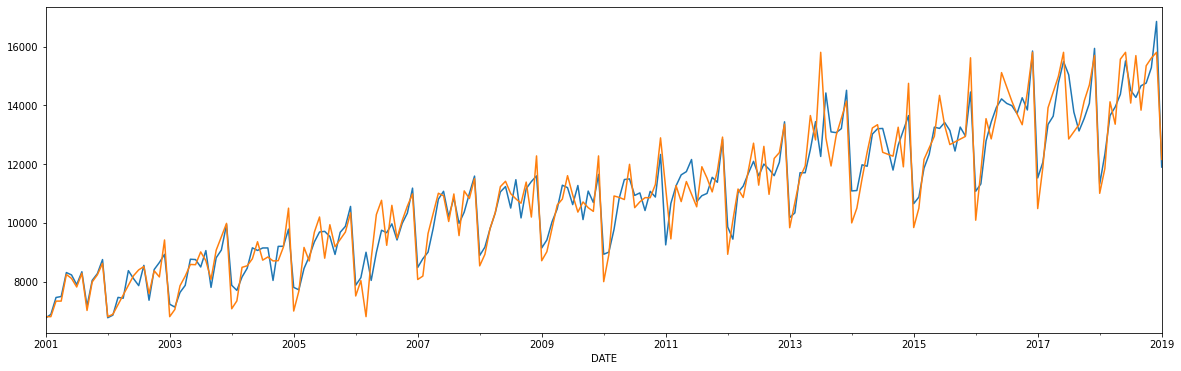

In [ ]:
model = sm.tsa.ExponentialSmoothing(myntra_sales.Sales, trend='add', seasonal='add').fit(smoothing_level=0.4)
model.fittedvalues.plot()
myntra_sales.Sales.plot()

As you can see, this captures more information than Double Exponential smoothing.

This was expected as it has more degrees of freedom to capture more data.

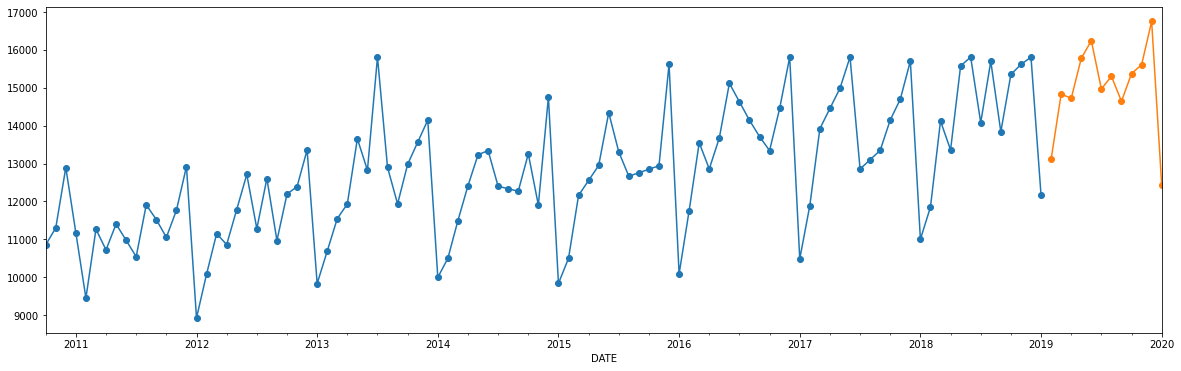

In [ ]:
pred = model.forecast(steps = 12)
myntra_sales.Sales.tail(100).plot(style='-o')
pred.plot(style='-o')

From the plot we can see that our forecasts now look promising upon incorporating the trend and seasonality components.

<br>



While we're at it, let's check the performance of Holt-Winter's method model also, by using train and test sets.

MAE : 588.607
RMSE : 680.844
MAPE: 0.04


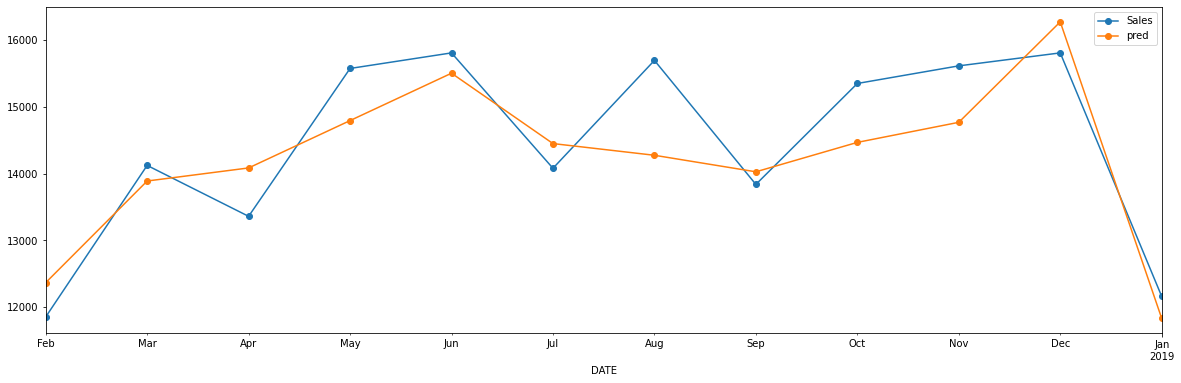

In [ ]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='add').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

In this plot we can clearly see that this model is having a better performance.

To back this, we can see that even MAPE error is only 4% now.

Also, the MAE and RMSE values have gone down a lot, from where we started.

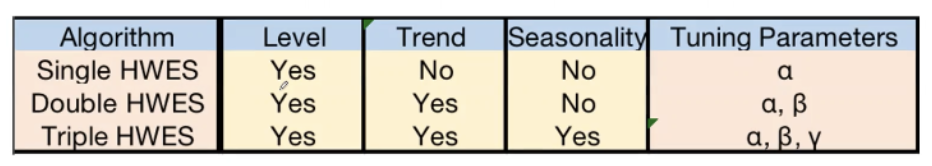

# Stationarity

A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

- So far, we've been dealing with non-stationary time series. But in order to use certain forecasting methods (that we will see shortly), we need to the series to be stationary.


Being stationary means that, parameters (like mean, variance, amplitude, frequency) of the models should not be dependent on time.

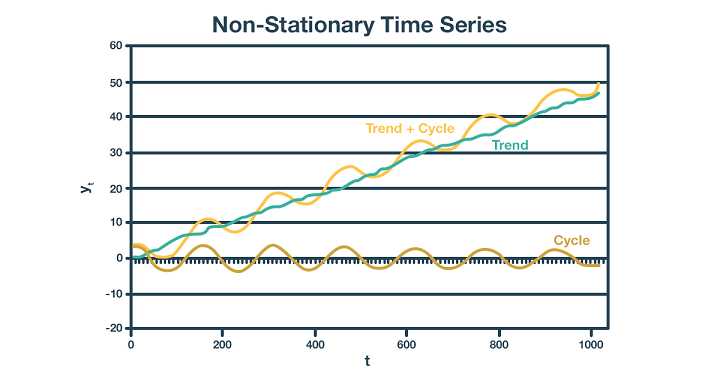




<br>

> **Q. Which of the following time series is stationary?**

![picture](https://drive.google.com/uc?export=view&id=1pN4X8e7xNcQvnpgCmGgl7gQZURcD3kRy)

- `a, c, e, f, :` Not stationary
 - either have a trend, or
 - mean changing with time.
- `d, h:` Not stationary
 - Seasonality
- `i:` Not stationary
 - Has a trend
 - Variance is also not stable
 - Season
- `b:`
 Stationary
 - There is 1 outlier
 - Can't say anything about mean; seems to be just noise.
- `g:` Stationary
  - Predicting this is dicey, so we assume it to be stationary, and try building model, and seeing if it performs.
  - Looks like a cyclic time series. But these are not at regular intervals.
  - So, even though there  is some seasonality, it can't be predicted.

Categorizing a time series by just looking at it can be a little subjective.

For example, somebody may argue that `plot b` is non-stationary, as it looks like there may be some seasonality there.

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

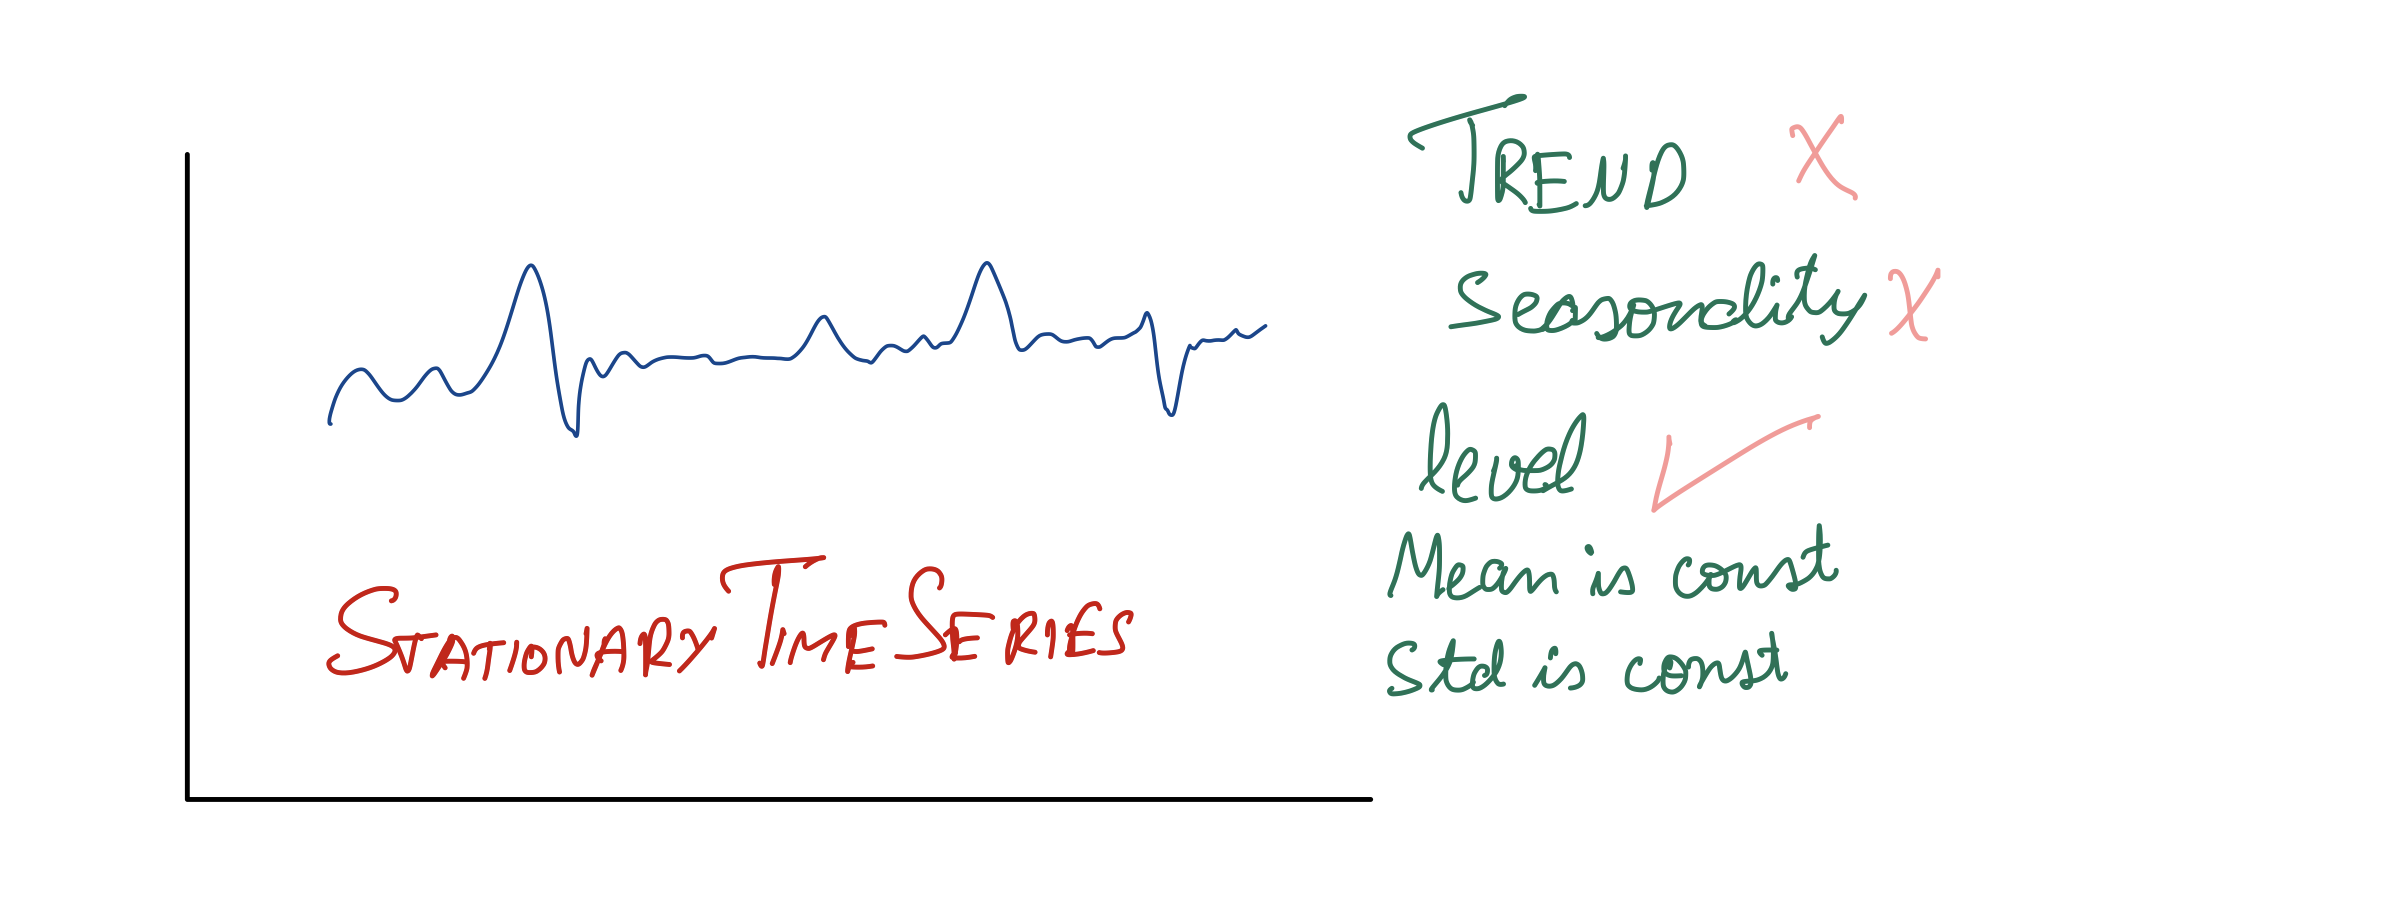

### Dickey-Fuller Test


There is a **statistical** method called **Dickey-Fuller test**, designed for testing for stationarity. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.


It fits an auto regressive model, checks if it worked or not. If it did, then that means it was a stationary time series.

There is a complicated mechanism to it. We don't need to know how it works. Just need to be aware of this test, as it can be handy.

<br>


We can find this as a built in function under **statmodels** library as `sm.tsa.stattools.adfuller()`.

<br>

> **Q. How do we interpret the result of Dickey-Fuller test?**

This test returns the **pvalue**.

In order for a time series to be stationary, the **pvalue** should be less than 0.05

Let's do the test for our timeseries

In [ ]:
sm.tsa.stattools.adfuller(myntra_sales.Sales)[1]

0.9789233920172066

The pvalue of the timeseries is very high, 0.98 approx.

So we can conclude that our time series is **not stationary**.

This makes sense because our time series has both, trend and seasonality.

Let's define a simple function to know if the plot is stationary or not.

In [ ]:
def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   if pvalue <= 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')


In [ ]:
adf_test(myntra_sales.Sales)

Sequence is not stationary


### Making series stationary

As per basic intuition, if we remove trend and seasonality, from our time series, it should become stationary.

If it's still not stationary, then maybe there's still some seasonality or trend component left in the series.

Ideally, trend gets removed in one step. However seasonality can take multiple steps to be removed.


---

### De-trending the series

A trend is often easily visualized as a line through the observations.
Perhaps the simplest method to detrend a time series is by differencing.

Specifically, a new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.


A detrend involves removing the effects of trend from a data set to show only the differences in values from the trend; it allows cyclical and other patterns to be identified.

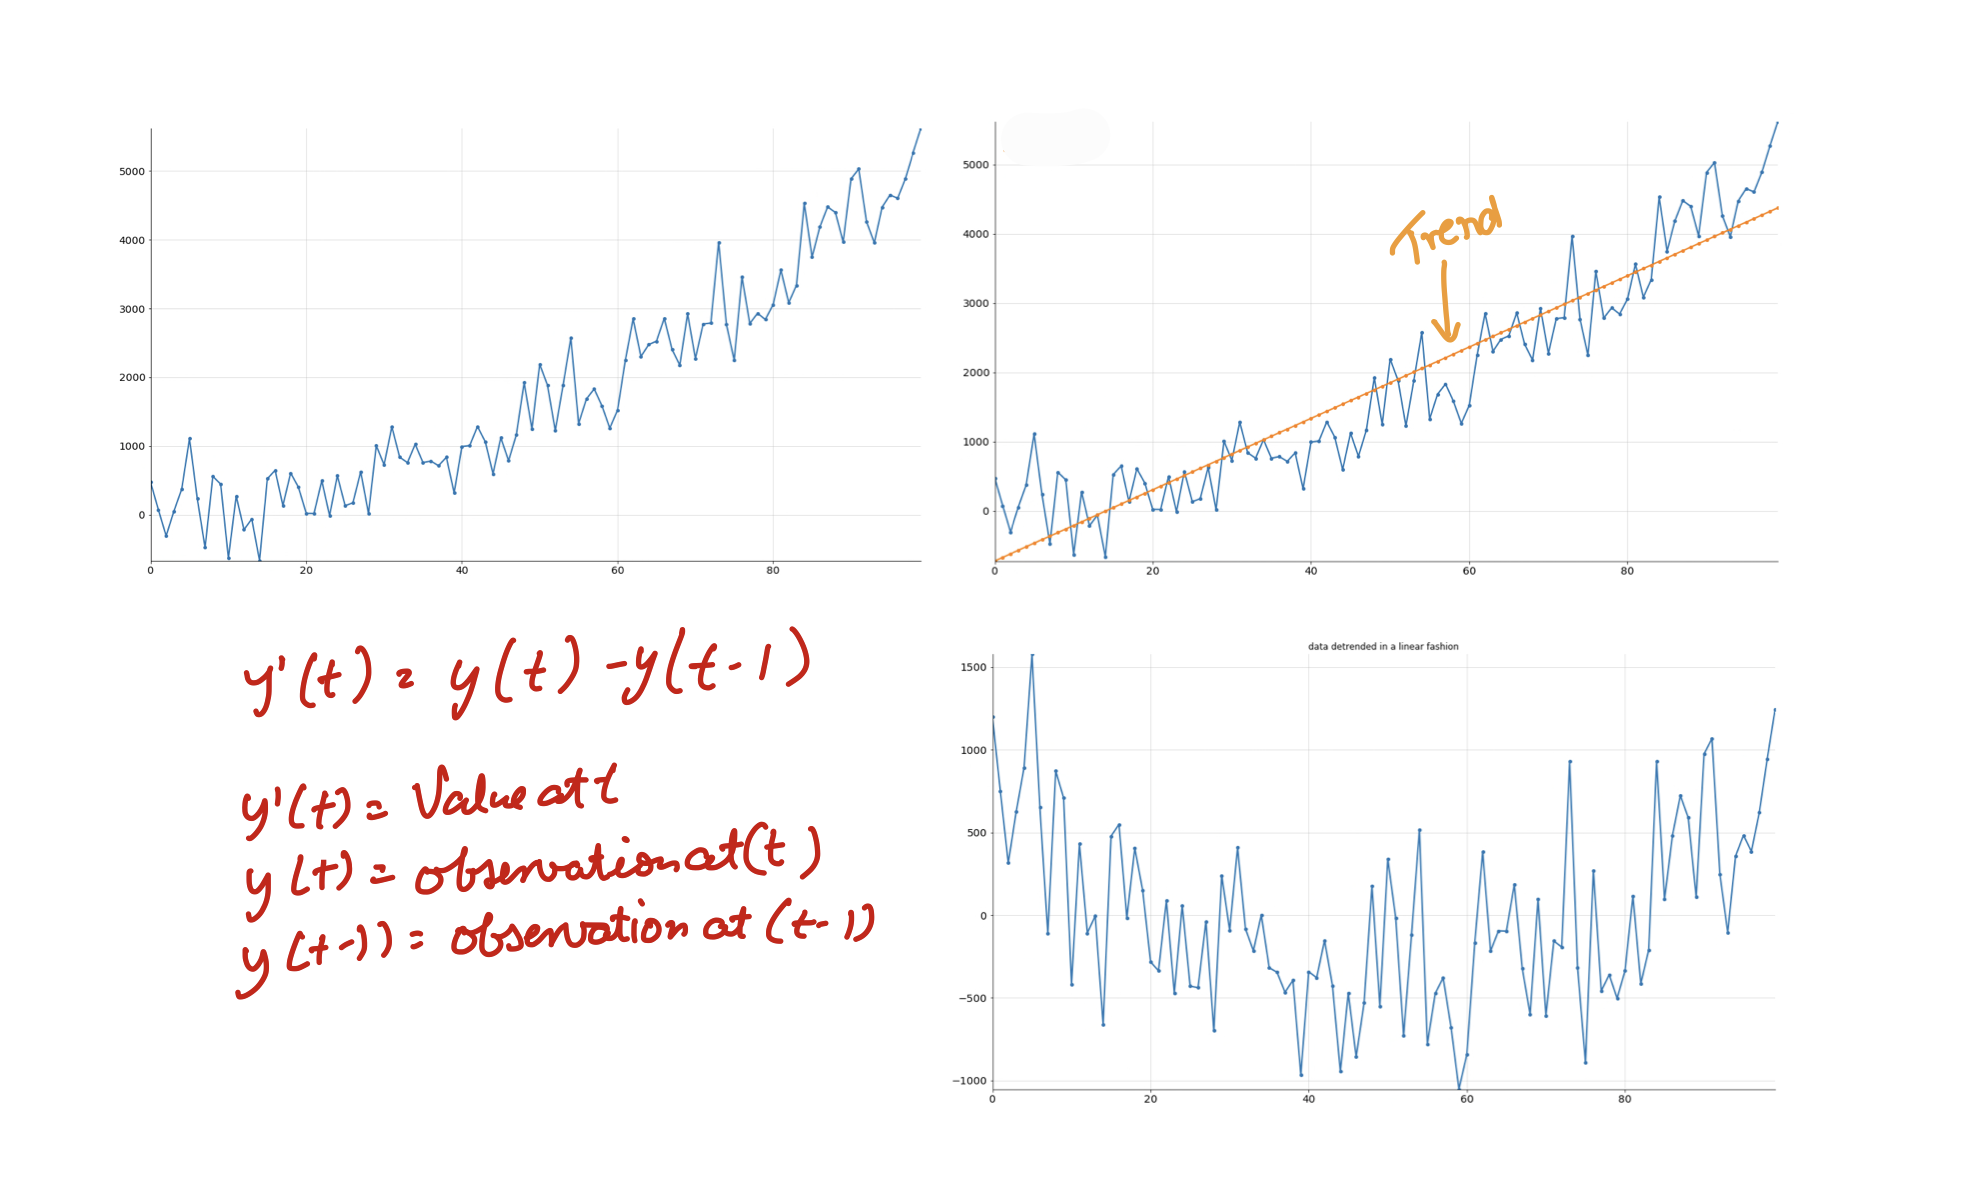

If the time series has a non-linear trend, then we'll have to differentiate it multiple times, in order to finally achieve a stationary series.

Note:

If the trend is an exponential function, then we'll not be able to convert it into stationary.
This is a very rare cases.
Some exponential functions can be approximated by polynomial. In that case, we differentiate this polynomial to obtain a stationary time series.

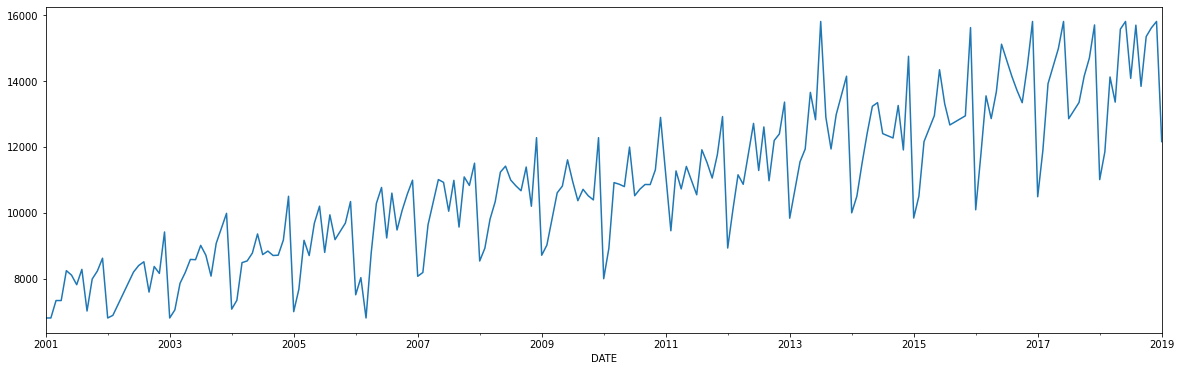

In [ ]:
myntra_sales.Sales.plot()


We use the `diff()` method of **pandas**.

This method calculates the difference of a Dataframe element compared with another element in the Dataframe (default is element in previous row, as the default value is 1).

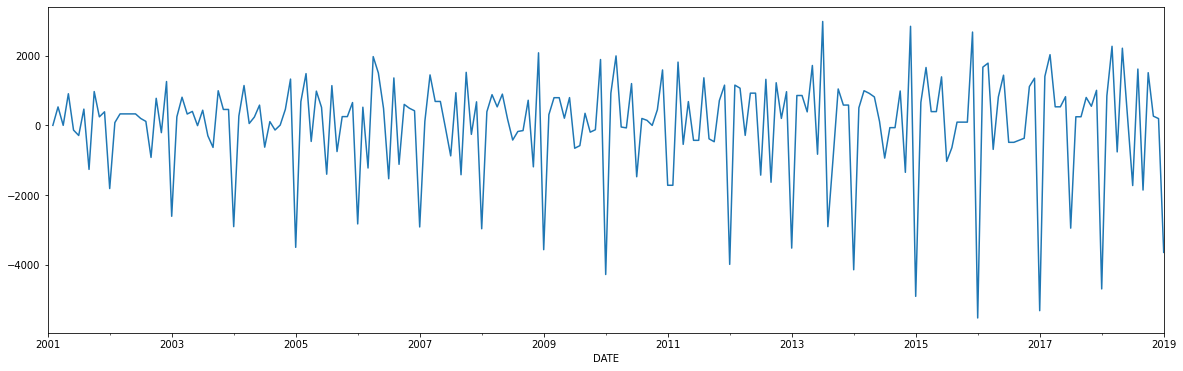

In [ ]:
detrend = myntra_sales.Sales.diff()
detrend.plot()

As you can see, here the series has been detrended.

Let's perform the Dicker-Fuller test to cross check.

In [ ]:
adf_test(detrend.dropna())

Sequence is stationary


### De-seasonalising

The model of seasonality can be removed from the time series. This process is called Seasonal Adjustment, or Deseasonalizing.

Here also we can use differencing, but instead of subtracting from the last point, we need to take a difference from the last mth point, where m is the period of seasonality of series.

###**$Δy = y_t - y_{t-m}$**

This is called m-differencing.

If there is a seasonal component at the level of one week, then we can remove it on an observation today by subtracting the value from last week.

In our case, since data is monthly, our m=12

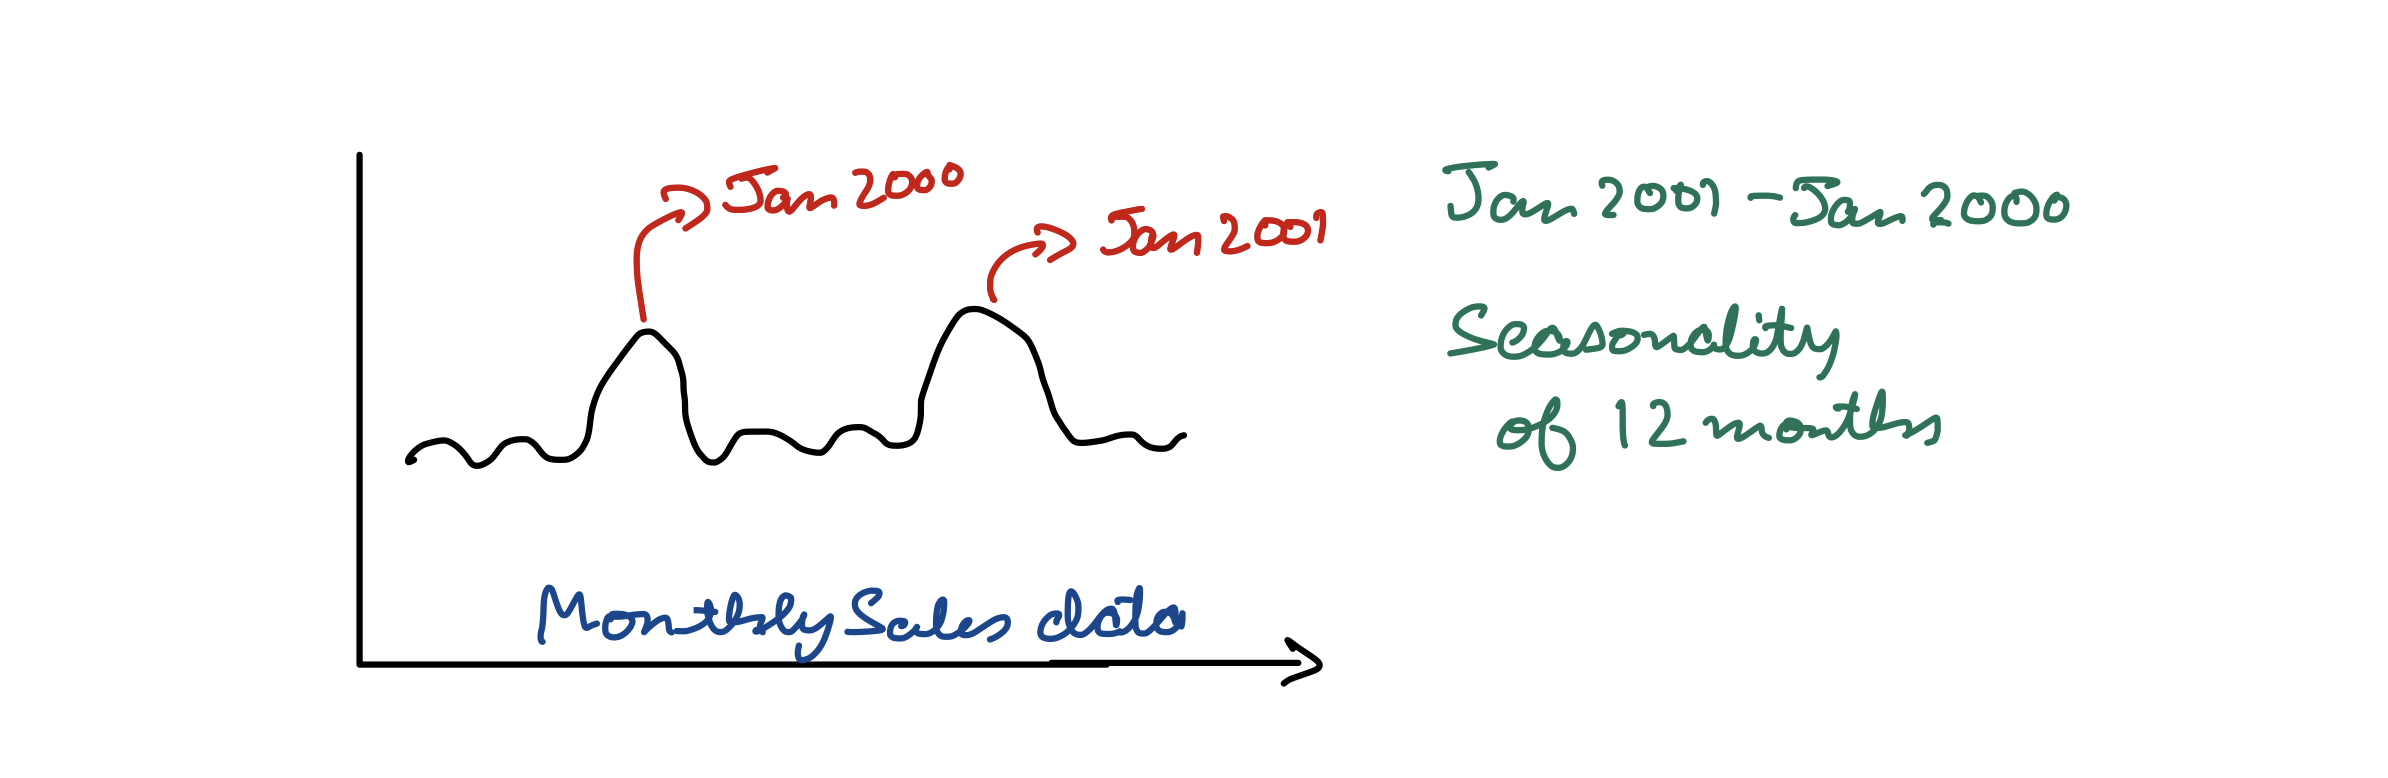

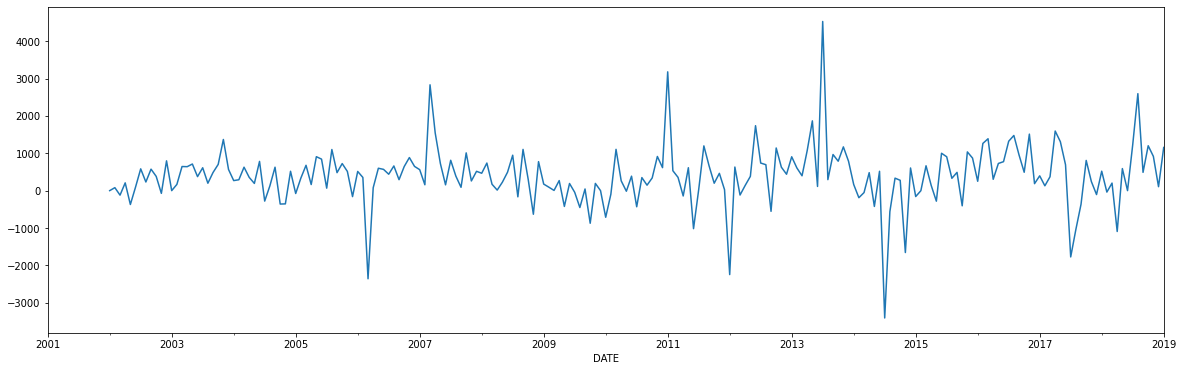

In [ ]:
deseas = myntra_sales.Sales.diff(12)
deseas.plot()

Here, as you can see we can still see very small trace of trend still.

Let's try detrending AND deseasonalising at once.

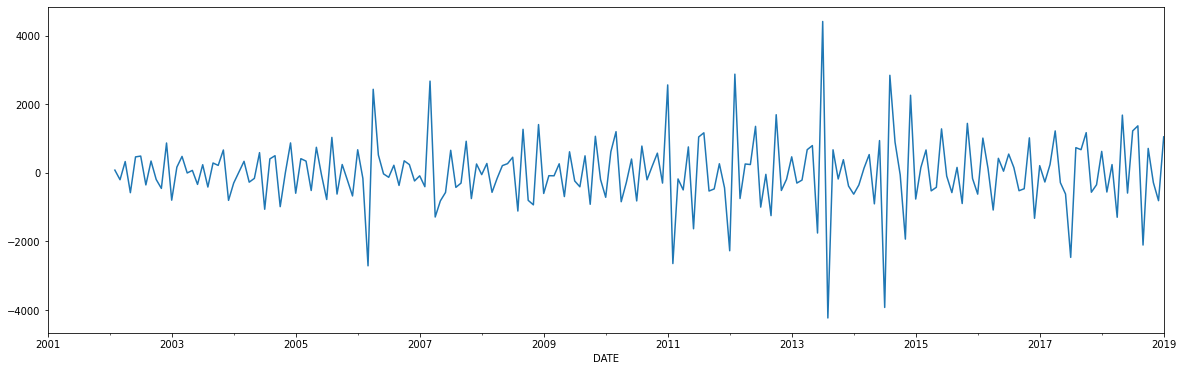

In [ ]:
stationary = myntra_sales.Sales.diff(1).diff(12)
stationary.plot()

As you can see, we've obtained a stationary time series.

**We have removed both trend and seasonality from the time series**


<br>

> **Here, we could visually see in the plot that value of m seems to be 12, but in other cases, it might not be obvious.**
- So we need to find the optimal value of m.


# AutoCorrelation and PartialAutoCorrelation

Correlation analysis is an important step in the Exploratory Data Analysis of time series forecasting. The autocorrelation analysis helps detect patterns and check for randomness.

> To find the value of m, we analyse the series and select the value based on that, but that may not be clear, so we use correlation to find the best value of m

Due to the continuous and chronologically ordered nature of time series data, there is a likelihood that there will be some degree of correlation between the series observations.

**the correlation is a snapshot measure of global synchrony**

- Analyzing the correlation between a series and its lags can help us find the value of m



Given our current time series  𝑦(𝑡) ,
- What if we consider another time series where we introduce a lag of 1, i.e. shift the series by 1 unit of time:  𝑦1(𝑡)
- We can then find the correlation coefficient between these two time series:  𝑦(𝑡)  and  𝑦1(𝑡)
- Similarly, we find the correlation between the original time series  𝑦(𝑡)  and a time series lagged by i units:  𝑦𝑖(𝑡) , where  𝑖=1,2,3,...  (i represents lag)
- In doing so, we would find a value of  𝑖 , where the lagged time series rougly overlaps over the original series.

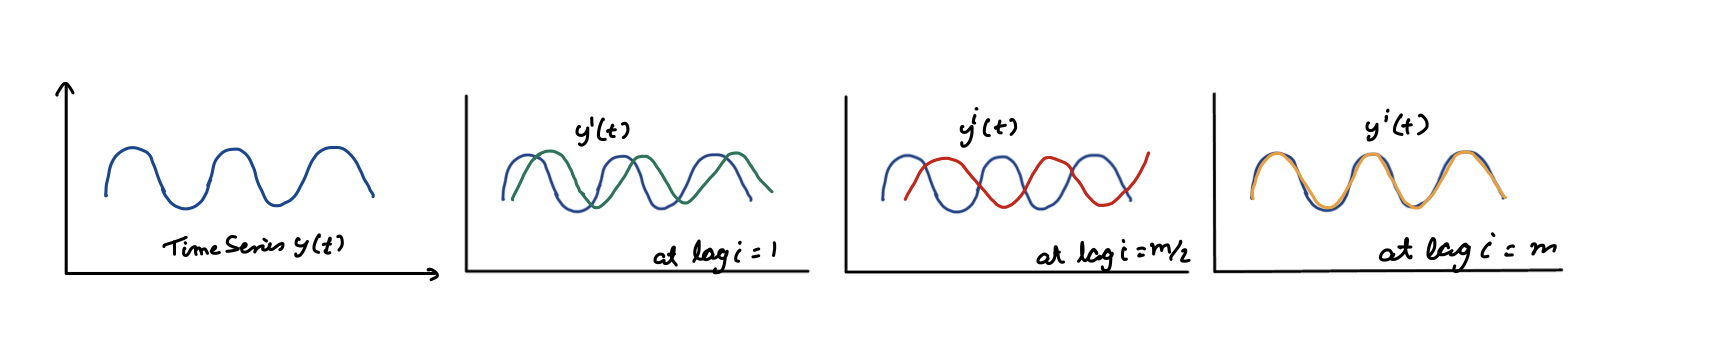

What will the plot between correlation coefficient and lag (i) look like?

- At  𝑖=𝑚 , we would get a correlation value very close to 1.

- At  𝑖=𝑚/2 , as the value of lagged time series increases, the value of original series decreases, giving us a strong correlation

- For a value of  𝑖  that is even close to  𝑚 , though the correlation value would not be as strong as at  𝑚 , but it would be relatively strong.

## ACF

Autocorrelation is the correlation between a time series with a lagged version of itself. The ACF starts at a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

 Autocorrelation is similar to the correlation between two different time series in theory, but it uses the same time series twice: once in its original form and again with one or more time periods added.

**There is a correlation with each latency**

The autocorrelation function (ACF) evaluates the correlation between observations in a time series over a given range of lags. Corr(yt,yt-k), k=1,2,…. gives the ACF for the time series y. We generally use graphs to demonstrate this function.


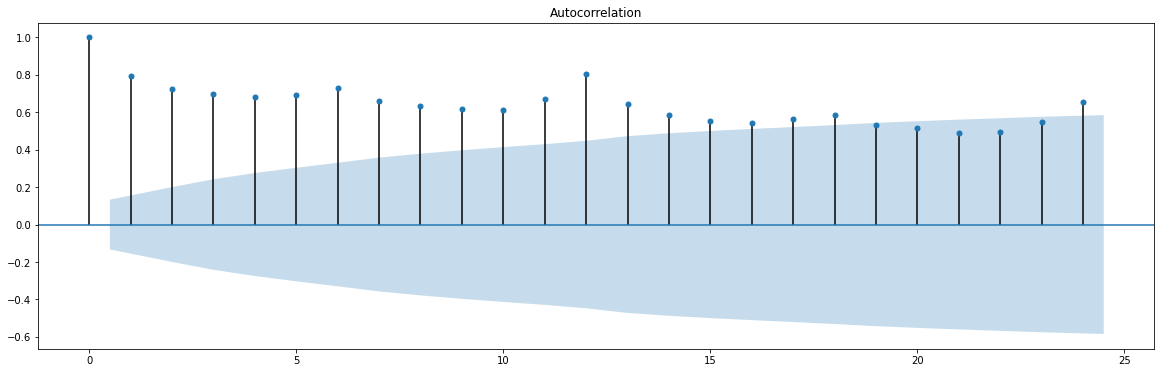

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(myntra_sales.Sales);

- From the plot we can see that the correlation value increases at every six months which we couldn't recognise just by looking at the actual data plot. So there is also a **6 month seasonality**.

- It peaks every 12th month.

<br>

For this time series, correlations are quite high.

Let's see the ACF plot for the **de-trended series**. Because intuitively also, finding seasonalities on a de-trended series would be better.

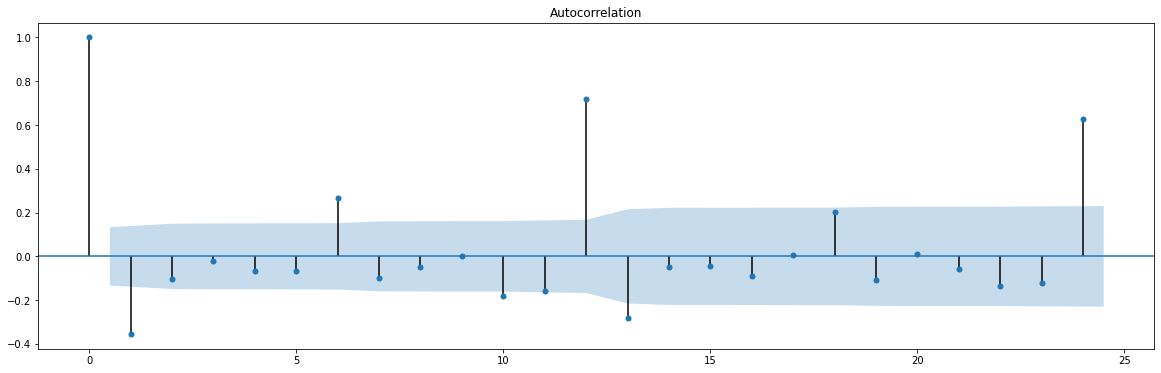

In [ ]:
plot_acf(myntra_sales.Sales.diff().dropna());

- After de-trending the series, we can see the correlation of the series is high at period of 12 and 6. This indicates there is some seasonality.

- Besides that, the correlation values are random and small.

- On removing the trend, we're able to capture negative correlations between the original series and lagged series with more ease.

- As per business logic, we can expect to see a dip right after peak/holdiday season.

Let's do the de-seasoning, in order to get a **stationary series**, and see the ACF for it.

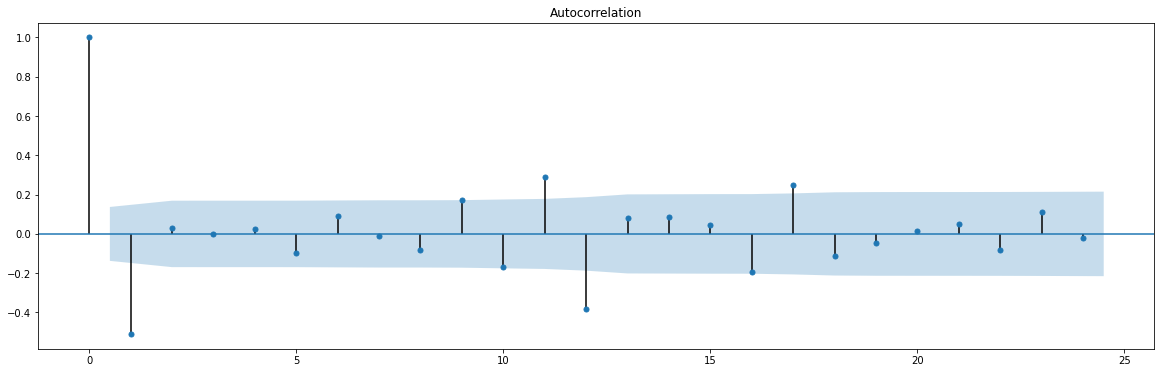

In [ ]:
plot_acf(myntra_sales.Sales.diff().diff(12).dropna());

Here we can see the significant decrease in the correlation values , that means seasonality is reduced



## PACF

The partial autocorrelation function, like the ACF, indicates only the association between two data that the shorter lags between those observations do not explain. The partial autocorrelation for lag 3 is, for example, merely the correlation that lags 1 and 2 do not explain. In other words, the partial correlation for each lag is the unique correlation between the two observations after the intermediate correlations have been removed.

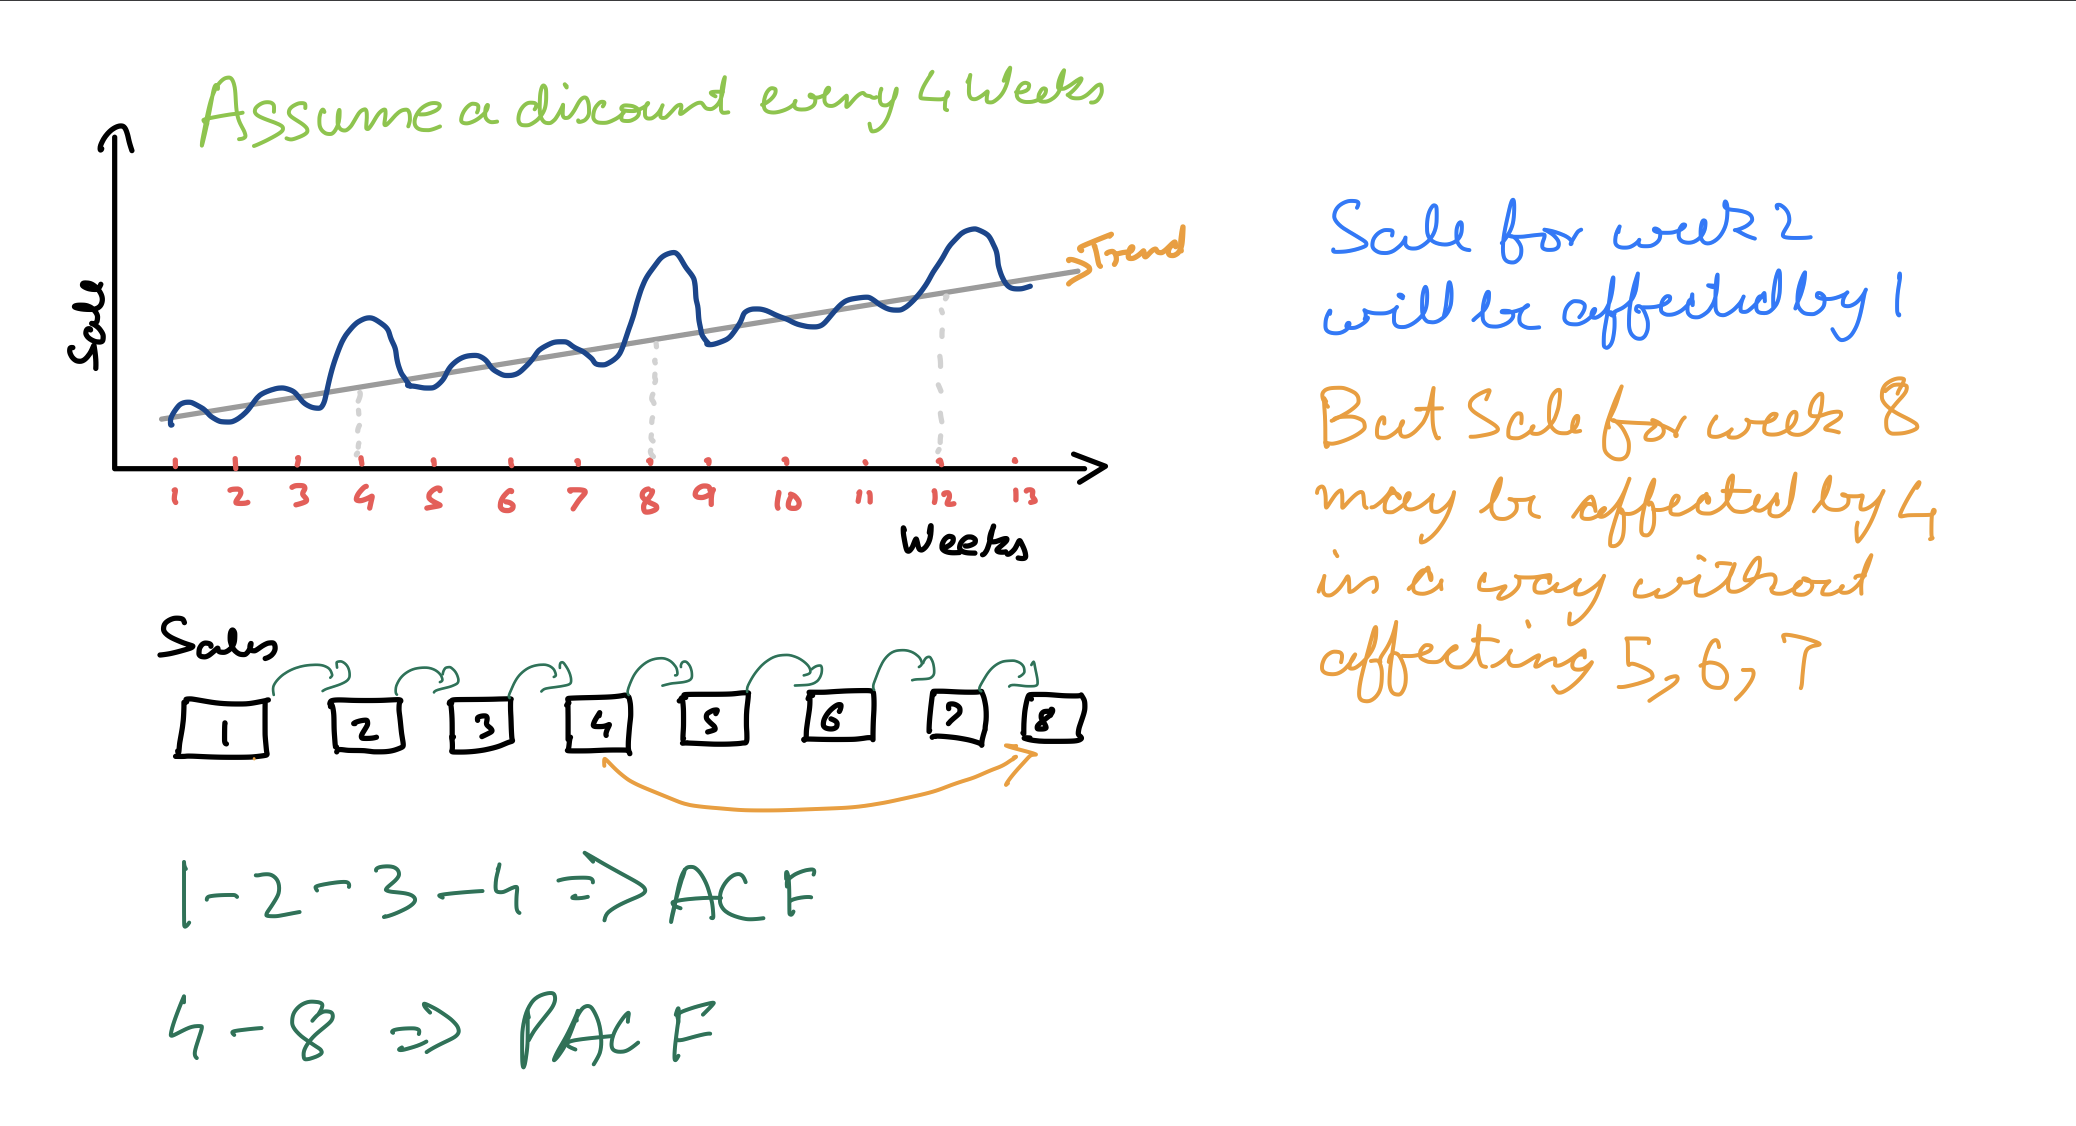

- The partial correlation for each lag is the unique correlation between the two observations after the intermediate correlations have been removed.

This is also known as Conditional AutoCorrelation.

Let's have a look at the Partial Auto Correlatio Plot (PACF)

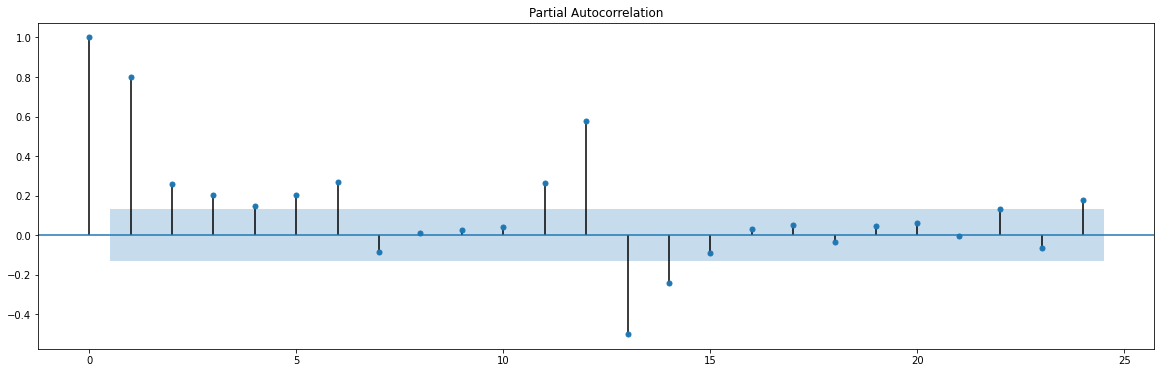

In [ ]:
plot_pacf(myntra_sales.Sales);

This PACF makes the correlation clear.

**Interpretation:-**
- Value at $i=1$ is high: This means that given the values of time series $y(t)$, we can compute the values of a time series with lag 1, $y^1(t)$ with ease.
- There is a high value at $i=12$
 - This means that even if we ignore the information given by all the time series with $lags=1, 2, ..., 11$, the information carried in time series $y^{12}(t)$ alone is very high.
 - This shows strong seasonality

<br>


**Observations:-**
- Autocorrelation plot is as expected; series does not seem to be stationary
- Diff series is indeed stationary. Also, seasonality can be seen using this plot.
- De-seasoned series does not have any seasonality or trend.
- PACF suggests that only the first lag and 12th lag is strong.

> **NOTE:-**
- **We calculate PACF on the original time series, whereas ACF is plotted on stationary time series.**

#### Quiz-2

```console
If we have a sine wave, plotted in degrees, with time period 360 degree, and 1 lag represents 1 degree, at what lag will the autocorrelation be
minimum?

1. 0
2. 45
3. 90
4. 180
```

Ans: 180 degree, corr = -1, at 90 it would be 0.

## Correlation Vs Causation

A variable x  may be useful for forecasting a variable  y, but that does not mean x is causing y.

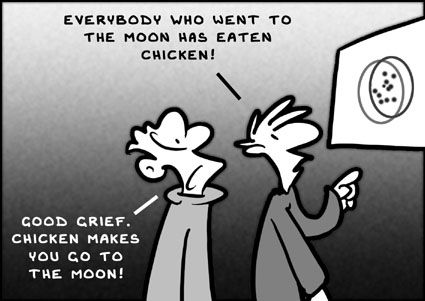

Correlations are useful for forecasting, even when there is no causal relationship between the two variables.

For example,
- It is possible to forecast if it will rain in the afternoon by observing the number of cyclists on the road in the morning.
- When there are fewer cyclists than usual, it is more likely to rain later in the day.

This model can give reasonable forecasts, not because cyclists prevent rain, but because people are more likely to cycle when there is less or no chance of rain.

In this case, there is a causal relationship, but in the opposite direction to our forecasting model.

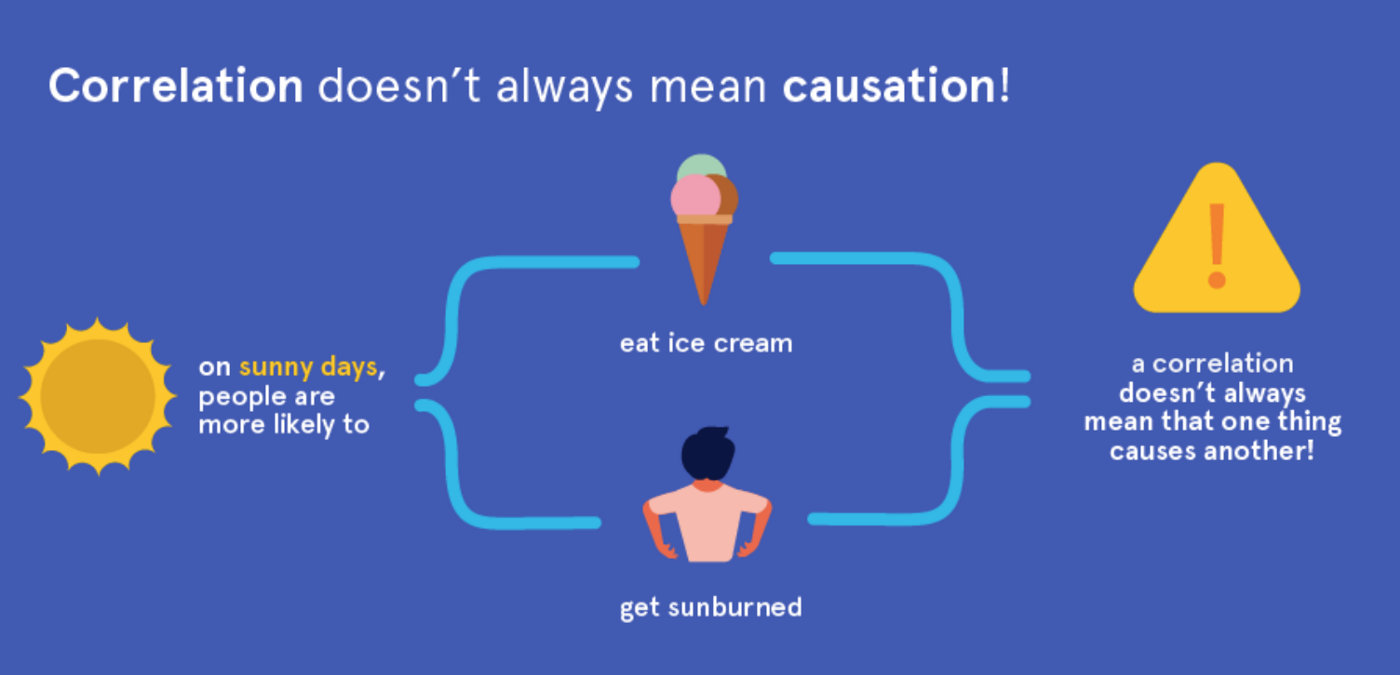

Though we can get good forecasts based on correlated variables, if we try and understand the causality behind those variable, we can identify better features, thereby creating a better model.

# ARIMA Family of Forecasting Techniques

## 1. Auto Regression (AR)

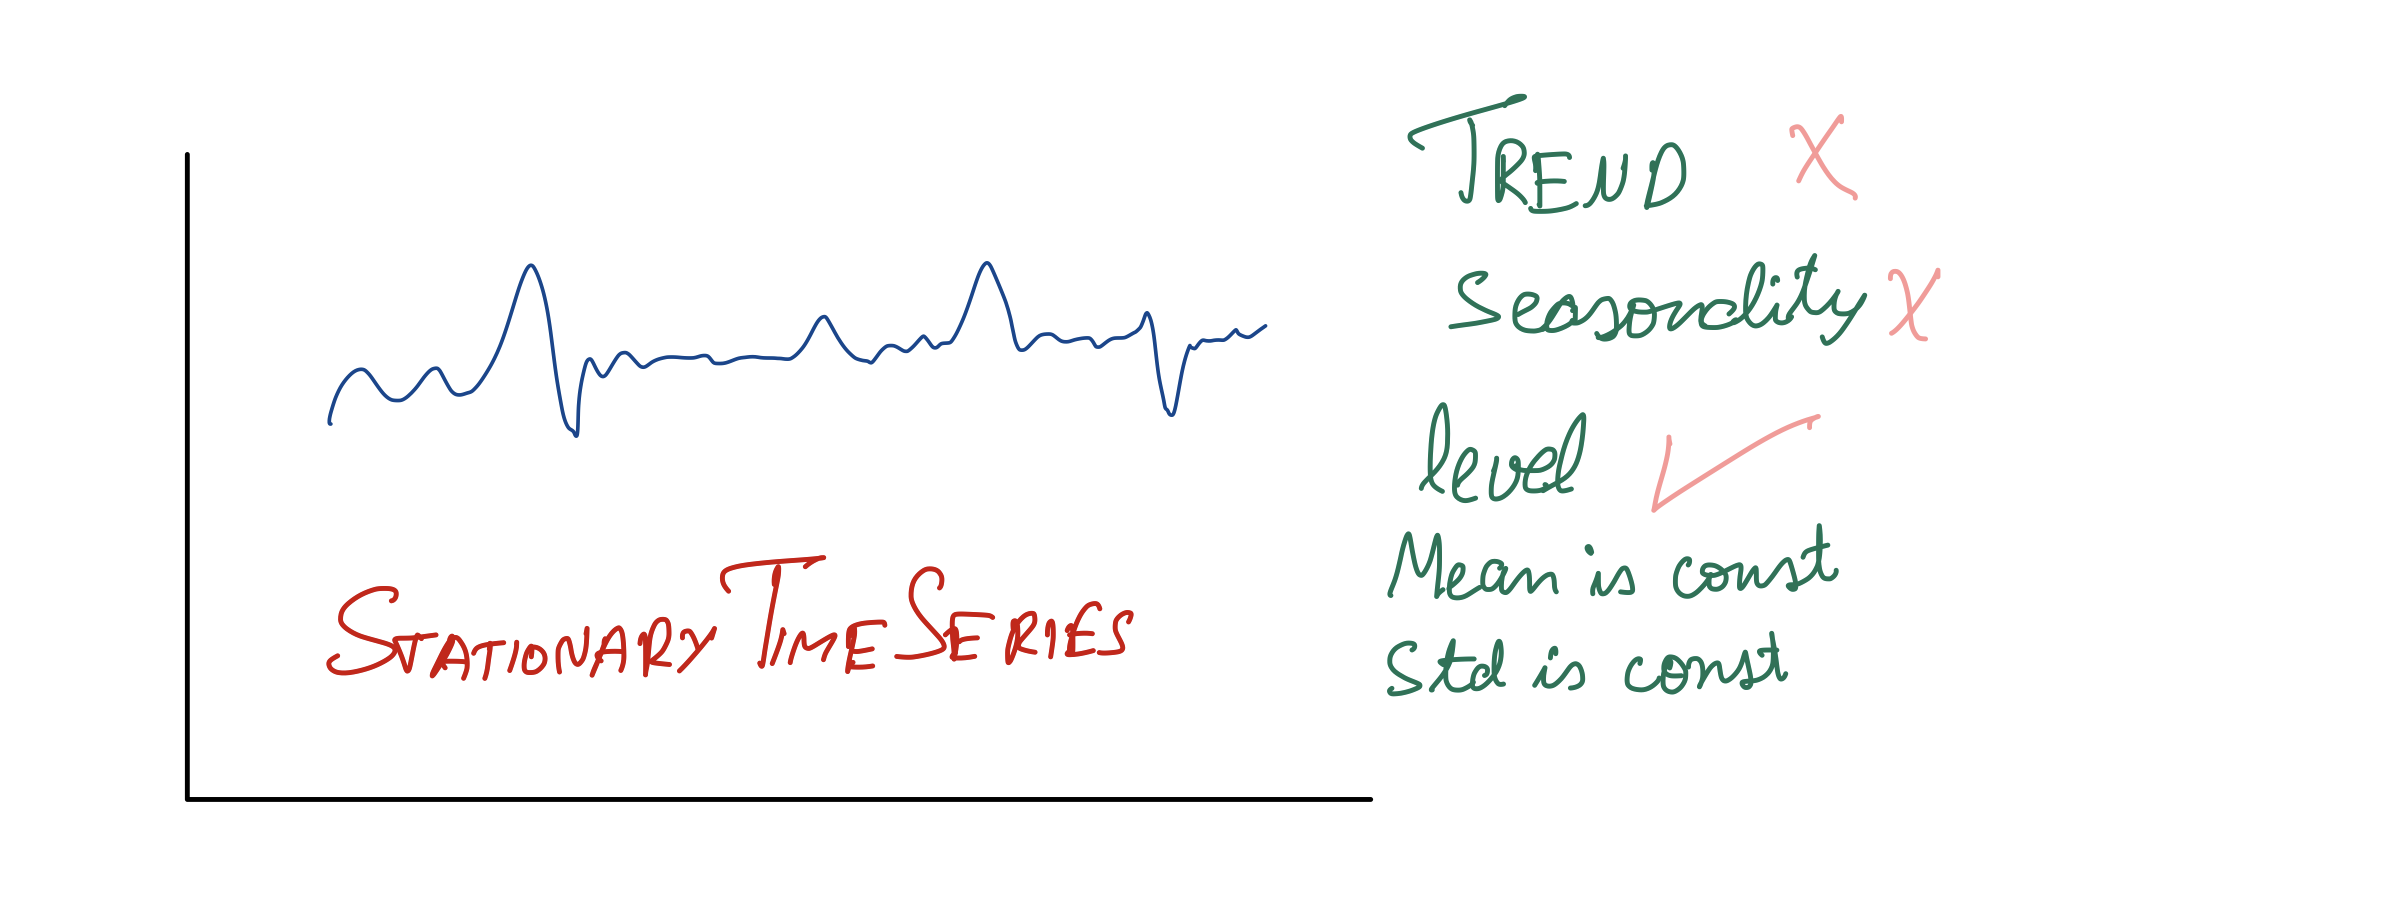

So far, the models we've seen, assume a trend and seasonality component.

But what about the case of stationary series?
In this case, we're kind of helpless, because there is no pattern in the series.
For such cases, we study this new family of models, called ARIMA Family.

- Though such series look like they are completely random, there is still some extent of forecastability here,

There is still information left to be extracted from stationary series.
- Any trend or seasonality that was present, has been removed from series, will be added later

An autoregressive model is when a value from a time series is regressed on previous values from that same time series
In this regression model, the response variable in the previous time period has become the predictor and the errors have our usual assumptions about errors in a simple linear regression model.

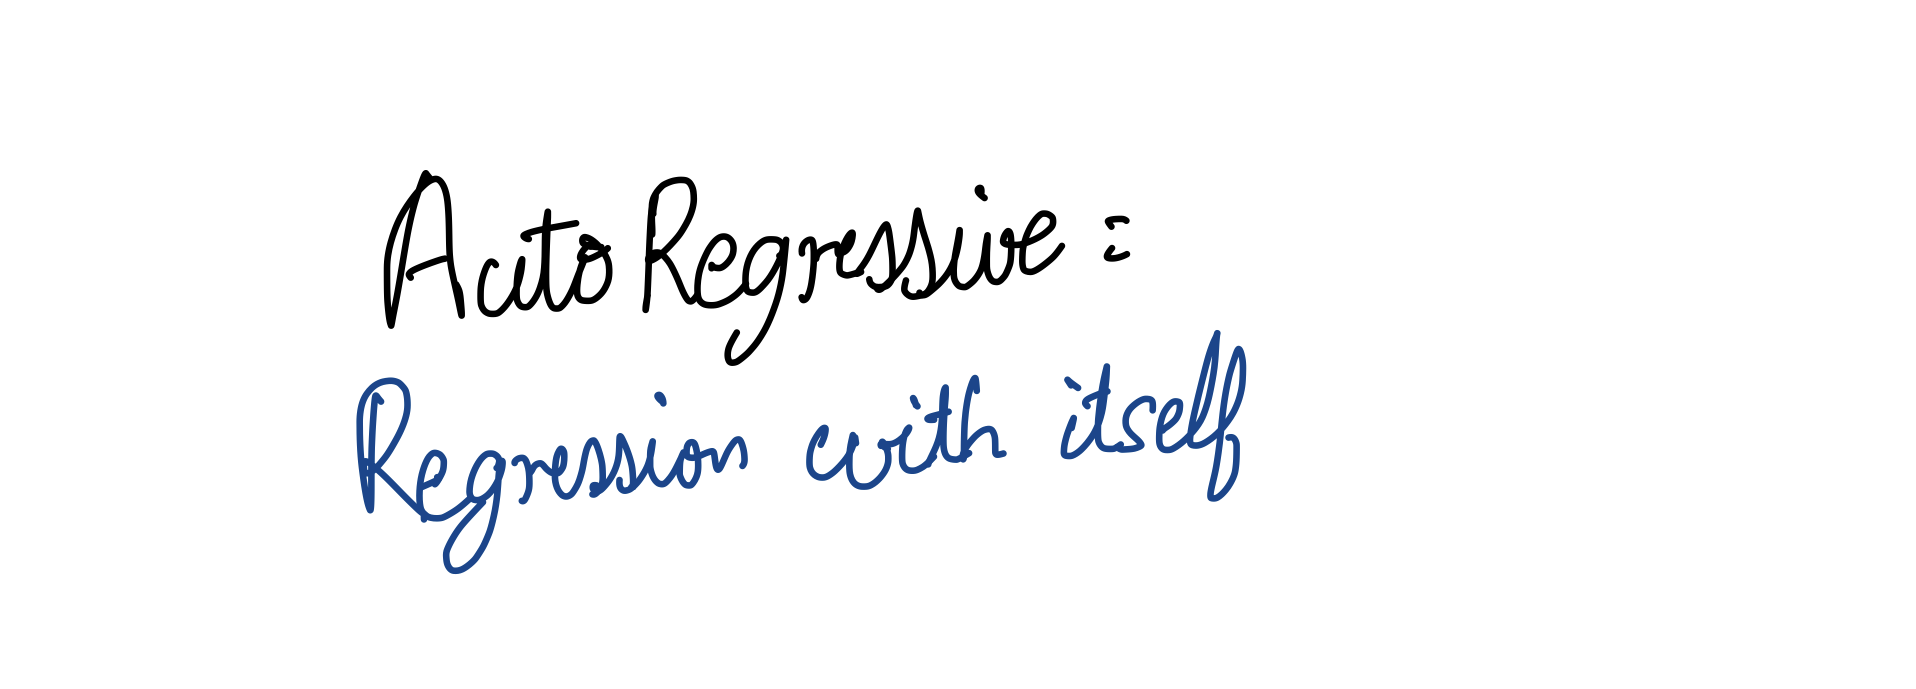

 we could just utilise **Linear Regression**, by mapping this feature's values with the value to be forecasted.

<br>

We can use the past experience/values as feature, so that we can utilise Linear Regression.

We can map the value of the stationary time series at time $t$ with the value of series at time $t-1, t-2, t-3, ..., t-p$, where p is the number of past values we want to consider, it could be a **hyperparameter** we set.

This way, now our data becomes as shown.
- It contains date as index,
- Past values $y_{t-1}, y_{t-2}, ..., y_{t-p}$ as features and
- value at time $t$ as the value to be predicted ($\hat{y_t}$)

Now we can successfully implement Linear Regression using these features.

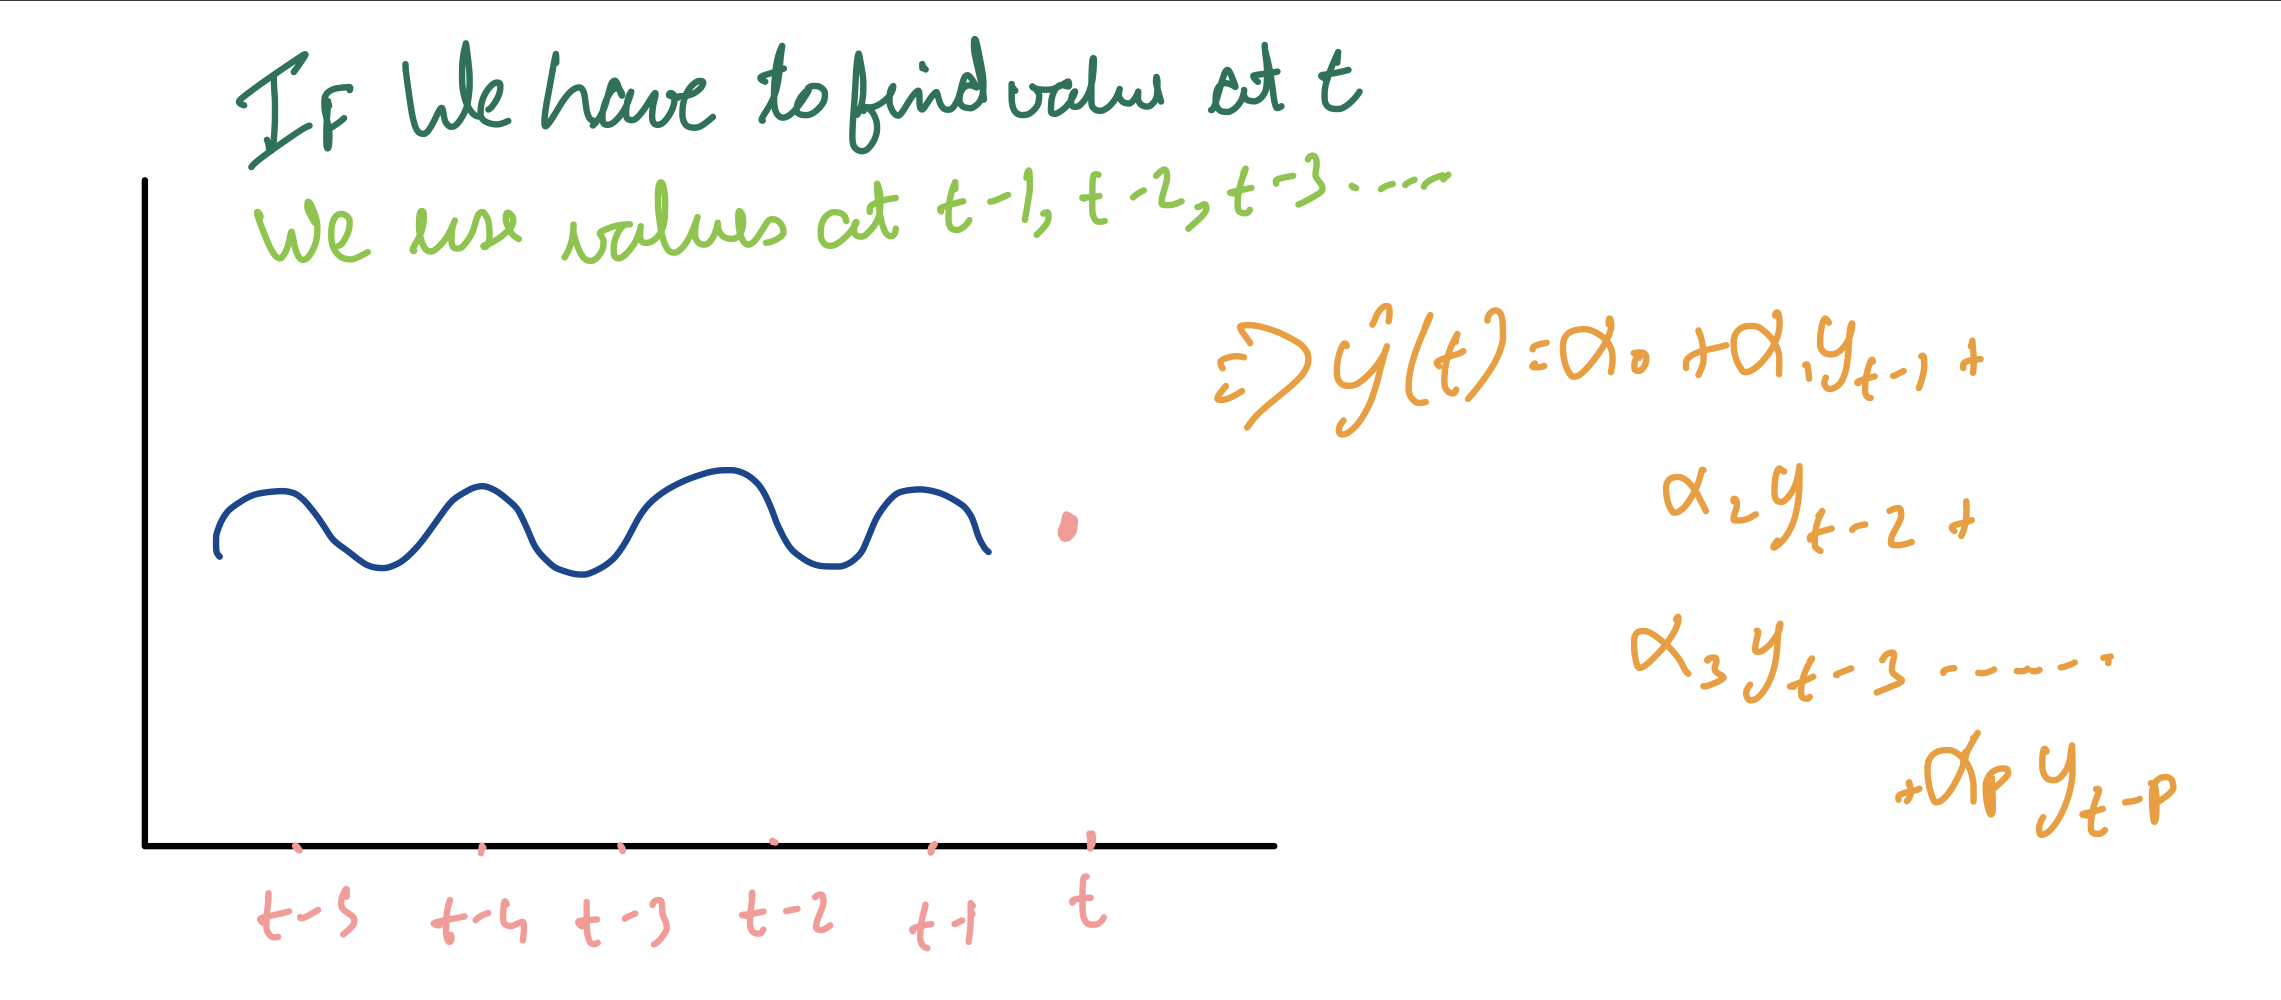

Essentially, we're converting our forecasting problem to Linear Regression.

We're saying that,

Future value $\hat{y}_t$ = LinearRegression(Past p values)

Recall the Linear Regression lecture, this converts our problem into following form

$ŷ_t = α_0 + α_1y_{t-1} + α_2y_{t-2}... + α_p y_{t-p}$

where
- $α_0$: intercept (parameter)
- $α_1, α_2, ..., α_p$: weights (parameters)
- $p$: No of past values to be considered (hyperparameter)

Hence, this is also known as the **AR(p) model**

Though we are essentially doing a weighted average of the past time series values in both SES and AR models, there is a fundamental difference.

**In case of SES**

- The weights are exponentially decaying
- The hyperparameter is  α

**In case of AR**

- The weights are learnt by multiple iterations.
- The hyperparameter is  𝑝

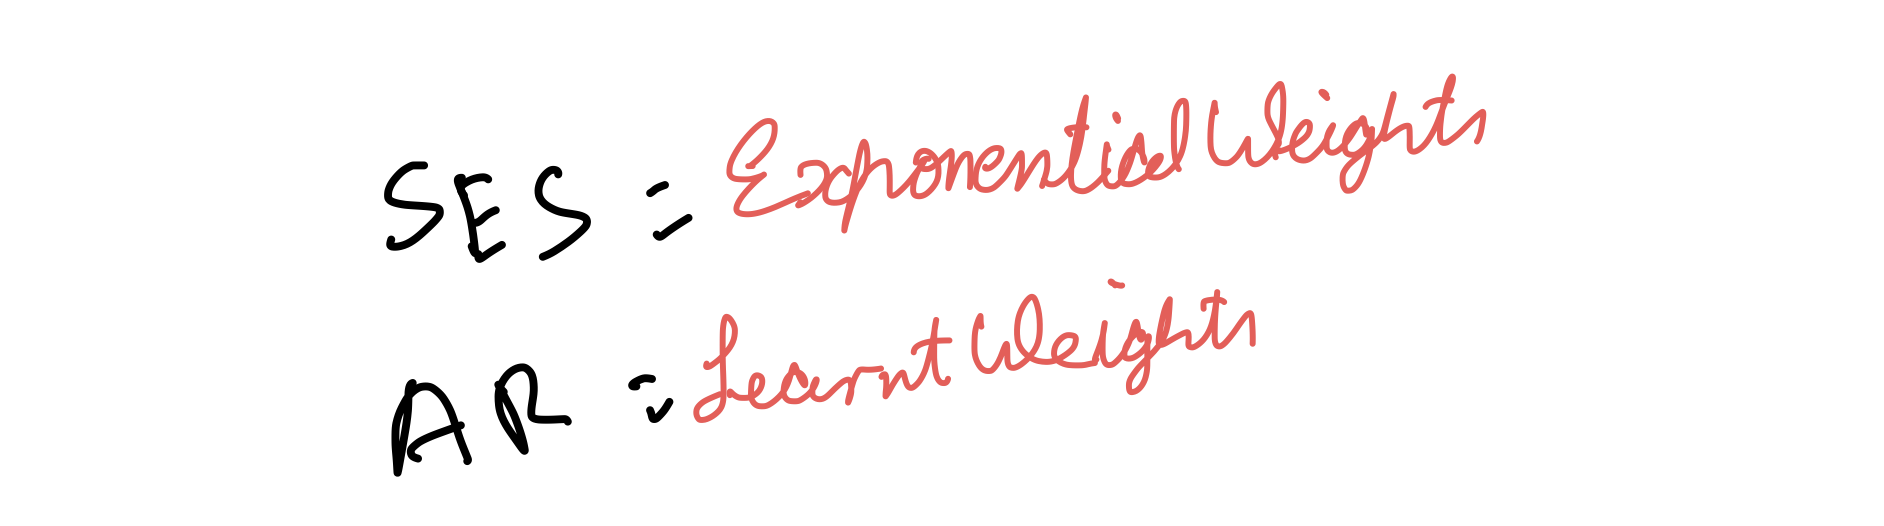

- so like linear regression the model will learn the weights
- the hyperparameter **p** is there for us to set

so how do we sset th hyperparameter

### Finding value of p from PACF

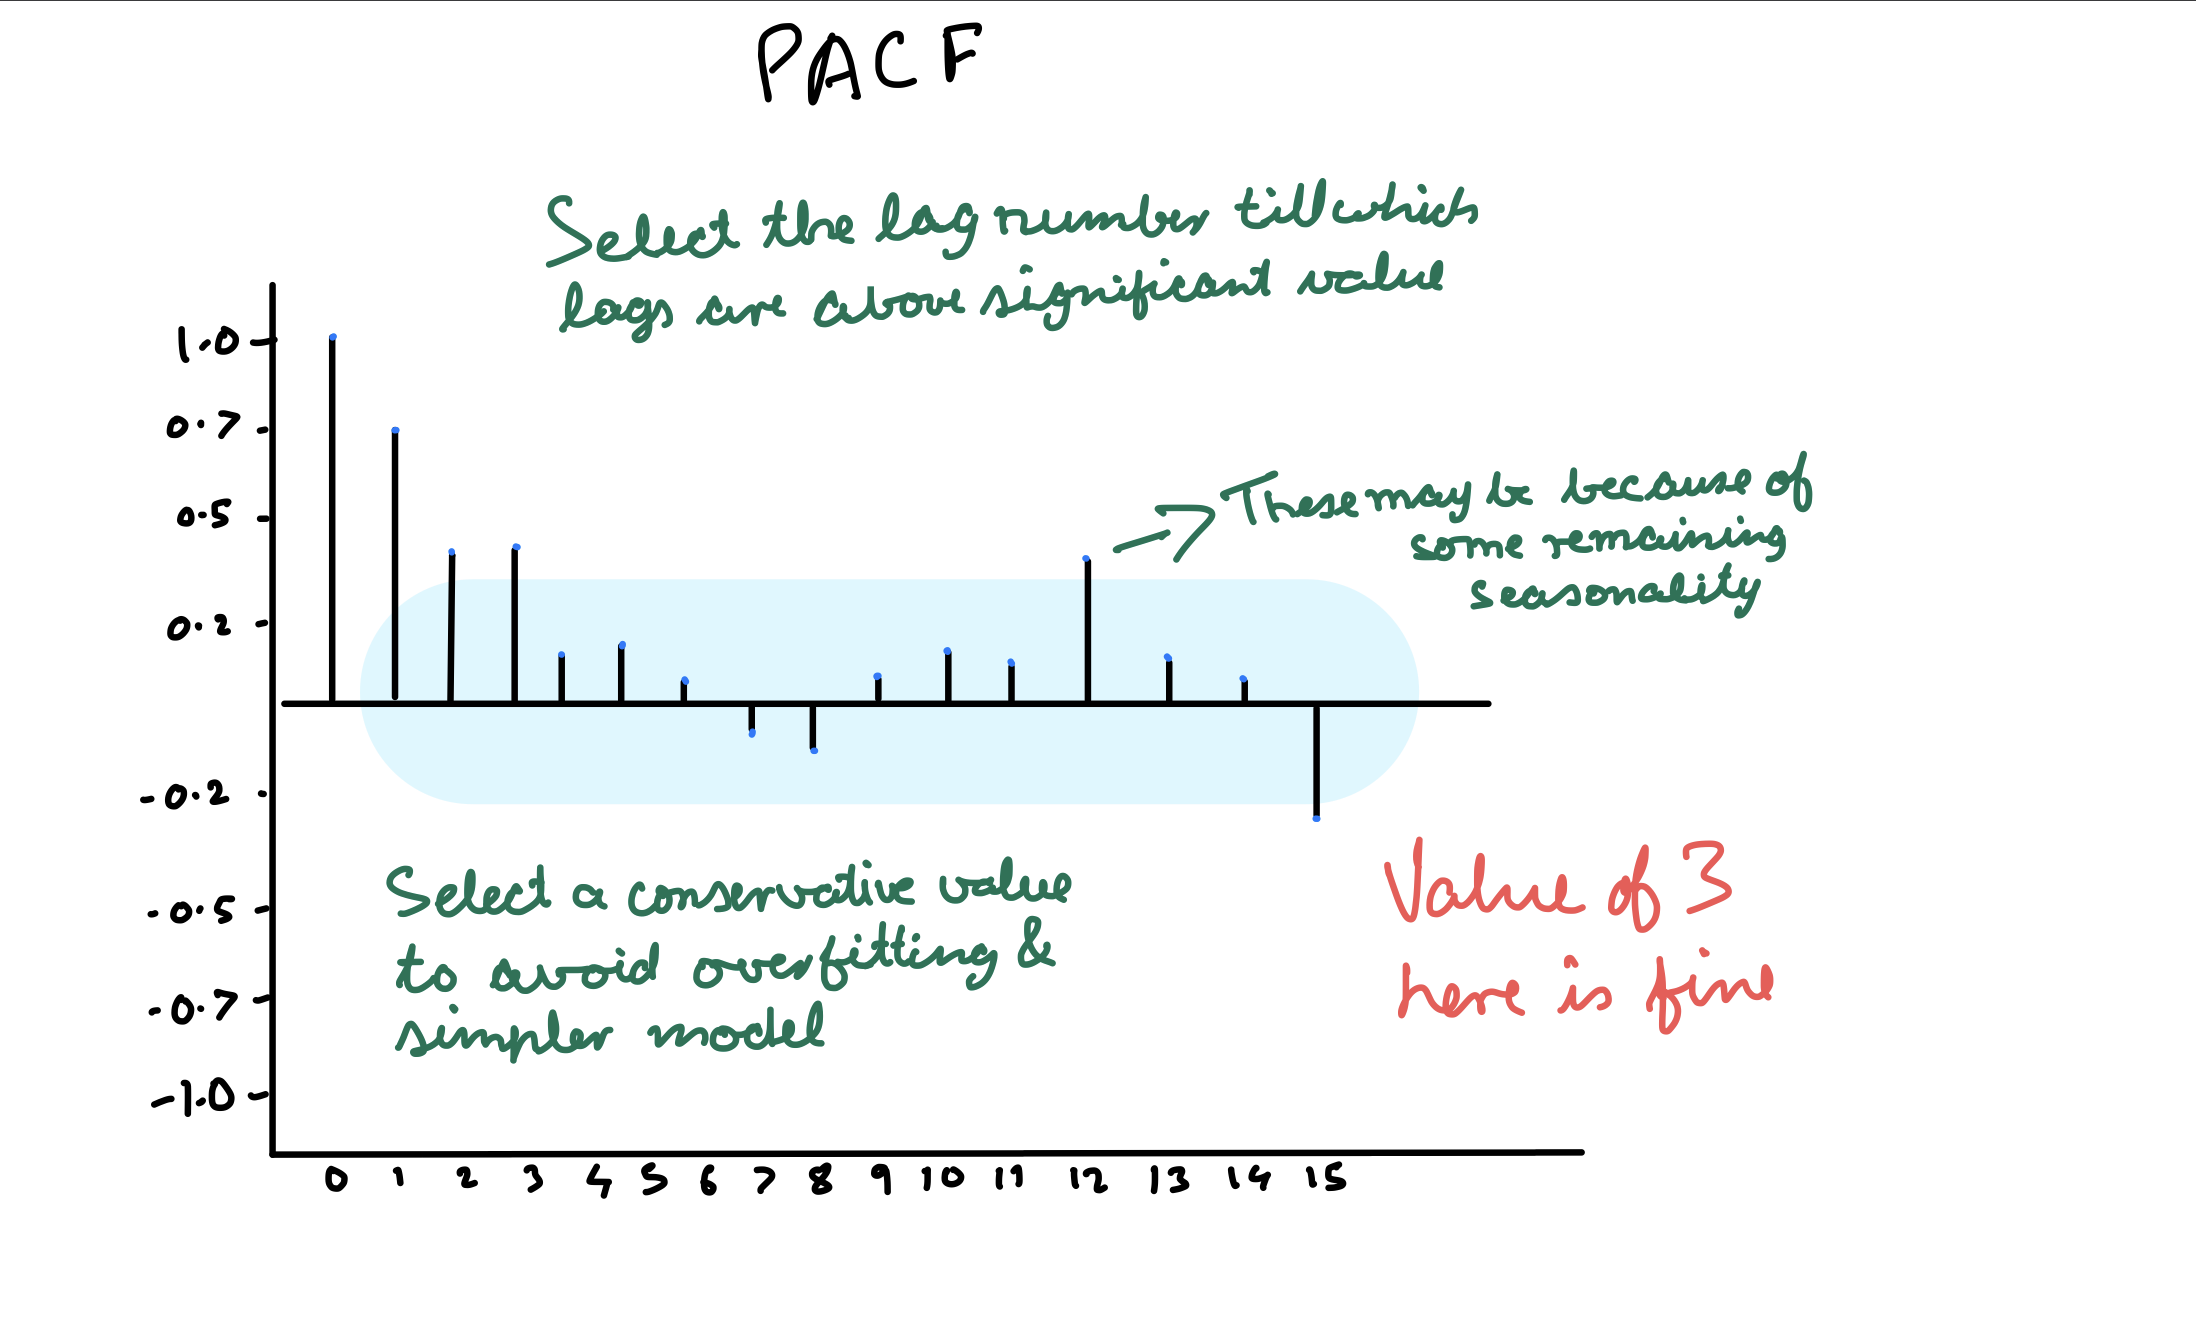

Before applying the AR Model, let's check the nature of our time series right now (stationary/non-stationary) using the `adf_test()`

In [ ]:
train_x.head()

Sales
DATE               
2001-01-01  6802.44
2001-02-01  6802.44
2001-03-01  7332.00
2001-04-01  7332.00
2001-05-01  8240.00

In [ ]:
def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   if pvalue <= 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')

adf_test(train_x.Sales)

Sequence is not stationary


Recall that we need to have a stationary time series to use AR Model.

Let's **de-trend** it by taking a difference of 1.

In [ ]:
train_x_st = train_x.copy()
train_x_st.Sales = train_x_st.Sales.diff(1)
train_x_st.dropna(inplace=True)
adf_test(train_x_st.Sales)

Sequence is stationary


> **Q. How can we implement AR in code?**

We import the SARIMAX function from **statsmodel**. We will shortly see what SARIMAX itself means.

We have to pass `order` parameter. It accepts a tuple of 3 values, we will see what these values mean.

For now, in order to implement pure AR, we pass `(1,0,0)` to `order`, where 1 specifies the order we wish to use for AR. We can change this order as per our choice.

In [ ]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(1, 0, 0))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x['pred'].head(20)

DATE
2018-02-01    1728.700558
2018-03-01    -635.966295
2018-04-01     233.963671
2018-05-01     -86.072170
2018-06-01      31.664824
2018-07-01     -11.649074
2018-08-01       4.285542
2018-09-01      -1.576595
2018-10-01       0.580009
2018-11-01      -0.213378
2018-12-01       0.078499
2019-01-01      -0.028879
Name: pred, dtype: float64

Since we've gotten the forecasts from the de-trended series, we need to **integrate the trend back**, in order to obtain the true value of our forecasts!

In [ ]:
# Integrate !!

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

MAE : 2307.213
RMSE : 2585.999
MAPE: 0.153


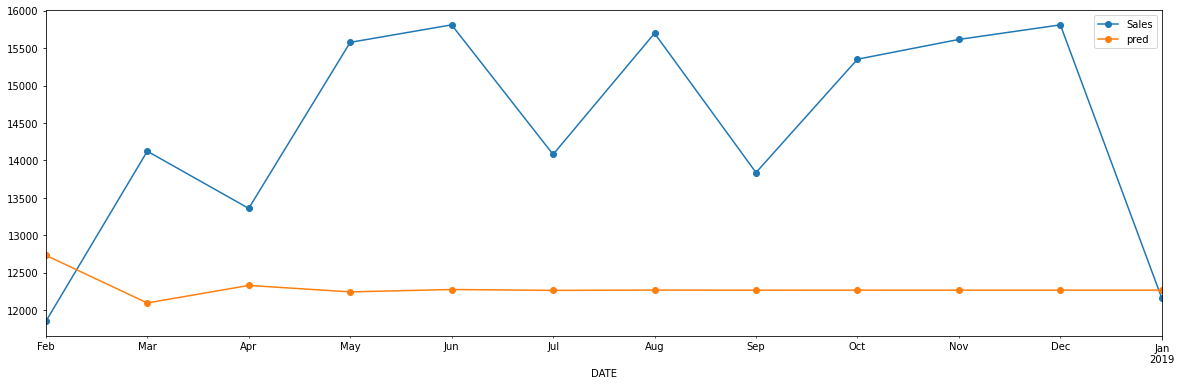

In [ ]:
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

This is not performing that well. Let's see what the optimal value for order should be by looking at PACF plot.

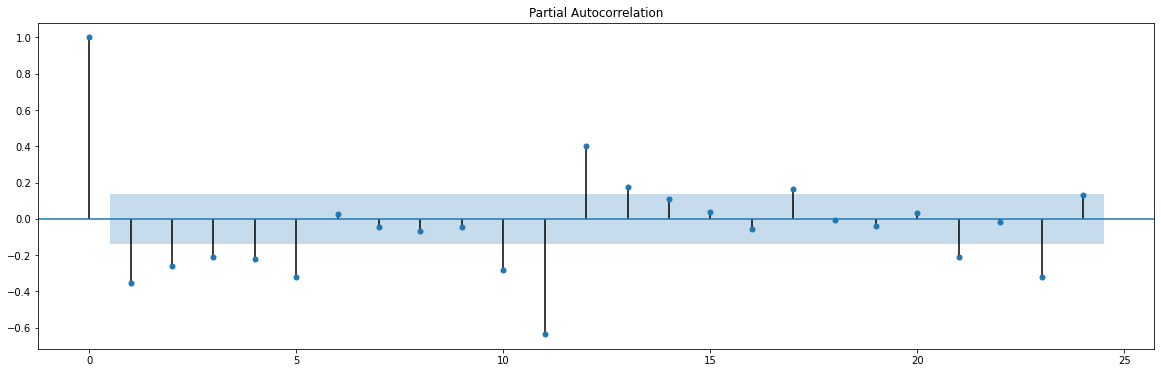

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(train_x_st.Sales);

From here, we see the best value is 3.
- Note that -ve is also significant.
- Here it could also be 4-5, but taking a conservative number to avoid overfitting and keeping the model simpler.
- later correlations maybe due to some more left over seasonality.

Lets try that

MAE : 1647.061
RMSE : 1890.003
MAPE: 0.11


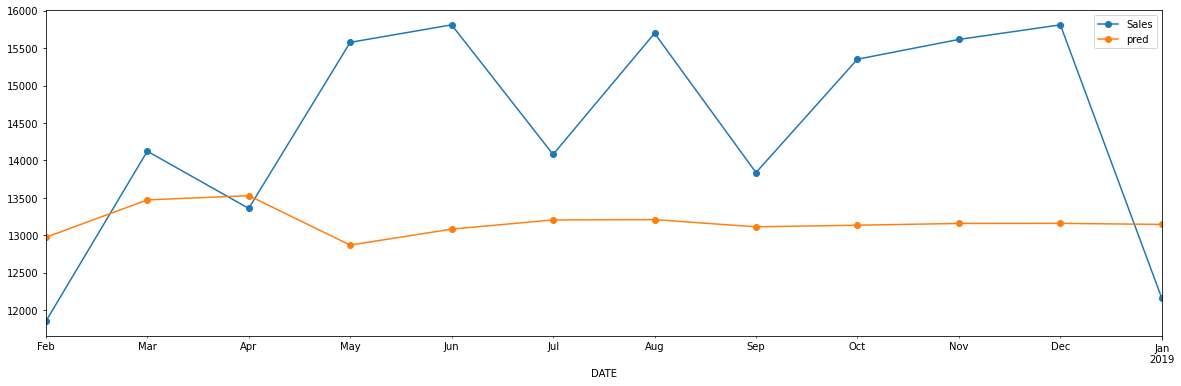

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(3, 0, 0))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

# Integrating the trend back!
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

# Plotting
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

## MA Model
the moving average model, states that the current value is linearly dependent on the current and past error terms.

The error of each data point in the series from the mean/average, would be different.

This should also work, as we are able to successfully create a new feature that is unique for each point.

In fact, this idea is called the Moving Averages (MA) technique.

> Though the name is same as the smoothing technique, we looked at before, this has nothing to do with that, and is a completey different concept.
- A moving average model is used for forecasting future values, while moving average smoothing is used for estimating the trend-cycle of past values.

**we'll see the equation and then see how does it work**

just like the AR equation which is in turn a linear regression equation we can see that
- we have our intercept $\mu$
- aur coefficients or our weights $\theta$
- and instead of previous values like in AR we will use the previous errors
- this will continue till q like in AR we continued till p which is our hyperparameter

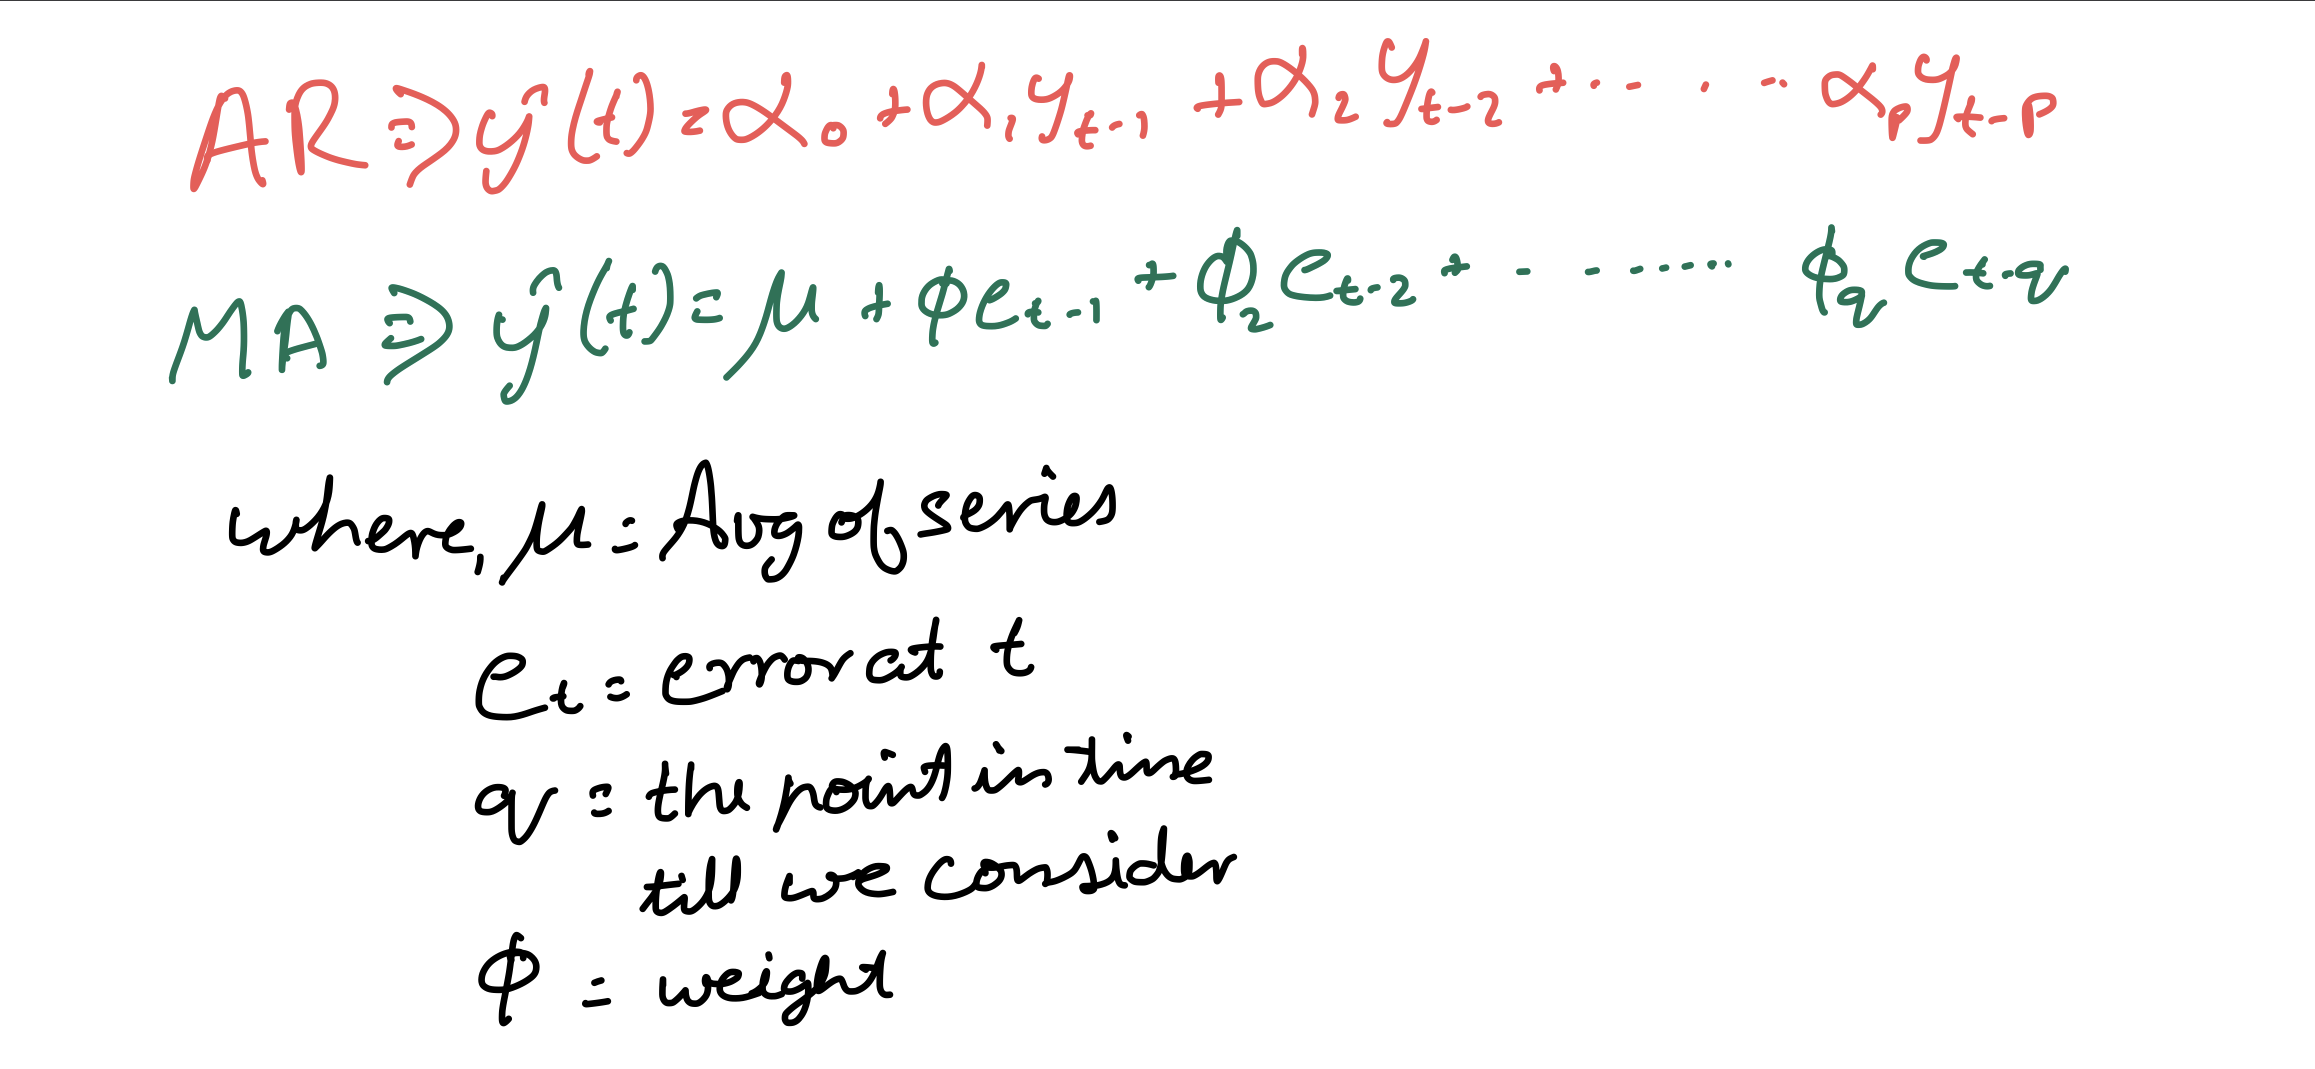

instead of looking on the previous values of forecvast what we will do is we will focus on the errors for the previous forecasts

> **lets start by understanding what do we nean by moving avegae here**

we will have an average of our time series and according to the errors in the predictions we will move around it


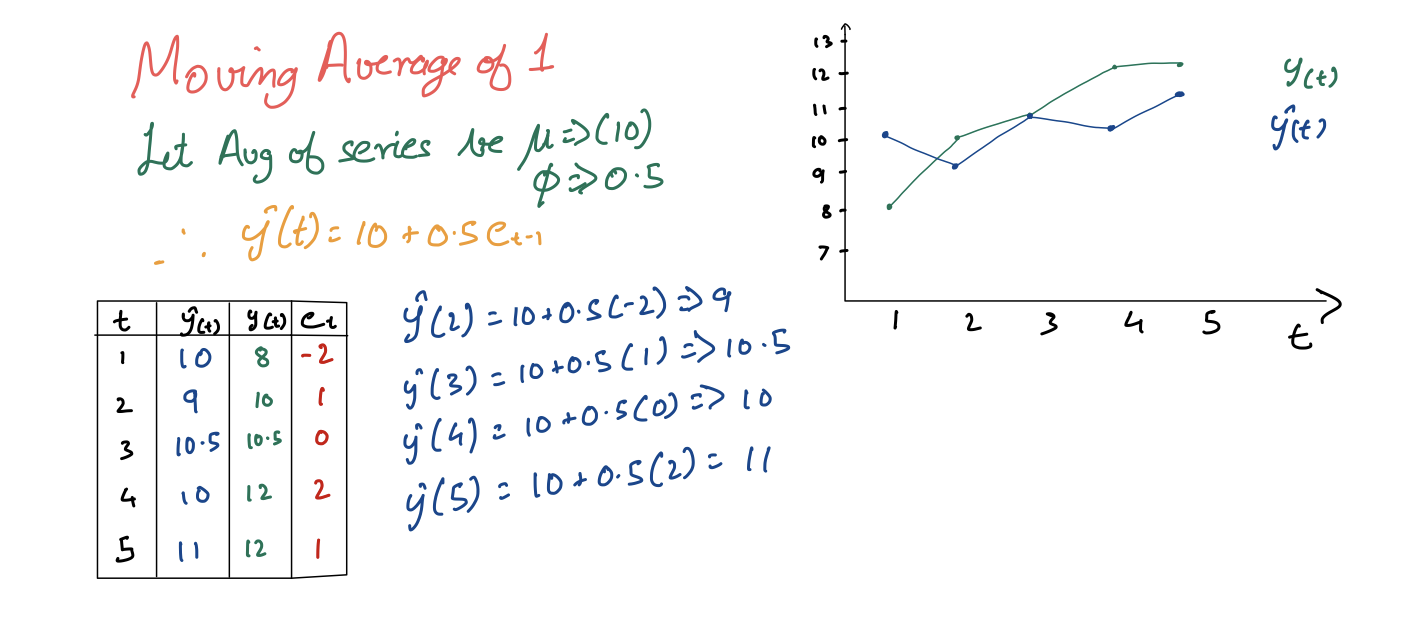

- what we are basically doing is we are starting with a base prediction which is our average of the series and then correcting it based on the previous errors
- MA models are useful for tackeling external factors which effect our series, because we take in account the errors that occur due to them

### finding value of q

like we did while finding the value of p with pacf plot we plot acf and then get the lag number of significant lines

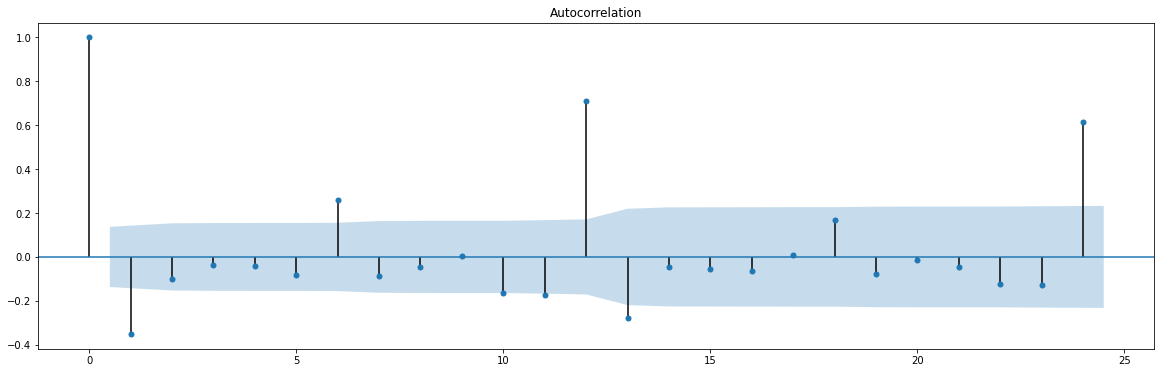

In [ ]:
plot_acf(train_x_st.Sales);

> How can we implement MA in code?

The same way as AR.

Only, the order in which we give value to order changes.

Now, we make the first value in tuple as 0, indicating that we do not want any AR, and we specify the order in the third value as the order for MA.

Let's plot it and see

MAE : 1362.947
RMSE : 1558.015
MAPE: 0.093


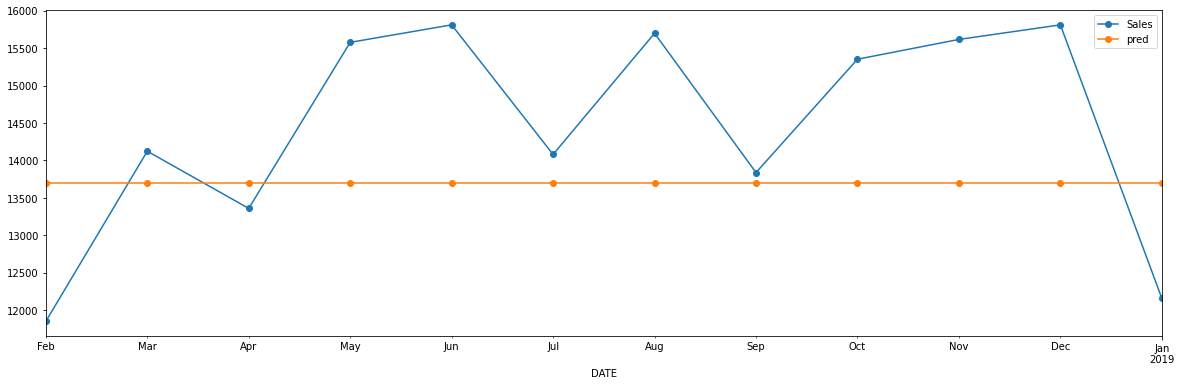

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(0, 0, 1))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

> MA models are mostly not used independently it is often combined with the AR model for better prediction

## 3. Auto Regression - Moving Averages (ARMA)

This is a model that is combined from the AR and MA models. In this model, the impact of previous lags along with the errors/residuals is considered for forecasting the future values of the time series.

- because we take in account for the previous lags as well as the errors that may be there, we can build a highly accurate model

While combining these two ideas,
- `p`: order of AR  
- `q`: order of MA

 - `p` may or may not be equal to `q`

- Here, `p` and `q` are **hyperparameters**
- Hence it is also called as **ARMA(p,q) Model**.

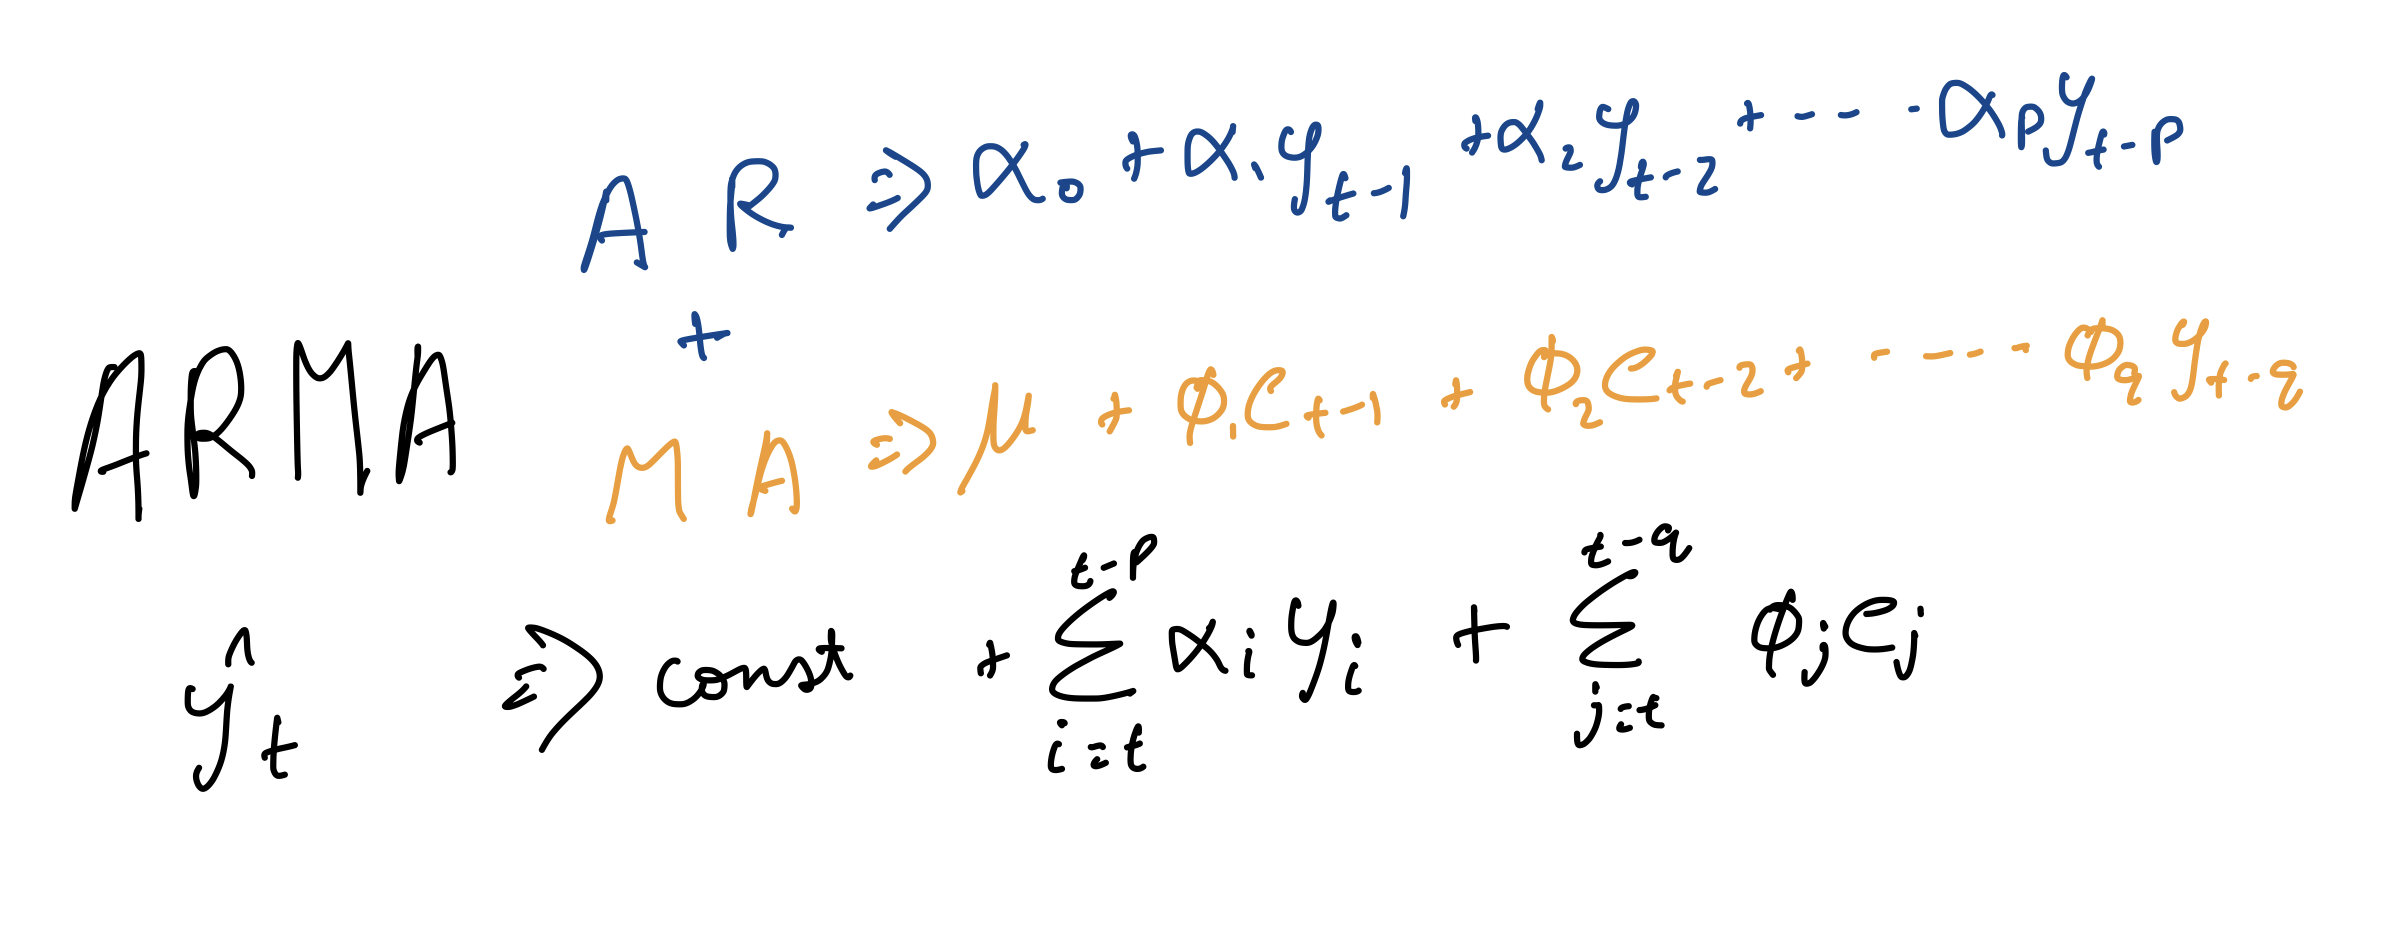

### Finding p,q values

Exactly same as for AR, MA models
- **the values from the plots may not always be easy to interpret in real life and requires some hit and trial as well for selecting the actual values for all these models**

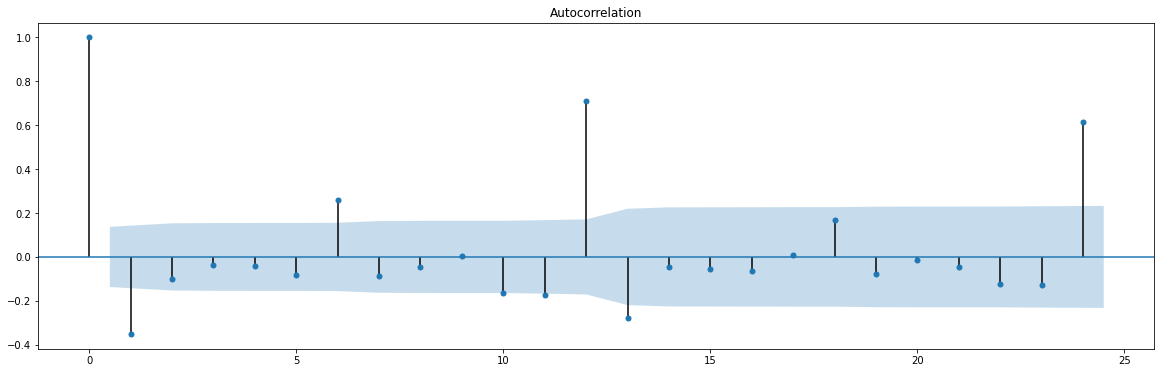

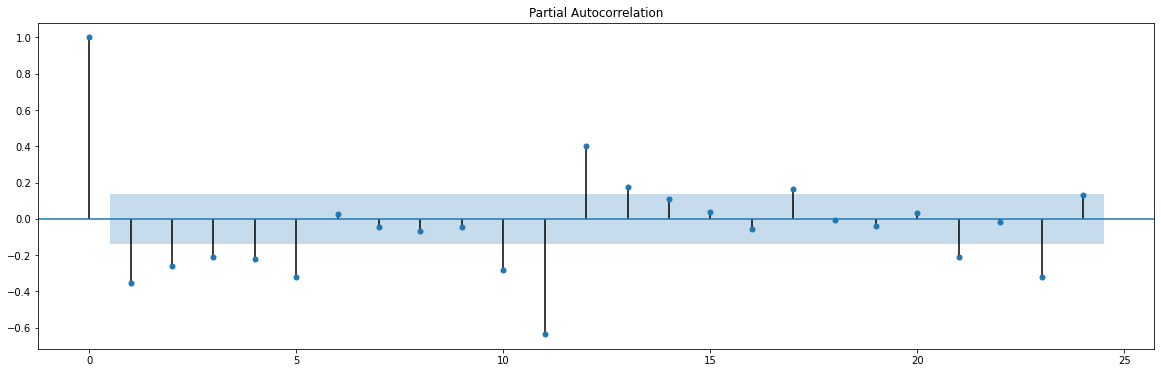

In [ ]:
plot_acf(train_x_st.Sales);
plot_pacf(train_x_st.Sales);

MAE : 1355.315
RMSE : 1523.819
MAPE: 0.092


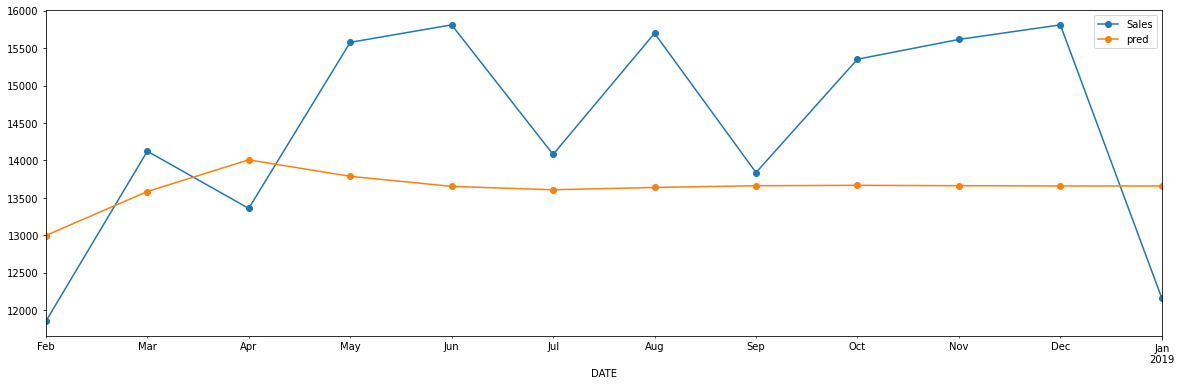

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(3, 0, 1))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

- Let us try some more values and see if we can get a better result

MAE : 1041.837
RMSE : 1271.606
MAPE: 0.07


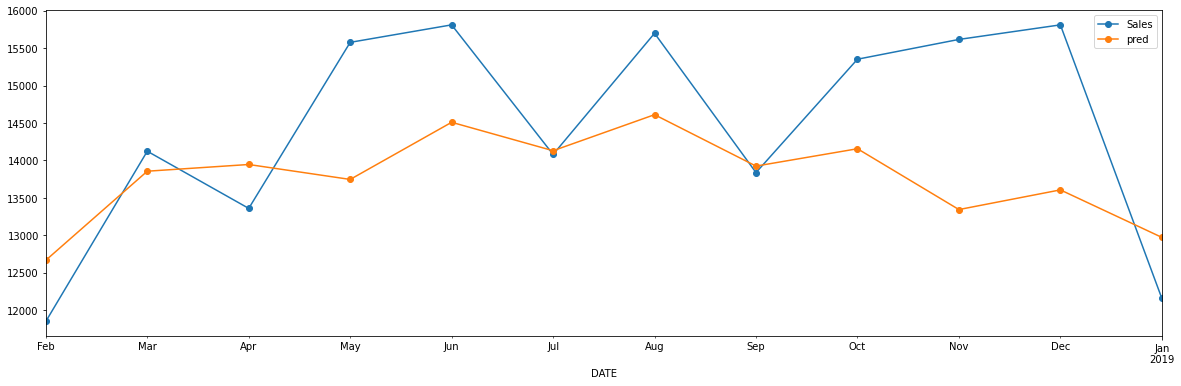

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(3, 0, 6))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

- We definetly see a lot of improvement over our last result
- We increased the q vale to 6 because we saw some significant rise in the acf plot there
- if you look closely that we can see that multiple of 6 have higher significant level then others
- this may be because we have some seasonality left in the data

**Limitation of ARMA**

Requires the series to be stationary

#### **Quiz-3:**

```
Which is not a hyperparameter in the ARMA model?

a. Order of auto-regression
b. Order of Differencing
c. Order of Moving Averages
d. None of them

```
Answer: b -  Order of Differencing  

---

## 4. ARIMA

> **What if we do not have a stationary time series?**

In such a case,
 * We perform **differencing** to de-trend
 * Then we apply the ARMA technique, to get an approximation.
 * Now to get a good forecast, we need to **integrate** the trend **back** to get the final result


That is ARIMA, where

AR= Auto Regressive

I= integrated

MA= Moving Average

ARIMA,  actually  ‘explains’ a given time series based on its own past values (like AR), that is, its own lags and the lagged forecast errors(like MA)

We already know how AR and MA work

the only new thing here is I intergrated part.

- very simply what it does is it differentiates the series for us, makes it stationary
- calculate forecast based on arma model
- integrate it back to get forecast on the original series

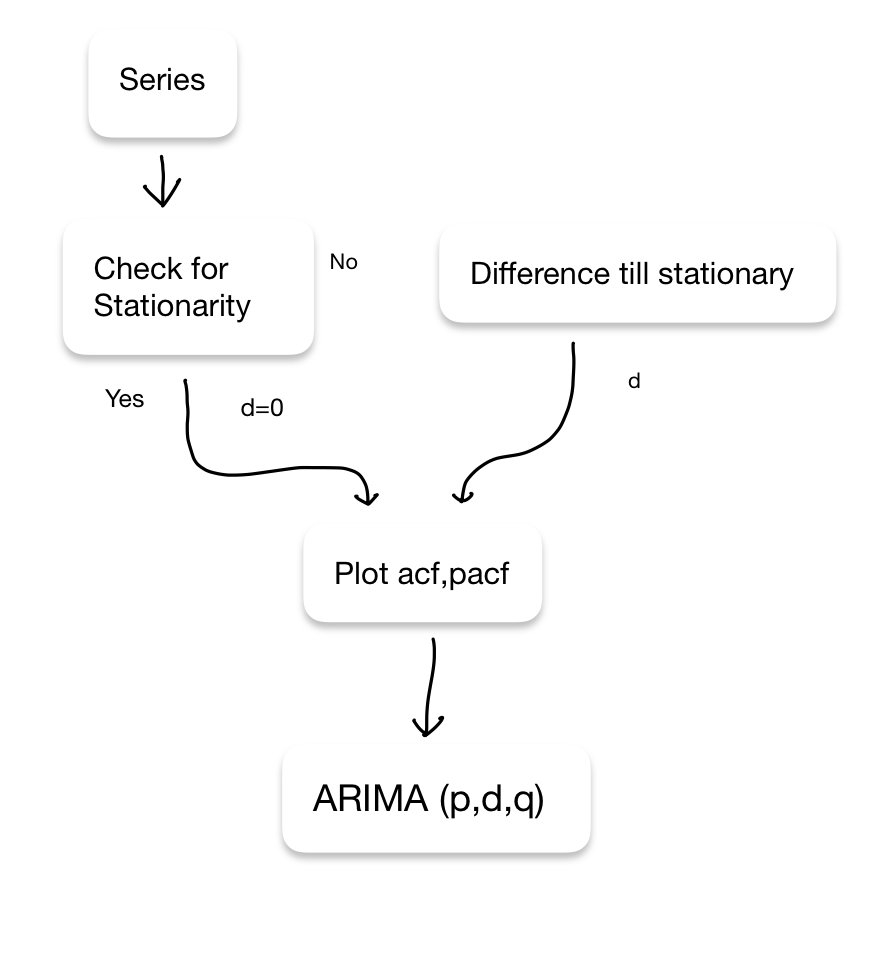

lets find the value of d with differencing
- we can see that it becomes stationary at diff of 1

In [ ]:
train_x_st = train_x.copy()
train_x_st.Sales = train_x_st.Sales.diff(1)
train_x_st.dropna(inplace=True)
adf_test(train_x_st.Sales)

Sequence is stationary


MAE : 998.655
RMSE : 1120.975
MAPE: 0.07


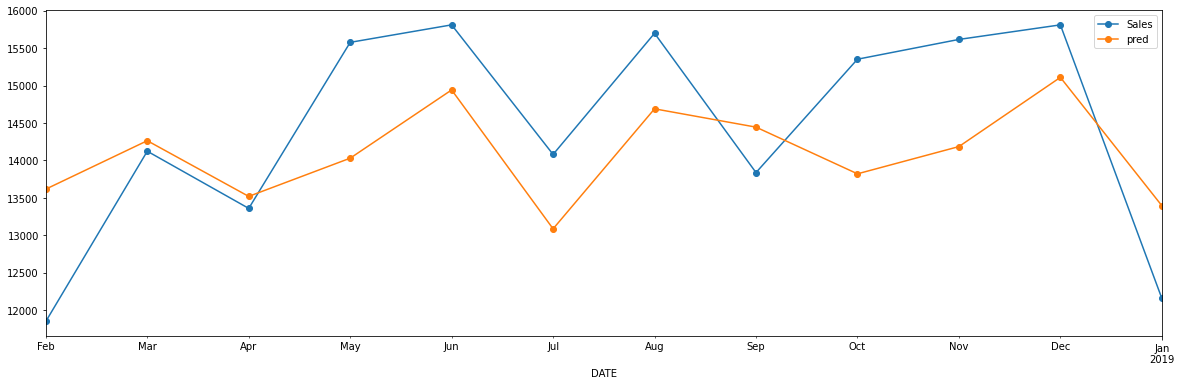

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(3, 1, 6))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

**A problem with ARIMA is that it does not support seasonal data.**

ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

## 5. SARIMA

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

If we wish to account for seasonality without SARIMA, the process becomes:-
- first differentiating $(x[i] - x[i-T])$, to remove seasonlity,
- then performing AR and MA,
- then integrating the seasonality back,

This is very tiring.

Instead of doing so much work to utilise the ARIMA model, we can just apply another model called :the **SARIMA model** directly.

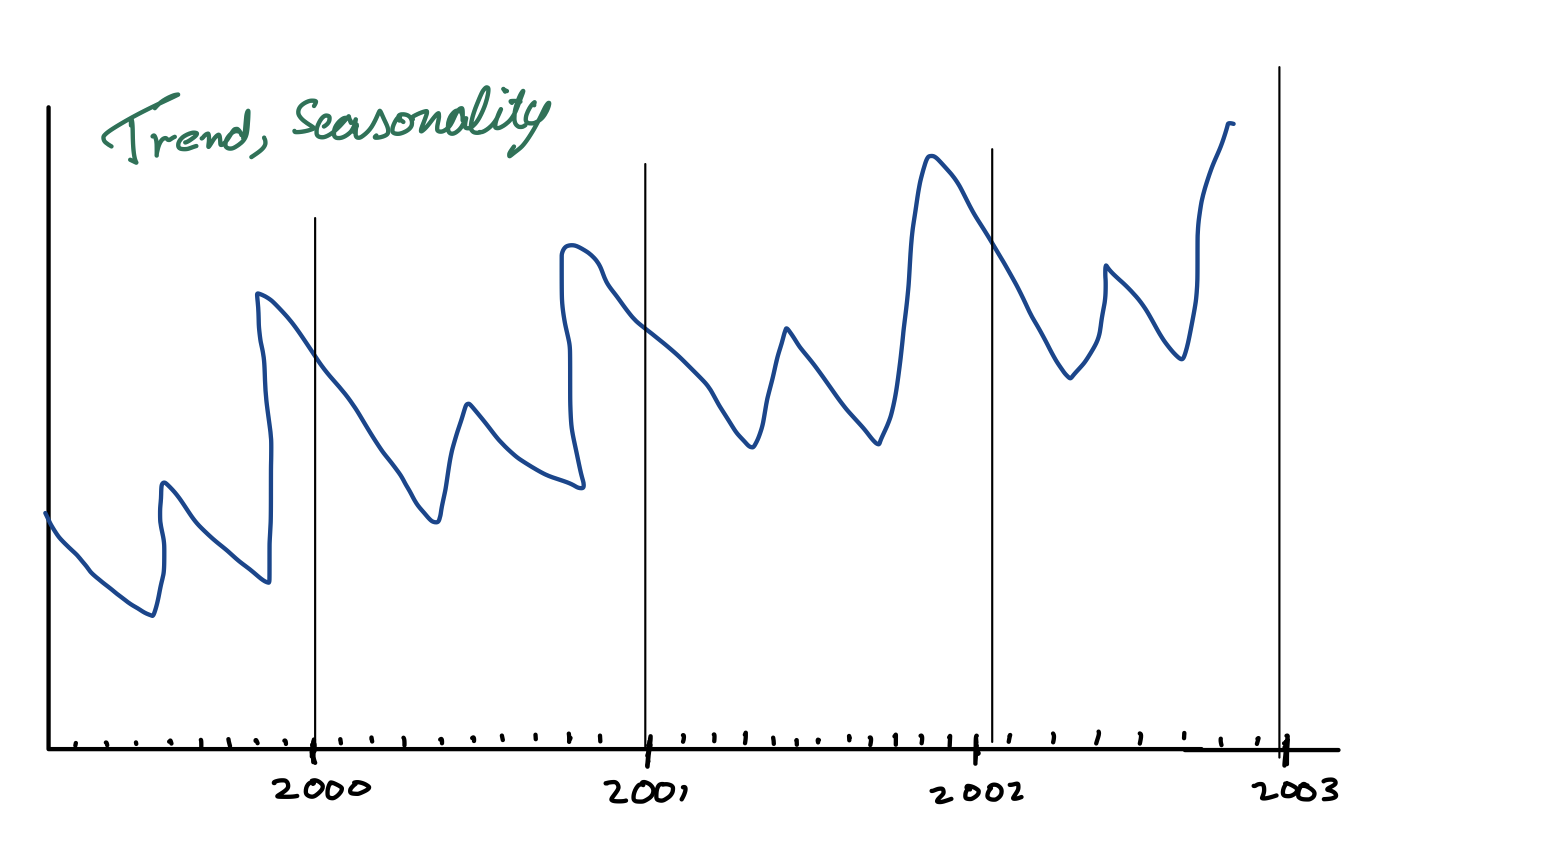


It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

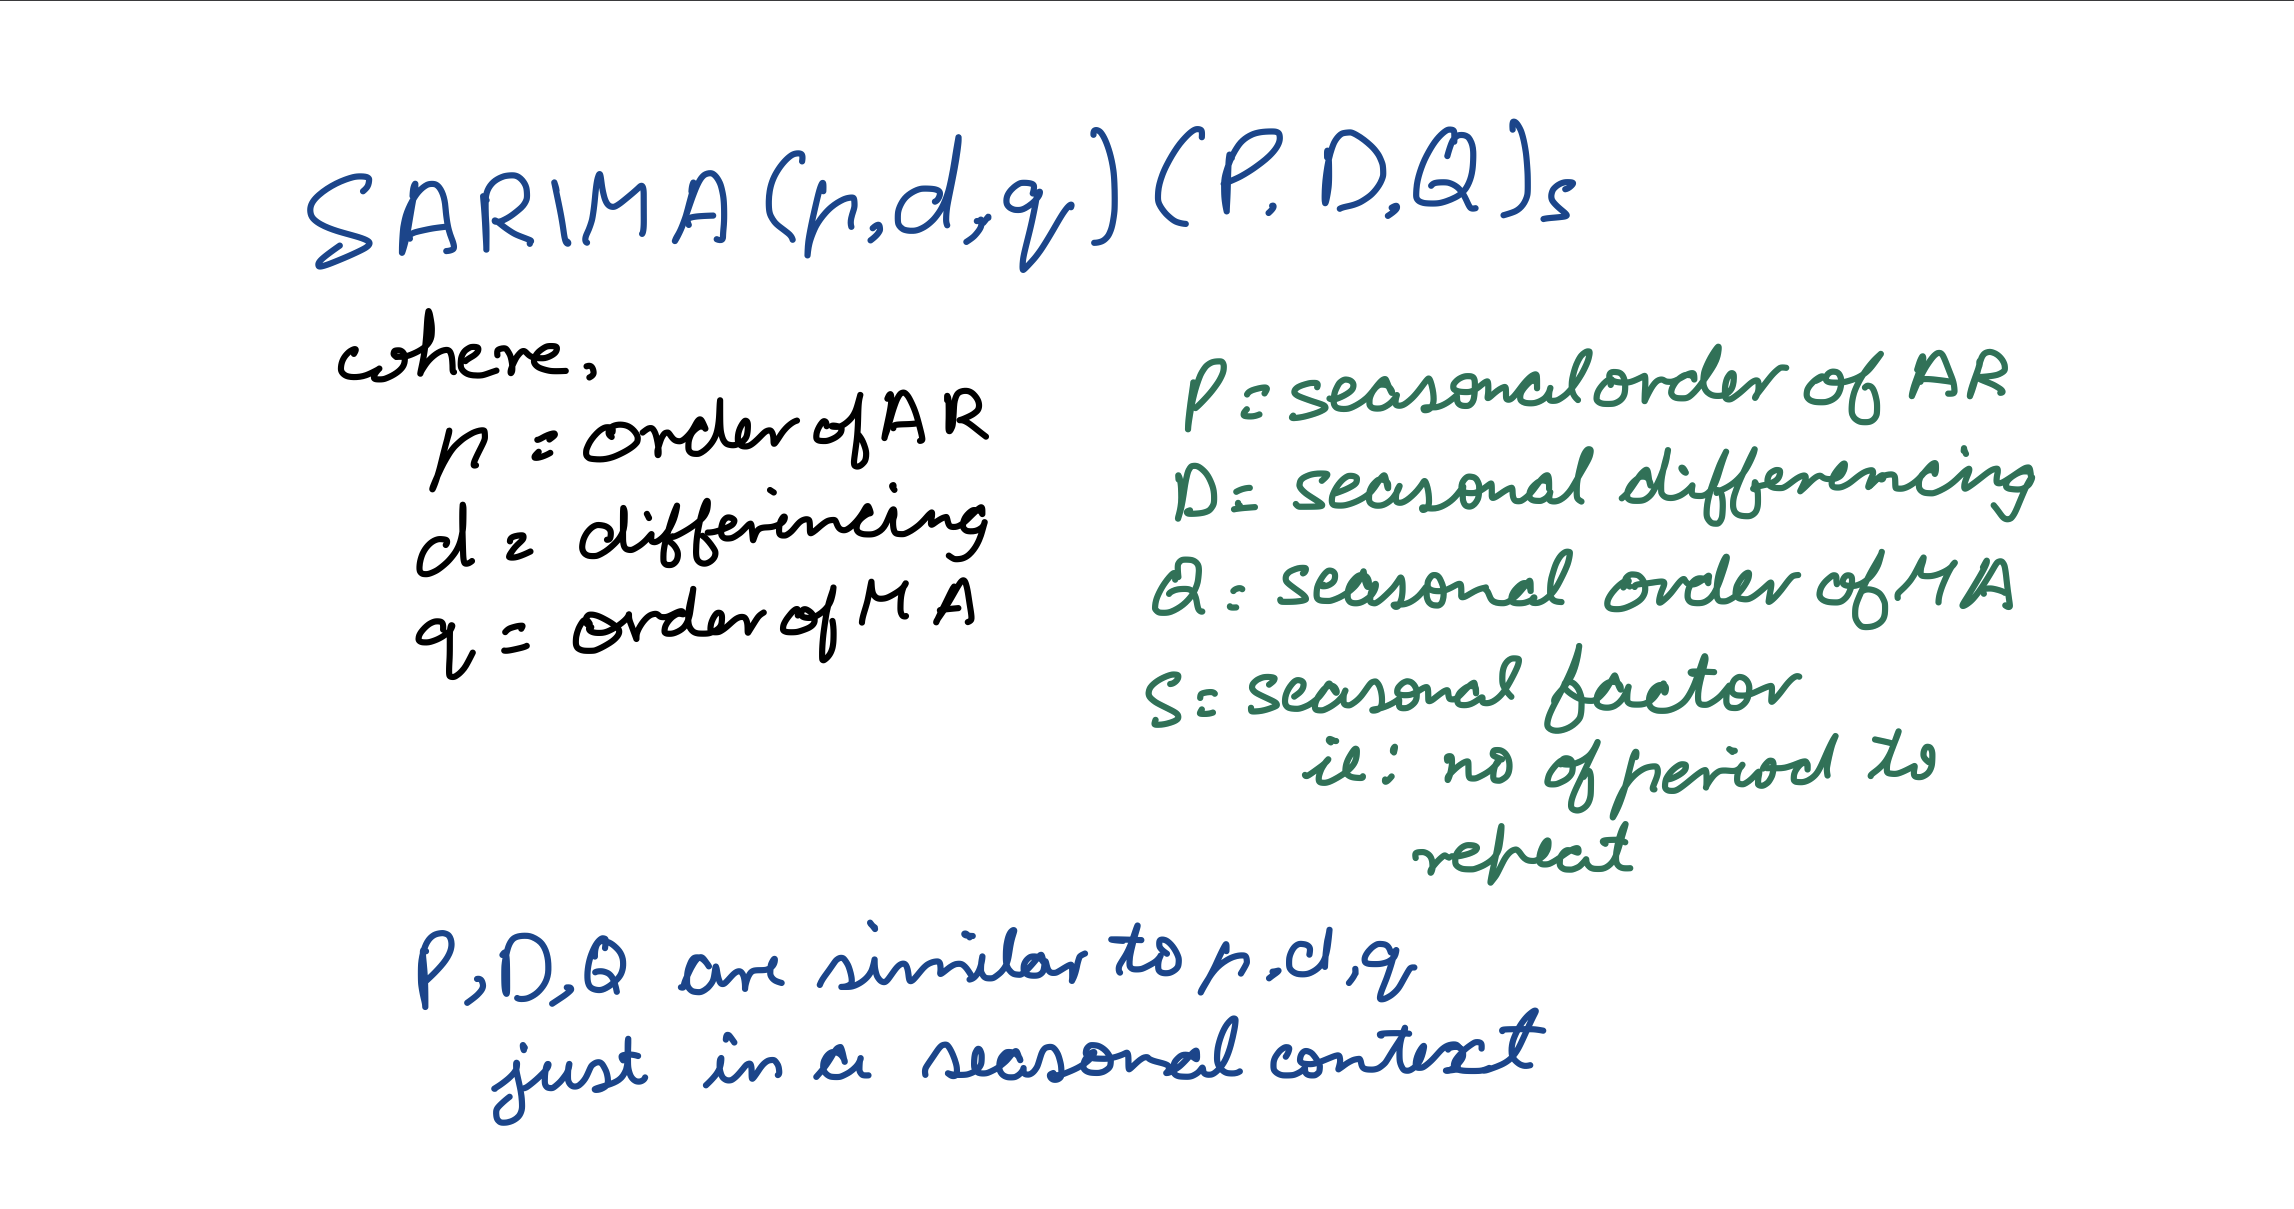

A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA. The seasonal part of the model consists of terms that are very similar to the non-seasonal components of the model, but they involve backshifts of the seasonal period.

**Trend Elements**

There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

**Seasonal Elements**

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- s: The number of time steps for a single seasonal period.

Together, the notation for an SARIMA model is specified as:

**SARIMA(p,d,q)(P,D,Q)s**

### Understanding the new terms

- **D Seasonal diffrence order** A seasonal ARIMA model uses differencing at a lag equal to the number of seasons (s) to remove additive seasonal effects. As with lag 1 differencing to remove a trend, the lag s differencing introduces a moving average term. The seasonal ARIMA model includes autoregressive and moving average terms at lag s.

- **P Seasonal autoregressive order** This will understand the seasonal aspect of the series. Giving importance to the lags on the basis of seasonality

- **Q: Seasonal moving average order** this will take the help of errors in the seasonal aspect of the series

### Finding the new order

Besides specifying values for the order parameter, we also need to add values for the seasonal_order parameter.

Like we did for ARIMA we will plot the acf,pacf plots again
- this time we will try to look for seasonality in the plots and check significant lags based on that

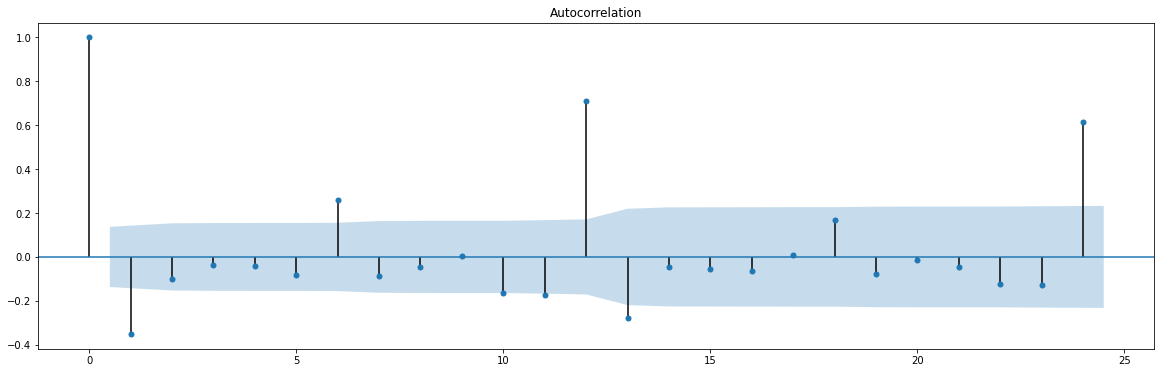

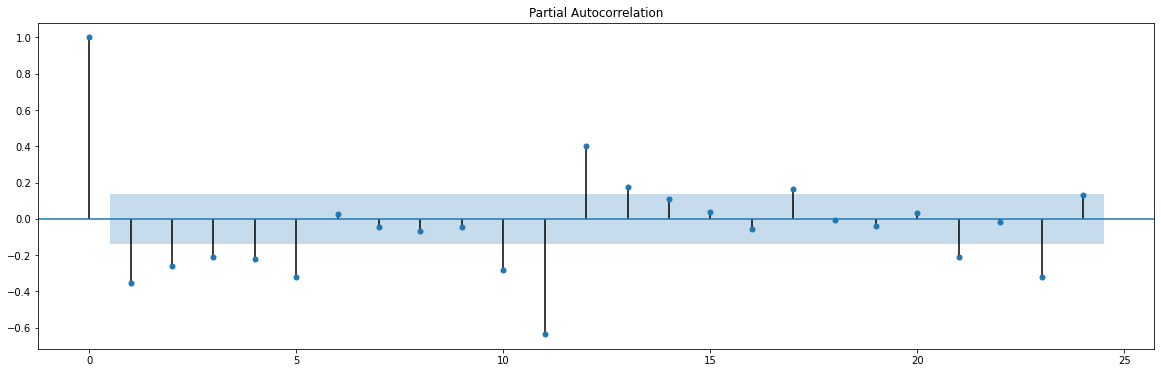

In [ ]:
plot_acf(train_x_st.Sales);
plot_pacf(train_x_st.Sales);

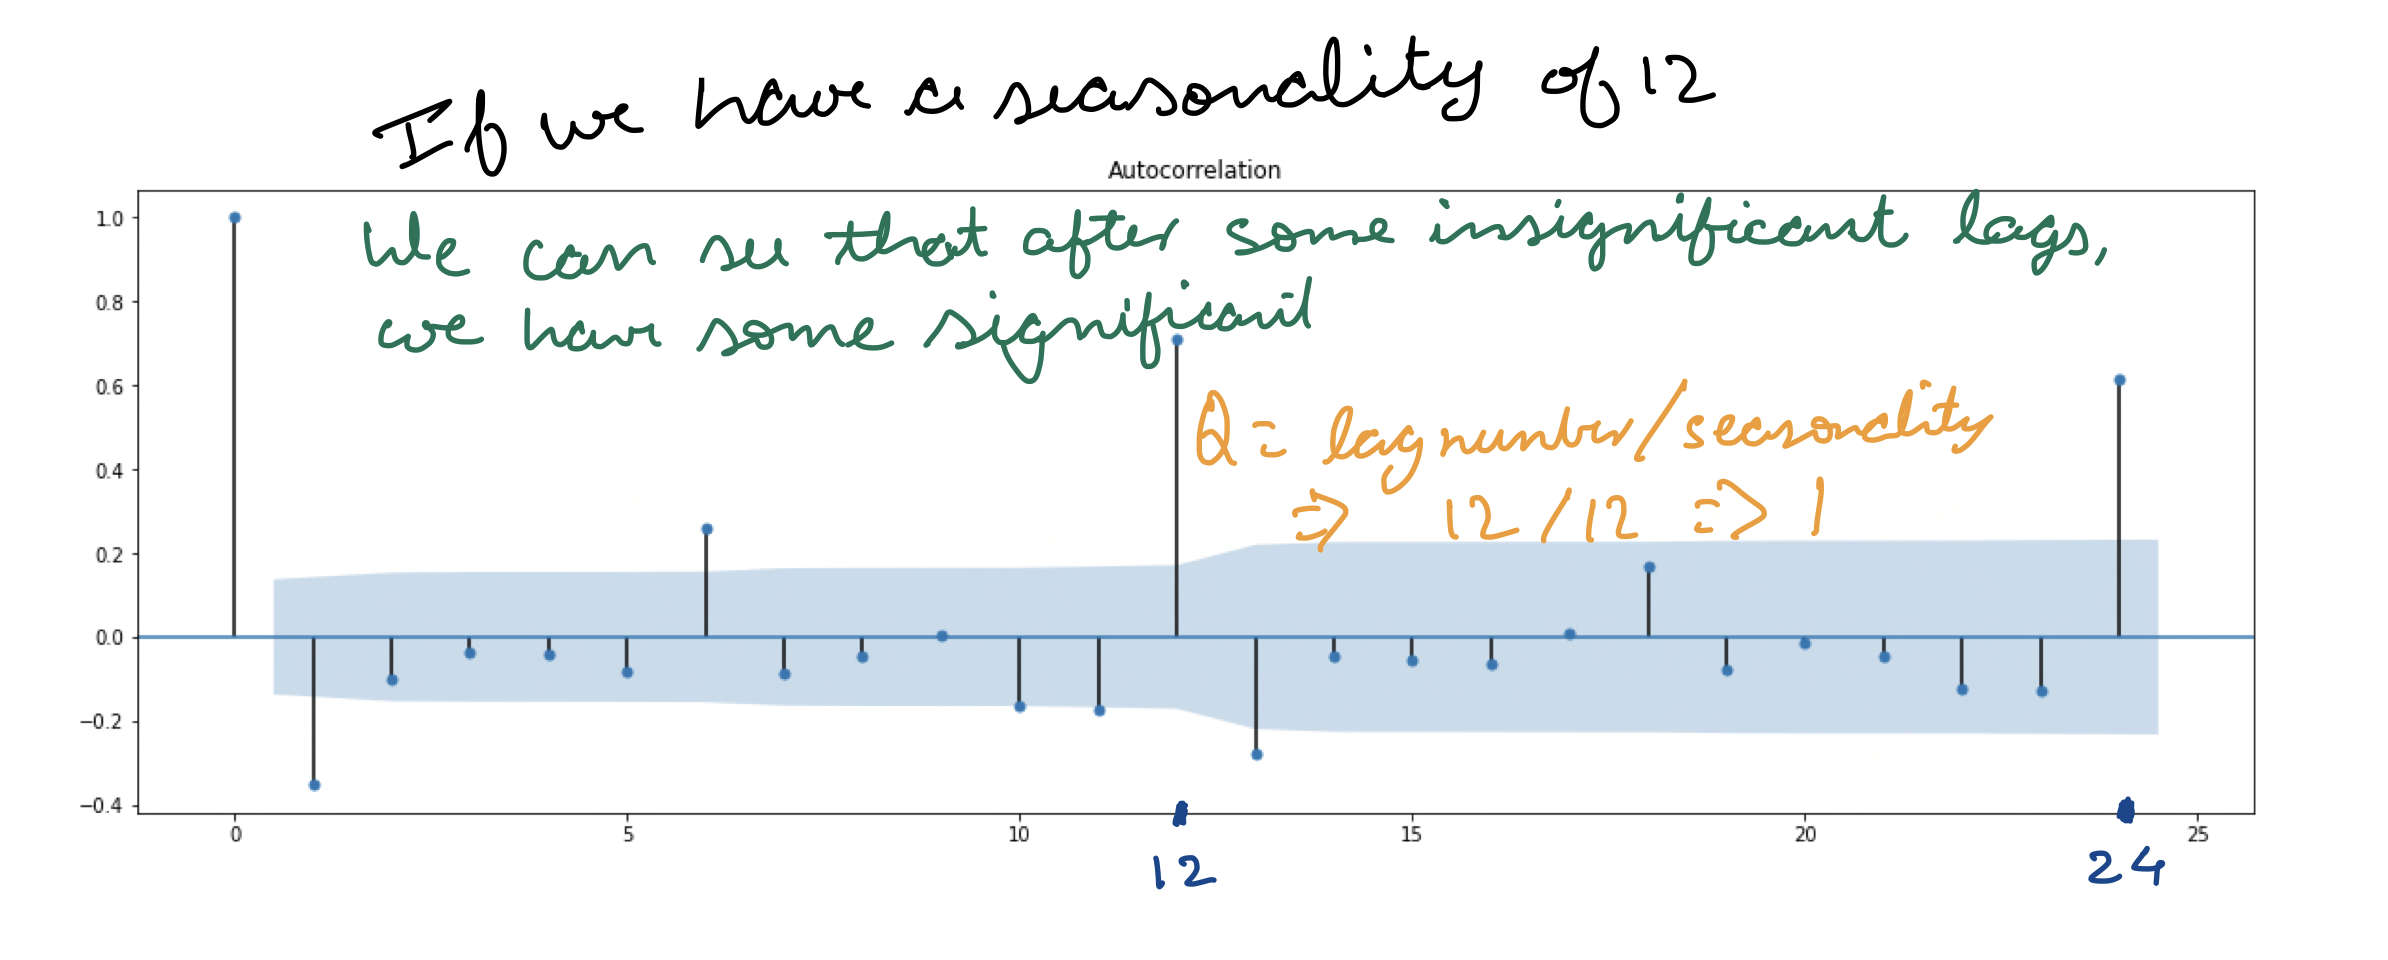

in our case we can say
- s=12
- D=1
- P=1
- Q=1

MAE : 539.029
RMSE : 630.333
MAPE: 0.038


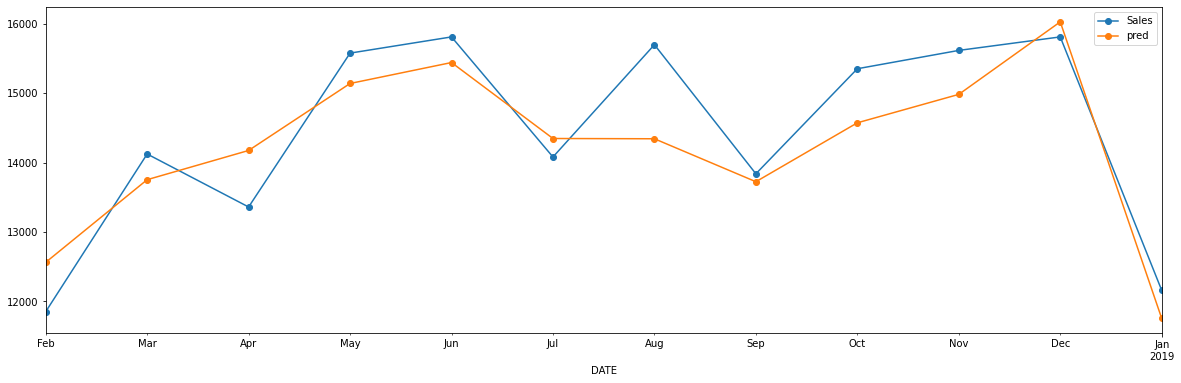

In [ ]:
model = SARIMAX(train_x.Sales, order=(3, 1, 3), seasonal_order=(1,1,1,12))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

## Prediction Intervals

Prediction intervals are used to provide a range where the forecast is likely to be with a specific degree of confidence. a prediction interval defines the interval within which the true value of the response variable is expected to be found with a given probability. By using a prediction interval you can account for uncertainty in the forecast, and the random variation of the data.

Owing to the potential error of our forecast, and unpredictability of future, we cannot claim to be a hundred percent sure of our forecasts.

- But we can still, based on our study of time series, say that the future value, would lie in the range of [A,B].

- Naturally A becomes the minimum possible value of our target variable at time t, and

- B becomes the maximum possible value at time t.

Prediction intervals provide an upper and lower expectation for the real observation.
This [A,B] becomes a range for determining the real possible value for a certain prediction.

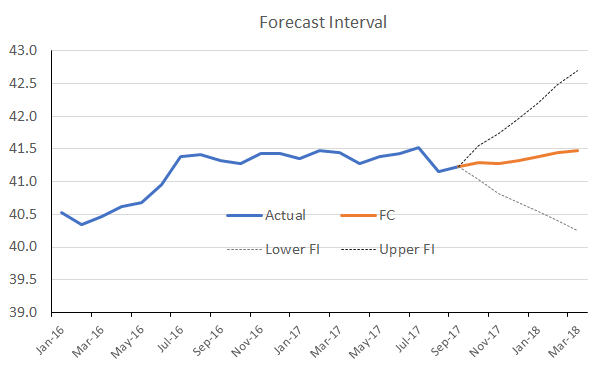

Let's use the returned upper and lower bound values of each forecast using the function `conf_int` to create separate series for lower and upper bounds for visualization purpose.

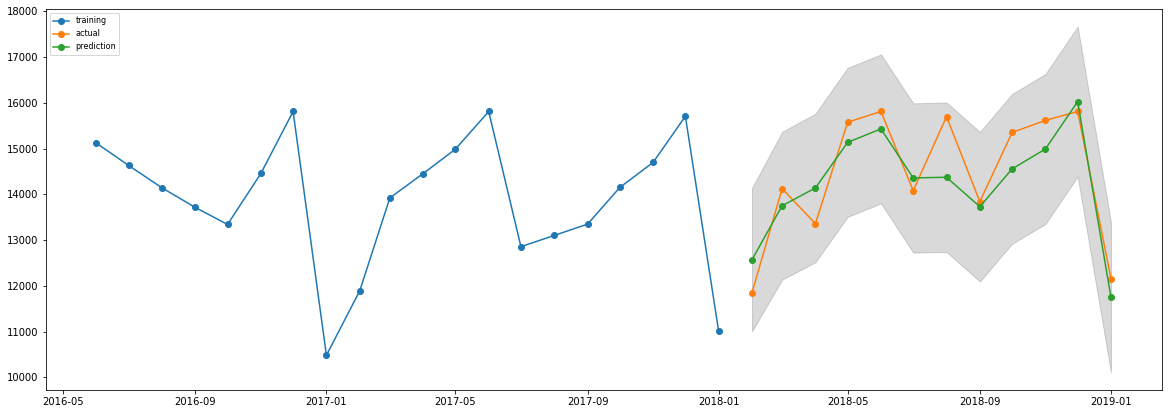

In [ ]:
test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.05).values
plt.plot(train_x['Sales'][-20:], '-o', label='training')
plt.plot(test_x['Sales'], '-o', label='actual')
plt.plot(test_x['pred'], '-o', label='prediction')
plt.fill_between(test_x.index, test_x['lower'], test_x['upper'],
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()